# Experiments in Modeling Issue Segmentation

## Load Libraries and Datasets

In [ ]:
import os
import re
import pandas as pd
from tqdm import tqdm
import altair as alt
alt.data_transformers.disable_max_rows()
from collections import deque
import warnings
warnings.filterwarnings('ignore')
from rich.console import Console
from rich.table import Table
import numpy as np
from scipy.fft import fft
import scipy.stats as stats
from scipy.signal import find_peaks
from minineedle import needle, core
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm
console = Console()
import sys

sys.path.append("..")
from segmentation_scripts.utils import read_csv_file, get_data_directory_path

In [3]:
def generate_table(df, table_title):
    # Create a Rich Table
    table = Table(title=table_title)
    columns = df.columns
    for column in columns:
        table.add_column(column.replace("_", " ").capitalize(), justify="center", style="cyan", no_wrap=True)    

    # Add rows to the table
    for _, row in df.iterrows():
        table.add_row(*[str(value) if pd.notna(value) else "" for value in row])

    # Print the table
    console.print(table)

In [147]:
def filter_integers(token: str) -> bool:
	"""Check if the token is an integer."""
	return bool(re.match(r'^\d+$', token))

def calculate_digit_coverage(rows):
    """Calculate the number of digits in the given rows."""
    number_of_digits = rows['implied_zero'].notna().sum()
    return number_of_digits

def clean_digits(df: pd.DataFrame) -> pd.DataFrame:
	"""Clean and filter digit tokens in the DataFrame while retaining non-digit pages."""
	max_possible_number = df.page_number.max()
	
	df['token'] = df['token'].astype(str)
	if 'volume_name' in df.columns:
		df['volume_number'] = df['volume_number'].fillna(0)
	
	# Identify pages with digit tokens
	subset_digits = df[df['token'].str.isdigit()].copy()
	possible_pages = subset_digits[subset_digits['token'].apply(filter_integers)].copy()
	# Use the smaller subset if possible_pages is smaller
	console.print(f"Number of possible pages {len(possible_pages)} vs subset_digits {len(subset_digits)}")
	if len(possible_pages) < len(subset_digits):
		subset_digits = possible_pages

	# Identify pages without digit tokens
	non_digits_pages = df[(~df['token'].str.isdigit()) & (~df.page_number.isin(subset_digits.page_number))].copy()
	
	# just take the first page of non_digits_pages
	non_digits_pages = non_digits_pages.groupby('page_number').first().reset_index()
	console.print(f"Number of digits in this volume: {len(subset_digits)}")
	console.print(f"Number of non-digit pages in this volume: {len(non_digits_pages)}")
	
	subset_digits['number'] = subset_digits['token'].astype(int, errors='ignore')
	# max_possible_number = max_page + 25
	filtered_subset_digits = subset_digits[(subset_digits['number'] < max_possible_number) & (subset_digits['number'] <= subset_digits.page_number)].copy()
	non_filtered_subset_digits = subset_digits[(subset_digits['number'] >= max_possible_number) & (~subset_digits.page_number.isin(filtered_subset_digits.page_number))].groupby('page_number').first().reset_index()
	console.print(f"Number of digits in this volume after filtering for max page length: {len(filtered_subset_digits)}")
	console.print(f"Number of pages without digits in this volume after filtering for max page length: {len(non_filtered_subset_digits)}")
	
	# Calculate implied zero only for digit pages
	filtered_subset_digits['implied_zero'] = filtered_subset_digits['page_number'].astype(int) - filtered_subset_digits['number']
	
	final_subset_digits = filtered_subset_digits[filtered_subset_digits['implied_zero'] >= 0]
	console.print(f"Number of digits in this volume after filtering for max page length and implied zero: {len(final_subset_digits)}")
	remaining_missing_pages = df[(~df.page_number.isin(final_subset_digits.page_number)) & (~df.page_number.isin(non_digits_pages.page_number))].copy()
	remaining_missing_pages = remaining_missing_pages.groupby('page_number').first().reset_index()
	console.print(f"Number of pages without digits in this volume after filtering for max page length and digit pages: {len(remaining_missing_pages)}")
	
	# Merge non-digit pages back into the DataFrame
	non_digits_pages['page_type'] = 'non_digit'
	remaining_missing_pages['page_type'] = 'negative_na_digit'
	final_subset_digits['page_type'] = 'digit'
	non_filtered_subset_digits['page_type'] = 'digit_too_large'
	full_df_with_digits = pd.concat([final_subset_digits, non_digits_pages, remaining_missing_pages, non_filtered_subset_digits]).sort_values(by=['page_number']).reset_index(drop=True)
	
	console.print(f"Number of pages after including non-digit pages: {full_df_with_digits.page_number.nunique()}")

	if full_df_with_digits.page_number.nunique() != df.page_number.nunique():
		added_pages = df[~df.page_number.isin(full_df_with_digits.page_number)].copy()
		added_pages = added_pages.groupby('page_number').first().reset_index()
		added_pages['page_type'] = 'added'
		full_df_with_digits = pd.concat([full_df_with_digits, added_pages]).sort_values(by=['page_number']).reset_index(drop=True)
		console.print(f"Number of pages after including added pages: {full_df_with_digits.page_number.nunique()}")

	# Calculate the number of digits per page
	tqdm.pandas(desc="Calculating digits per page")
	digits_per_page = full_df_with_digits.groupby('page_number').progress_apply(calculate_digit_coverage).reset_index(name='digits_per_page')
	full_df_with_digits = full_df_with_digits.merge(digits_per_page, on='page_number', how='left')
	
	return full_df_with_digits

In [148]:
def process_file(file_path: str, is_preidentified_periodical: bool):
	full_df = read_csv_file(file_path)
	console.print(f"Volume has this many tokens: {len(full_df)}")
	if is_preidentified_periodical:
		console.print(f"Volume has this many issues: {full_df.start_issue.nunique()}")
		console.print(f"Volume has this many pages: {full_df.page_number.nunique()}")
	# Factorize the 'issue_number' column to create 'actual_issue_number'
	full_df = full_df.sort_values(by=['page_number'])

	if is_preidentified_periodical:
		full_df = full_df.rename(columns={'issue_number': 'original_issue_number', 'page_number': 'original_page_number'})
		full_df['temp_issue_number'] = pd.factorize(full_df['original_issue_number'])[0]

	else:
		full_df = full_df.rename(columns={'page_number': 'original_page_number'})
	# Factorize the 'original_page_number' column
	factorized_values, unique_values = pd.factorize(full_df['original_page_number'])

	# Adjust the factorized values to start at 1
	full_df['page_number'] = factorized_values + 1
	# Expand count column
	expanded_df = full_df.loc[full_df.index.repeat(full_df['count'])].reset_index(drop=True)
	console.print(f"Expanded volume has this many tokens: {len(expanded_df)}")

	# Calculate the number of tokens per page
	tokens_per_page = expanded_df.groupby('page_number').size().reset_index(name='tokens_per_page')

	# Merge the token counts back into the original DataFrame
	expanded_df = expanded_df.merge(tokens_per_page, on='page_number', how='left')
	missing_pages = full_df[~full_df.page_number.isin(expanded_df.page_number.unique())]
	expanded_df = pd.concat([expanded_df, missing_pages], ignore_index=True)
	expanded_df = expanded_df.reset_index(drop=True)

	if is_preidentified_periodical:
		annotated_df = full_df[['page_number', 'start_issue', 'end_issue', 'type_of_page']].drop_duplicates()

		# Group by 'start_issue' and aggregate
		grouped_df = annotated_df.groupby('start_issue').agg(
			first_page=('page_number', 'min'),
			last_page=('page_number', 'max'),
			number_of_pages=('page_number', 'count')
		).reset_index()
		grouped_df = grouped_df.sort_values(by='first_page')

		generate_table(grouped_df, "Grouped by 'start_issue'")
	else:
		grouped_df = pd.DataFrame()

	# Example usage
	subset_digits = clean_digits(expanded_df)
	subset_digits = subset_digits.sort_values(by=['page_number'])

	if is_preidentified_periodical:
		counts_per_annotated_issue = subset_digits.start_issue.value_counts().reset_index()

		generate_table(counts_per_annotated_issue, "Counts per Annotated Issue")
	return expanded_df, subset_digits, grouped_df

	

In [153]:
file_path = matching_files_df['file_path'][0]
preidentified_periodical = True

In [155]:

expanded_df, subset_digits, grouped_df = process_file(file_path, is_preidentified_periodical=preidentified_periodical)
subset_expanded_df = expanded_df[['page_number', 'tokens_per_page', 'original_page_number', 'htid', 'title', 'pub_date', 'enumeration_chronology',
	'type_of_resource', 'title', 'date_created', 'pub_date', 'language',
	'access_profile', 'isbn', 'issn', 'lccn', 'oclc', 'page_count',
	'feature_schema_version', 'access_rights', 'alternate_title',
	'category', 'genre_ld', 'genre', 'contributor_ld', 'contributor',
	'handle_url', 'source_institution_ld', 'source_institution', 'lcc',
	'type', 'is_part_of', 'last_rights_update_date', 'pub_place_ld',
	'pub_place', 'main_entity_of_page', 'publisher_ld', 'publisher',
	'lowercase_periodical_name', 'publication_directory',
	'volume_directory', 'record_url', 'periodical_name',]].drop_duplicates()

min_subset_digits = subset_digits[['original_page_number',
	'digits_per_page', 'page_number']].drop_duplicates()

merged_expanded_df = subset_expanded_df.merge(min_subset_digits, on=['original_page_number', 'page_number'], how='left')
merged_expanded_df['tokens_per_page'] = merged_expanded_df['tokens_per_page'].fillna(0)
merged_expanded_df['digits_per_page'] = merged_expanded_df['digits_per_page'].fillna(0)
merged_expanded_df['smoothed_tokens_per_page'] = merged_expanded_df['tokens_per_page'].rolling(window=5, center=True).mean()
merged_expanded_df['smoothed_digits_per_page'] = merged_expanded_df['digits_per_page'].rolling(window=5, center=True).mean()

# Scale the tokens per page and digits per page
scaler = MinMaxScaler()

merged_expanded_df['scaled_tokens_per_page'] = scaler.fit_transform(merged_expanded_df[['smoothed_tokens_per_page']])
merged_expanded_df['scaled_digits_per_page'] = scaler.fit_transform(merged_expanded_df[['smoothed_digits_per_page']])

merged_expanded_df['scaled_tokens_per_page'] = merged_expanded_df['scaled_tokens_per_page'].fillna(0)
merged_expanded_df['scaled_digits_per_page'] = merged_expanded_df['scaled_digits_per_page'].fillna(0)


console.print(merged_expanded_df[['page_number', 'tokens_per_page', 'smoothed_tokens_per_page', 'scaled_tokens_per_page', 'digits_per_page', 'smoothed_digits_per_page', 'scaled_digits_per_page']].head(2))

# Perform FFT
tokens_fft = fft(merged_expanded_df['scaled_tokens_per_page'].dropna().values)
digits_fft = fft(merged_expanded_df['scaled_digits_per_page'].dropna().values)

# Calculate frequencies
frequencies = np.fft.fftfreq(len(tokens_fft))

# Detect peaks
token_peaks, _ = find_peaks(merged_expanded_df['scaled_tokens_per_page'].dropna().values, height=0.5)
digit_peaks, _ = find_peaks(merged_expanded_df['scaled_digits_per_page'].dropna().values, height=0.5)

# Calculate autocorrelation
tokens_autocorr = np.correlate(
	merged_expanded_df['scaled_tokens_per_page'].dropna().values, 
	merged_expanded_df['scaled_tokens_per_page'].dropna().values, 
	mode='full'
)

digits_autocorr = np.correlate(
	merged_expanded_df['scaled_digits_per_page'].dropna().values, 
	merged_expanded_df['scaled_digits_per_page'].dropna().values, 
	mode='full'
)

# Plot
lags = np.arange(-len(tokens_autocorr)//2, len(tokens_autocorr)//2)
# Identify dominant lag from autocorrelation
tokens_autocorr_lag = np.argmax(tokens_autocorr[len(tokens_autocorr)//2 + 1:]) + 1
digits_autocorr_lag = np.argmax(digits_autocorr[len(digits_autocorr)//2 + 1:]) + 1
print(f"Likely issue length from tokens autocorrelation: {tokens_autocorr_lag}")
print(f"Likely issue length from digits autocorrelation: {digits_autocorr_lag}")
# Detect likely covers
merged_expanded_df['is_likely_cover'] = (
	(merged_expanded_df['scaled_tokens_per_page'] < 0.2) &  # Low tokens
	(merged_expanded_df['scaled_digits_per_page'] < 0.2)    # Low digits
)

# Aggregate features for embedding
volume_features = {
	'avg_tokens': merged_expanded_df['tokens_per_page'].mean(),
	'avg_digits': merged_expanded_df['digits_per_page'].mean(),
	'dominant_frequency': frequencies[np.argmax(np.abs(tokens_fft[:len(frequencies)//2]))],
	'issue_length': tokens_autocorr_lag,  # Or use digits_autocorr_lag,
	'htid': merged_expanded_df['htid'].unique()[0],
	'periodical_name': merged_expanded_df['periodical_name'].unique()[0],
}

console.print(volume_features)

Volume has this many tokens: 21002

Volume has this many issues: 3

Volume has this many pages: 72

Expanded volume has this many tokens: 41781

                 Grouped by 'start_issue'                 
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Start issue ┃ First page ┃ Last page ┃ Number of pages ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ 1969-10-01  │     1      │    24     │       24        │
│ 1969-11-01  │     25     │    48     │       24        │
│ 1969-12-01  │     49     │    72     │       24        │
└─────────────┴────────────┴───────────┴─────────────────┘

Number of possible pages 564 vs subset_digits 564

Number of digits in this volume: 564

Number of non-digit pages in this volume: 4

Number of digits in this volume after filtering for max page length: 273

Number of pages without digits in this volume after filtering for max page length: 14

Number of digits in this volume after filtering for max page length and implied zero: 273

Number of pages without digits in this volume after filtering for max page length and digit pages: 14

Number of pages after including non-digit pages: 72

Calculating digits per page: 100%|██████████| 72/72 [00:00<00:00, 9652.87it/s]


 Counts per Annotated  
         Issue         
┏━━━━━━━━━━━━━┳━━━━━━━┓
┃ Start issue ┃ Count ┃
┡━━━━━━━━━━━━━╇━━━━━━━┩
│ 1969-12-01  │  118  │
│ 1969-11-01  │  104  │
│ 1969-10-01  │  83   │
└─────────────┴───────┘

page_number  tokens_per_page  smoothed_tokens_per_page  \
0            1             26.0                       NaN   
1            2            271.0                       NaN   

   scaled_tokens_per_page  digits_per_page  smoothed_digits_per_page  \
0                     0.0                0                       NaN   
1                     0.0                4                       NaN   

   scaled_digits_per_page  
0                     0.0  
1                     0.0

Likely issue length from tokens autocorrelation: 1
Likely issue length from digits autocorrelation: 1


{
    'avg_tokens': 580.2916666666666,
    'avg_digits': 3.7916666666666665,
    'dominant_frequency': 0.0,
    'issue_length': 1,
    'htid': 'mdp.39015038717792',
    'periodical_name': 'Liberator'
}

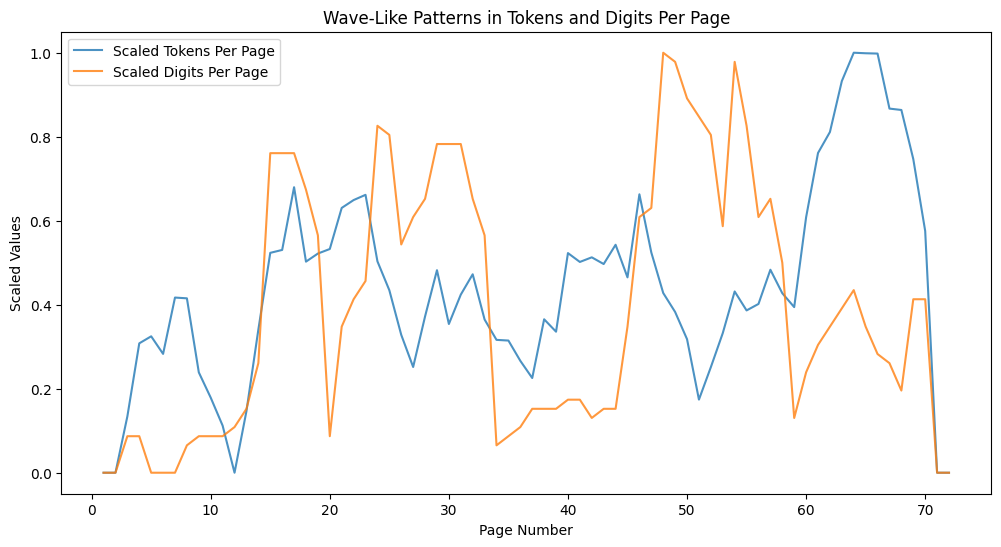

In [156]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Tokens per page
plt.plot(merged_expanded_df['page_number'], merged_expanded_df['scaled_tokens_per_page'], label='Scaled Tokens Per Page', alpha=0.8)

# Digits per page
plt.plot(merged_expanded_df['page_number'], merged_expanded_df['scaled_digits_per_page'], label='Scaled Digits Per Page', alpha=0.8)

plt.title('Wave-Like Patterns in Tokens and Digits Per Page')
plt.xlabel('Page Number')
plt.ylabel('Scaled Values')
plt.legend()
plt.show()

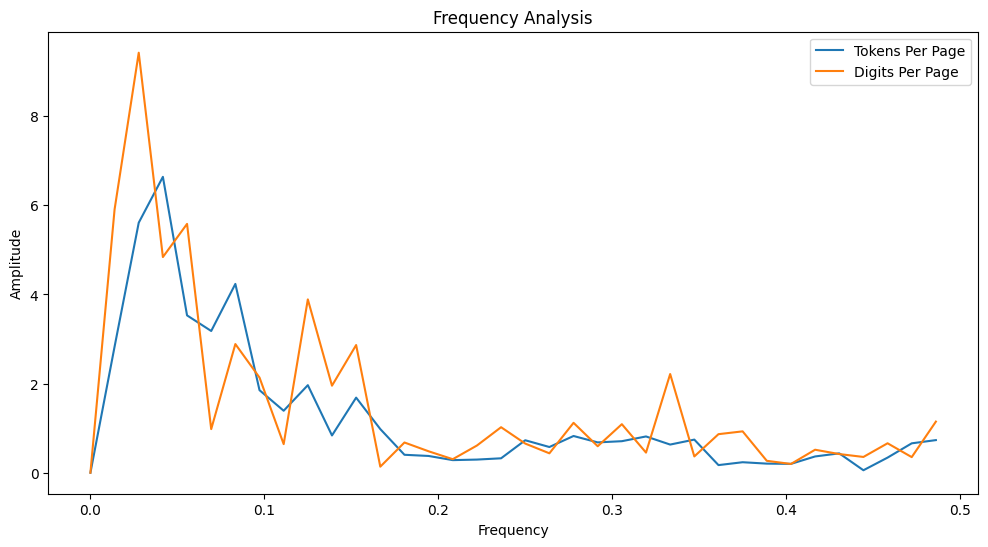

In [ ]:
from scipy.fft import fft


tokens_fft_input = merged_expanded_df['scaled_tokens_per_page'].dropna().values
tokens_fft_input -= np.mean(tokens_fft_input)  # Remove DC offset

digits_fft_input = merged_expanded_df['scaled_digits_per_page'].dropna().values
digits_fft_input -= np.mean(digits_fft_input)  # Remove DC offset

tokens_fft = fft(tokens_fft_input)
digits_fft = fft(digits_fft_input)
frequencies = np.fft.fftfreq(len(tokens_fft))

plt.figure(figsize=(12, 6))
plt.plot(frequencies[:len(frequencies)//2], np.abs(tokens_fft[:len(frequencies)//2]), label='Tokens Per Page')
plt.plot(frequencies[:len(frequencies)//2], np.abs(digits_fft[:len(frequencies)//2]), label='Digits Per Page')
plt.title('Frequency Analysis')
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

In [168]:
# Calculate dominant frequency
print(f"Length of frequencies: {len(frequencies)}")
dominant_frequency_index = np.argmax(np.abs(tokens_fft[1:len(frequencies)//2])) + 1
print(f"Dominant Frequency Index: {dominant_frequency_index}")
dominant_frequency = frequencies[dominant_frequency_index]
print(f"Dominant Frequency: {dominant_frequency}")
# Ensure dominant frequency is positive
if dominant_frequency < 0:
    dominant_frequency = -dominant_frequency

print(f"Dominant Frequency: {dominant_frequency}")
print(merged_expanded_df[['scaled_tokens_per_page', 'scaled_digits_per_page']].describe())

Length of frequencies: 72
Dominant Frequency Index: 3
Dominant Frequency: 0.041666666666666664
Dominant Frequency: 0.041666666666666664
       scaled_tokens_per_page  scaled_digits_per_page
count               72.000000               72.000000
mean                 0.440928                0.394022
std                  0.237435                0.303009
min                  0.000000                0.000000
25%                  0.315917                0.125000
50%                  0.425688                0.347826
75%                  0.531009                0.652174
max                  1.000000                1.000000


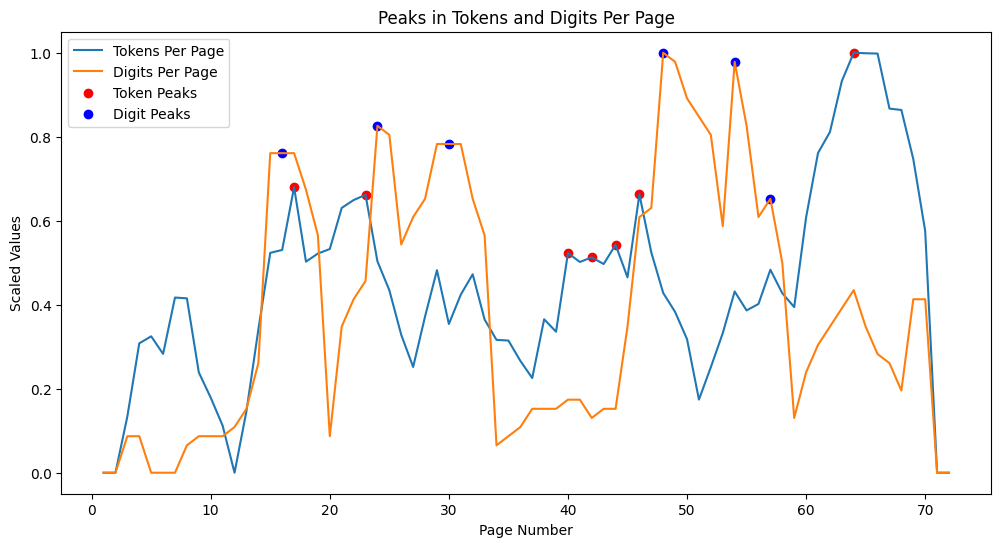

In [169]:
from scipy.signal import find_peaks

# Detect peaks
token_peaks, _ = find_peaks(merged_expanded_df['scaled_tokens_per_page'].dropna().values, height=0.5)
digit_peaks, _ = find_peaks(merged_expanded_df['scaled_digits_per_page'].dropna().values, height=0.5)

# Plot with peaks
plt.figure(figsize=(12, 6))
plt.plot(merged_expanded_df['page_number'], merged_expanded_df['scaled_tokens_per_page'], label='Tokens Per Page')
plt.plot(merged_expanded_df['page_number'], merged_expanded_df['scaled_digits_per_page'], label='Digits Per Page')
plt.scatter(merged_expanded_df['page_number'].iloc[token_peaks], merged_expanded_df['scaled_tokens_per_page'].iloc[token_peaks], color='red', label='Token Peaks')
plt.scatter(merged_expanded_df['page_number'].iloc[digit_peaks], merged_expanded_df['scaled_digits_per_page'].iloc[digit_peaks], color='blue', label='Digit Peaks')
plt.title('Peaks in Tokens and Digits Per Page')
plt.xlabel('Page Number')
plt.ylabel('Scaled Values')
plt.legend()
plt.show()

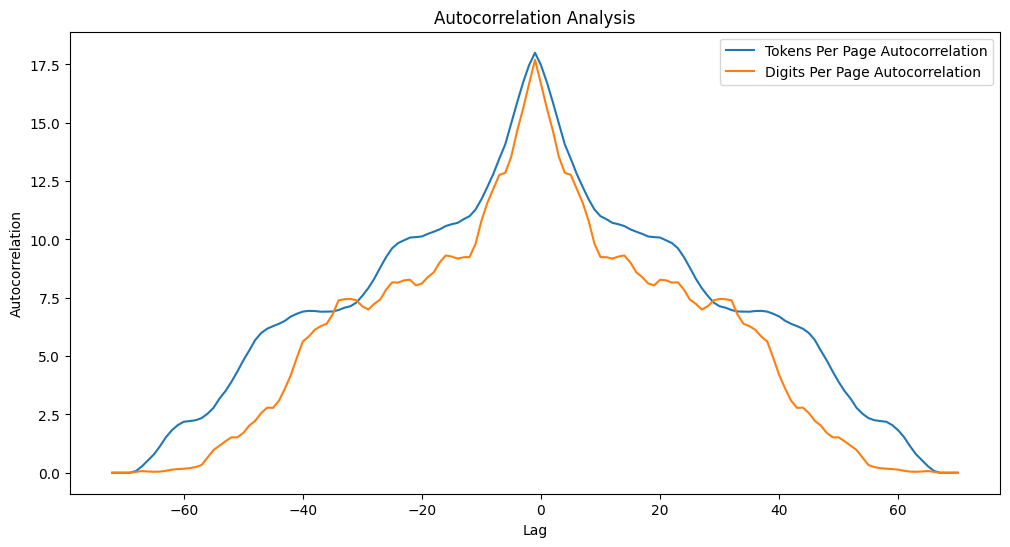

In [170]:
# Calculate autocorrelation
tokens_autocorr = np.correlate(
    merged_expanded_df['scaled_tokens_per_page'].dropna().values, 
    merged_expanded_df['scaled_tokens_per_page'].dropna().values, 
    mode='full'
)

digits_autocorr = np.correlate(
    merged_expanded_df['scaled_digits_per_page'].dropna().values, 
    merged_expanded_df['scaled_digits_per_page'].dropna().values, 
    mode='full'
)

# Plot
lags = np.arange(-len(tokens_autocorr)//2, len(tokens_autocorr)//2)

plt.figure(figsize=(12, 6))
plt.plot(lags, tokens_autocorr, label='Tokens Per Page Autocorrelation')
plt.plot(lags, digits_autocorr, label='Digits Per Page Autocorrelation')
plt.title('Autocorrelation Analysis')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.legend()
plt.show()

In [171]:
# Identify dominant lag from autocorrelation
tokens_autocorr_lag = np.argmax(tokens_autocorr[len(tokens_autocorr)//2 + 1:]) + 1
digits_autocorr_lag = np.argmax(digits_autocorr[len(digits_autocorr)//2 + 1:]) + 1
print(f"Likely issue length from tokens autocorrelation: {tokens_autocorr_lag}")
print(f"Likely issue length from digits autocorrelation: {digits_autocorr_lag}")

Likely issue length from tokens autocorrelation: 1
Likely issue length from digits autocorrelation: 1


In [172]:
# Detect likely covers
merged_expanded_df['is_likely_cover'] = (
    (merged_expanded_df['scaled_tokens_per_page'] < 0.2) &  # Low tokens
    (merged_expanded_df['scaled_digits_per_page'] < 0.2)    # Low digits
)

In [173]:
# Aggregate features for embedding
volume_features = {
    'avg_tokens': merged_expanded_df['tokens_per_page'].mean(),
    'avg_digits': merged_expanded_df['digits_per_page'].mean(),
    'dominant_frequency': frequencies[np.argmax(np.abs(tokens_fft[:len(frequencies)//2]))],
    'issue_length': tokens_autocorr_lag,  # Or use digits_autocorr_lag,
	'htid': merged_expanded_df['htid'].unique()[0],
	'periodical_name': merged_expanded_df['periodical_name'].unique()[0],
}

console.print(volume_features)

{
    'avg_tokens': 580.2916666666666,
    'avg_digits': 3.7916666666666665,
    'dominant_frequency': 0.041666666666666664,
    'issue_length': 1,
    'htid': 'mdp.39015038717792',
    'periodical_name': 'Liberator'
}

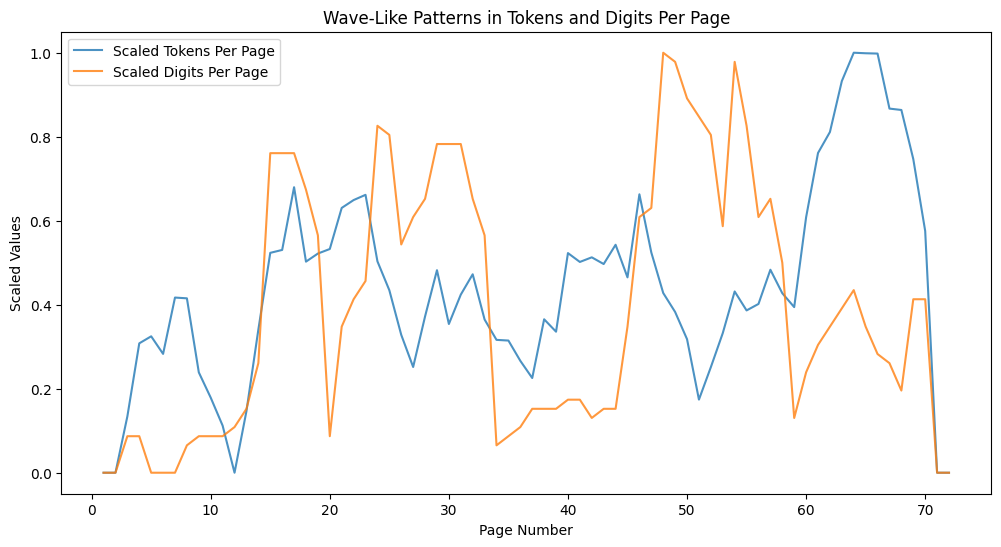

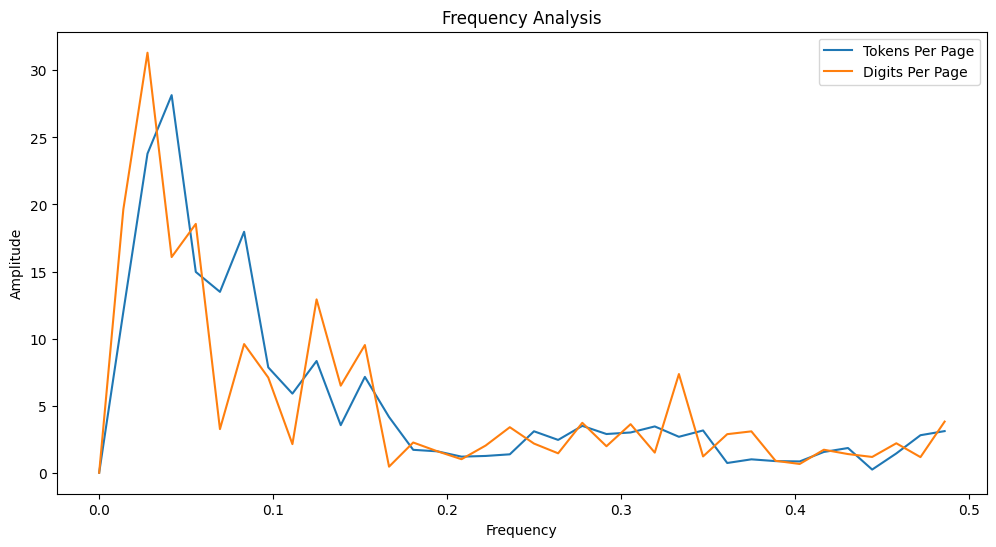

Dominant Frequency: 0.041666666666666664

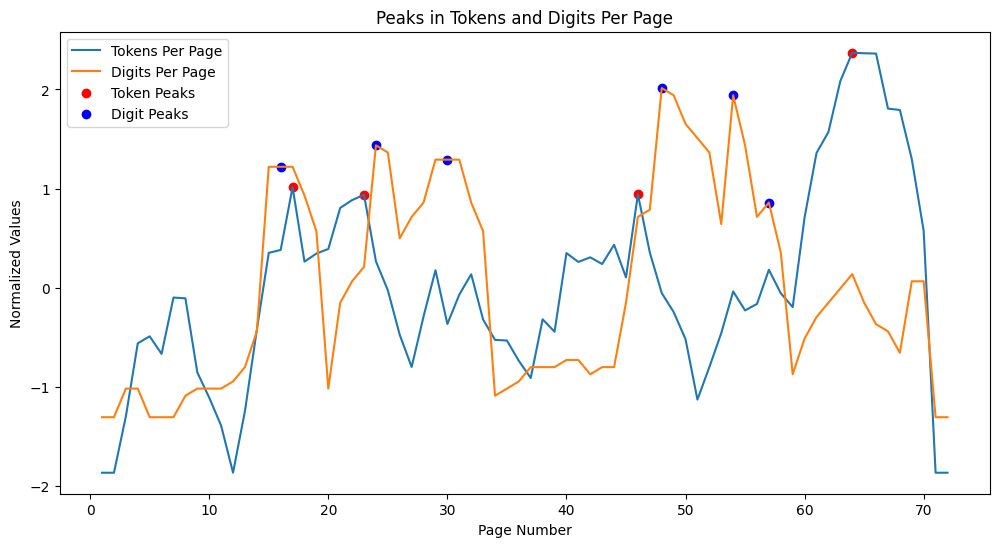

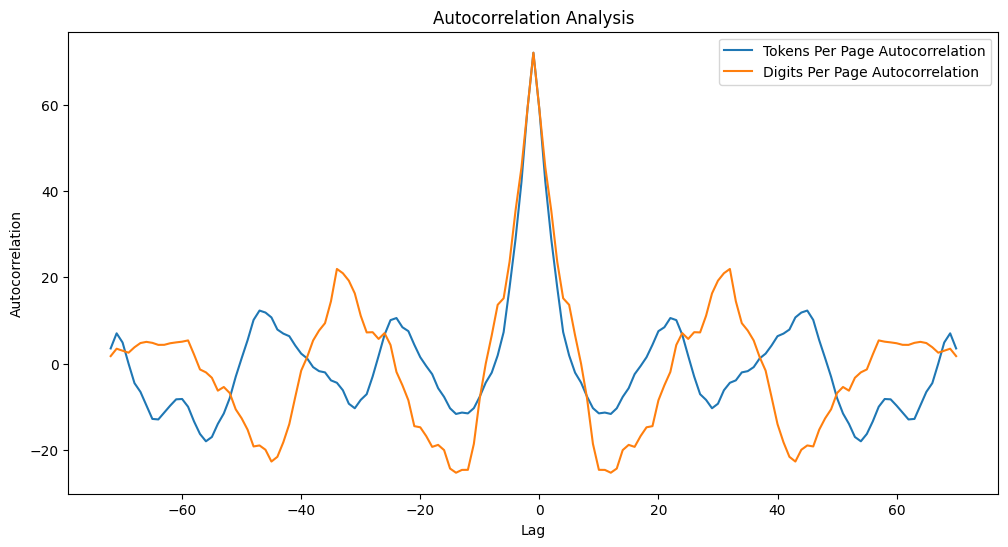

Likely issue length from tokens autocorrelation: 23

Likely issue length from digits autocorrelation: 25

{
    'avg_tokens': 580.2916666666666,
    'avg_digits': 3.7916666666666665,
    'dominant_frequency': 0.041666666666666664,
    'issue_length': 23,
    'htid': 'mdp.39015038717792',
    'periodical_name': 'Liberator'
}

In [174]:
# Plot Tokens and Digits Per Page
plt.figure(figsize=(12, 6))
plt.plot(merged_expanded_df['page_number'], merged_expanded_df['scaled_tokens_per_page'], label='Scaled Tokens Per Page', alpha=0.8)
plt.plot(merged_expanded_df['page_number'], merged_expanded_df['scaled_digits_per_page'], label='Scaled Digits Per Page', alpha=0.8)
plt.title('Wave-Like Patterns in Tokens and Digits Per Page')
plt.xlabel('Page Number')
plt.ylabel('Scaled Values')
plt.legend()
plt.show()

# Normalize signals for FFT and autocorrelation
scaled_tokens = merged_expanded_df['scaled_tokens_per_page'].dropna().values
scaled_digits = merged_expanded_df['scaled_digits_per_page'].dropna().values

tokens_normalized = (scaled_tokens - np.mean(scaled_tokens)) / np.std(scaled_tokens)
digits_normalized = (scaled_digits - np.mean(scaled_digits)) / np.std(scaled_digits)

# Perform FFT
tokens_fft = fft(tokens_normalized)
digits_fft = fft(digits_normalized)
frequencies = np.fft.fftfreq(len(tokens_fft))

# Plot FFT results
plt.figure(figsize=(12, 6))
plt.plot(frequencies[:len(frequencies)//2], np.abs(tokens_fft[:len(frequencies)//2]), label='Tokens Per Page')
plt.plot(frequencies[:len(frequencies)//2], np.abs(digits_fft[:len(frequencies)//2]), label='Digits Per Page')
plt.title('Frequency Analysis')
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

# Calculate dominant frequency
dominant_frequency_index = np.argmax(np.abs(tokens_fft[1:len(frequencies)//2])) + 1
dominant_frequency = frequencies[dominant_frequency_index]
if dominant_frequency < 0:
    dominant_frequency = -dominant_frequency

console.print(f"Dominant Frequency: {dominant_frequency}")

# Detect Peaks in Signal
token_peaks, _ = find_peaks(tokens_normalized, height=0.5)
digit_peaks, _ = find_peaks(digits_normalized, height=0.5)

# Plot Peaks
plt.figure(figsize=(12, 6))
plt.plot(merged_expanded_df['page_number'], tokens_normalized, label='Tokens Per Page')
plt.plot(merged_expanded_df['page_number'], digits_normalized, label='Digits Per Page')
plt.scatter(merged_expanded_df['page_number'].iloc[token_peaks], tokens_normalized[token_peaks], color='red', label='Token Peaks')
plt.scatter(merged_expanded_df['page_number'].iloc[digit_peaks], digits_normalized[digit_peaks], color='blue', label='Digit Peaks')
plt.title('Peaks in Tokens and Digits Per Page')
plt.xlabel('Page Number')
plt.ylabel('Normalized Values')
plt.legend()
plt.show()

# Calculate Autocorrelation
tokens_autocorr = np.correlate(tokens_normalized, tokens_normalized, mode='full')
digits_autocorr = np.correlate(digits_normalized, digits_normalized, mode='full')

# Plot Autocorrelation
lags = np.arange(-len(tokens_autocorr)//2, len(tokens_autocorr)//2)
plt.figure(figsize=(12, 6))
plt.plot(lags, tokens_autocorr, label='Tokens Per Page Autocorrelation')
plt.plot(lags, digits_autocorr, label='Digits Per Page Autocorrelation')
plt.title('Autocorrelation Analysis')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.legend()
plt.show()

# Identify Dominant Lag (Issue Length)
from scipy.signal import find_peaks

# Use find_peaks to locate all significant peaks
tokens_peaks, _ = find_peaks(tokens_autocorr[len(tokens_autocorr)//2 + 1:], height=0.1)  # Skip lag 0
digits_peaks, _ = find_peaks(digits_autocorr[len(digits_autocorr)//2 + 1:], height=0.1)  # Skip lag 0

tokens_peak_lags = tokens_peaks + 1  # Adjust for indexing
digits_peak_lags = digits_peaks + 1  # Adjust for indexing

if len(tokens_peak_lags) > 0:
    tokens_autocorr_lag = tokens_peak_lags[0]  # Use first peak as dominant lag
else:
    tokens_autocorr_lag = 1  # Default to 1 if no peaks are found

if len(digits_peak_lags) > 0:
    digits_autocorr_lag = digits_peak_lags[0]  # Use first peak as dominant lag
else:
    digits_autocorr_lag = 1  # Default to 1 if no peaks are found

console.print(f"Likely issue length from tokens autocorrelation: {tokens_autocorr_lag}")
console.print(f"Likely issue length from digits autocorrelation: {digits_autocorr_lag}")

# Detect Likely Covers
merged_expanded_df['is_likely_cover'] = (
    (merged_expanded_df['scaled_tokens_per_page'] < 0.2) &  # Low tokens
    (merged_expanded_df['scaled_digits_per_page'] < 0.2)    # Low digits
)

# Aggregate Features for Embedding
volume_features = {
    'avg_tokens': merged_expanded_df['tokens_per_page'].mean(),
    'avg_digits': merged_expanded_df['digits_per_page'].mean(),
    'dominant_frequency': dominant_frequency,
    'issue_length': tokens_autocorr_lag,  # Use the token-based autocorrelation lag
    'htid': merged_expanded_df['htid'].unique()[0],
    'periodical_name': merged_expanded_df['periodical_name'].unique()[0],
}

console.print(volume_features)

In [181]:
processed_volume_features = read_csv_file("../segmentation_scripts/volume_features.csv")

In [178]:
preidentified_periodicals_df.periodical_name.value_counts()

periodical_name
New world review                                                224
Presence Africaine                                              176
Beijing Review                                                  170
Soviet life                                                     156
Peking Review                                                   143
                                                               ... 
Palestine                                                         1
Palestine issue /\n\n\nthe Palestine Liberation Organization      1
\nSWAPO information bulletin                                      1
Namibia                                                           1
OAU Bulletin                                                      1
Name: count, Length: 66, dtype: int64

In [180]:
processed_volume_features.htid.duplicated().sum()

12009

In [101]:
data_directory_path = get_data_directory_path()
preidentified_periodicals_df = read_csv_file(os.path.join(data_directory_path, "HathiTrust-pcc-datasets", "datasets", "preidentified_periodicals_with_full_metadata.csv"))

In [137]:
preidentified_periodicals_df[0:1].to_dict()

{'link': {0: 'https://babel.hathitrust.org/cgi/pt?id=inu.30000093395964'},
 'htid': {0: 'inu.30000093395964'},
 'date': {0: nan},
 'original_source': {0: 'Indiana University'},
 'record_url': {0: 'https://catalog.hathitrust.org/Record/007579658'},
 'periodical_name': {0: 'La Documentation Arabe '},
 'publication_type': {0: 'Information Bulletin'},
 'table_row_index': {0: 1},
 'id': {0: 'inu.30000093395964'},
 'metadata_schema_version': {0: 'https://schemas.hathitrust.org/EF_Schema_MetadataSubSchema_v_3.0'},
 'enumeration_chronology': {0: nan},
 'type_of_resource': {0: 'http://id.loc.gov/ontologies/bibframe/Text'},
 'title': {0: 'La Documentation arabe.'},
 'date_created': {0: 20200209.0},
 'pub_date': {0: 1962.0},
 'language': {0: 'fre'},
 'access_profile': {0: 'google'},
 'isbn': {0: nan},
 'issn': {0: nan},
 'lccn': {0: 'ne 63000581'},
 'oclc': {0: 6101458.0},
 'page_count': {0: 486.0},
 'feature_schema_version': {0: 'https://schemas.hathitrust.org/EF_Schema_FeaturesSubSchema_v_3.0'}

In [138]:
matching_files_df[0:1].to_dict()

{'file': {0: 'mdp_39015038717792_annotated_individual_tokens.csv'},
 'directory': {0: '../datasets/annotated_ht_ef_datasets/liberator/mdp_39015038717792'},
 'file_path': {0: '../datasets/annotated_ht_ef_datasets/liberator/mdp_39015038717792/mdp_39015038717792_annotated_individual_tokens.csv'},
 'periodical_title': {0: 'liberator'},
 'volume_directory': {0: 'mdp_39015038717792'}}

In [97]:
# Count the number of matching files
matching_files = []
for directory, _, files in tqdm(os.walk("../datasets/annotated_ht_ef_datasets/"), desc="Counting matching files"):
	for file in files:
		if file.endswith(".csv") and 'individual' in file:
			if os.path.exists(os.path.join(directory, file)):
				publication_name = directory.split("/")[-2]
				volume_number = directory.split("/")[-1]
				matching_files.append({"file": file, "directory": directory, "file_path": os.path.join(directory, file), "periodical_title": publication_name, "volume_directory": volume_number})
matching_files_df = pd.DataFrame(matching_files)
console.print(f"Found {len(matching_files_df)} matching files.", style="bright_green")

Counting matching files: 95it [00:00, 10657.69it/s]


Found 85 matching files.

In [98]:
matching_files_df[0:1].to_dict()

{'file': {0: 'mdp_39015038717792_annotated_individual_tokens.csv'},
 'directory': {0: '../datasets/annotated_ht_ef_datasets/liberator/mdp_39015038717792'},
 'file_path': {0: '../datasets/annotated_ht_ef_datasets/liberator/mdp_39015038717792/mdp_39015038717792_annotated_individual_tokens.csv'},
 'periodical_title': {0: 'liberator'},
 'volume_directory': {0: 'mdp_39015038717792'}}

In [69]:
liberator_df = read_csv_file("../datasets/metadatas/liberator_merged_annotated_preidentified_periodical_with_full_metadata.csv")

In [71]:
liberator_df[['pub_date', 'enumeration_chronology', 'volume_directory']].drop_duplicates().sort_values(by=['pub_date', 'enumeration_chronology'])

,pub_date,enumeration_chronology,volume_directory
0,1965.0,v.5 1965,mdp_39015065389044
26,1967.0,v.6-7 1966-1967,mdp_39015050659344
68,1968.0,v.8 1968,mdp_39015065389036
88,1969.0,v.9 no.10-12 1969 Oct-Dec,mdp_39015038717792
96,1970.0,v.10 1970,mdp_39015070510345
125,1971.0,v.11,mdp_39015083020449


In [68]:
for index, row in matching_files_df[matching_files_df.periodical_title == "liberator"].iterrows():
	file = row['file']
	directory = row['directory']
	file_path = row['file_path']
	console.print(f"Processing file: {file_path}. Number {index} out of {len(matching_files_df)}", style="bright_white")
	file_df = read_csv_file(file_path)
	console.print(file_df.pub_date.unique(), file_df.enumeration_chronology.unique())

Processing file: 
../datasets/annotated_ht_ef_datasets/liberator/mdp_39015038717792/mdp_39015038717792_annotated_individual_tokens.cs
v. Number 0 out of 85

[1969.] ['v.9 no.10-12 1969 Oct-Dec']

Processing file: 
../datasets/annotated_ht_ef_datasets/liberator/mdp_39015083020449/mdp_39015083020449_annotated_individual_tokens.cs
v. Number 1 out of 85

[1971.] ['v.11']

Processing file: 
../datasets/annotated_ht_ef_datasets/liberator/mdp_39015065389044/mdp_39015065389044_annotated_individual_tokens.cs
v. Number 2 out of 85

[1965.] ['v.5 1965']

Processing file: 
../datasets/annotated_ht_ef_datasets/liberator/mdp_39015065389036/mdp_39015065389036_annotated_individual_tokens.cs
v. Number 3 out of 85

[1968.] ['v.8 1968']

Processing file: 
../datasets/annotated_ht_ef_datasets/liberator/mdp_39015050659344/mdp_39015050659344_annotated_individual_tokens.cs
v. Number 4 out of 85

[1967.] ['v.6-7 1966-1967']

Processing file: 
../datasets/annotated_ht_ef_datasets/liberator/mdp_39015070510345/mdp_39015070510345_annotated_individual_tokens.cs
v. Number 5 out of 85

[1970.] ['v.10 1970']

In [8]:
matching_files_df.periodical_title.value_counts()

periodical_title
lotus                           27
arab_observer_and_the_scribe    23
tricontinental                  12
afro_asian_bulletin              9
liberator                        6
afro_asian_and_world_affairs     3
afro_asian_peoples               2
solidarity_aapso                 2
scribe                           1
Name: count, dtype: int64

In [67]:
matching_files_df[matching_files_df.periodical_title == "solidarity_aapso"]

,file,directory,file_path,periodical_title
74,uc1_c2693407_annotated_individual_tokens.csv,../datasets/annotated_ht_ef_datasets/solidarit...,../datasets/annotated_ht_ef_datasets/solidarit...,solidarity_aapso
75,inu_30000003214412_annotated_individual_tokens...,../datasets/annotated_ht_ef_datasets/solidarit...,../datasets/annotated_ht_ef_datasets/solidarit...,solidarity_aapso


In [65]:
missing_issues_df = pd.DataFrame(missing_issues)

missing_issues_df = missing_issues_df[missing_issues_df.missing_issues.str.len() > 0]
missing_issues_df.to_csv("missing_issues.csv", index=False)

In [66]:
missing_issues_df

,file_path,missing_issues,periodical_title
3,../datasets/annotated_ht_ef_datasets/liberator...,"[1968-05-01, 1968-06-01]",liberator
8,../datasets/annotated_ht_ef_datasets/arab_obse...,[1966-09-26],arab_observer_and_the_scribe
18,../datasets/annotated_ht_ef_datasets/arab_obse...,"[1963-07-15, 1963-09-30]",arab_observer_and_the_scribe
20,../datasets/annotated_ht_ef_datasets/arab_obse...,"[1965-08-02, 1965-08-16, 1965-08-30, 1965-09-06]",arab_observer_and_the_scribe
27,../datasets/annotated_ht_ef_datasets/arab_obse...,[1963-11-04],arab_observer_and_the_scribe
58,../datasets/annotated_ht_ef_datasets/tricontin...,[1966-08-01],tricontinental
61,../datasets/annotated_ht_ef_datasets/tricontin...,[1980-05-01],tricontinental
69,../datasets/annotated_ht_ef_datasets/afro_asia...,"[1964-09-01, 1965-12-01, 1966-09-01, 1966-12-01]",afro_asian_and_world_affairs
84,../datasets/annotated_ht_ef_datasets/afro_asia...,[1962-09-01],afro_asian_bulletin


In [57]:
# alt.vconcat(*charts)

In [64]:
charts = []
missing_issues = []
for index, row in matching_files_df.iterrows():
	file = row['file']
	directory = row['directory']
	file_path = row['file_path']
	console.print(f"Processing file: {file_path}. Number {index} out of {len(matching_files_df)}", style="bright_white")
	expanded_df, subset_digits, grouped_df = process_file(file_path)
	distribution_df, mean_digit_ratio_per_issue, chart, missing_issues_results = calculate_coverage(expanded_df, subset_digits, grouped_df)
	charts.append(chart)
	missing_issues.append({"file_path": file_path, "missing_issues": missing_issues_results, "periodical_title": row['periodical_title']})
	

Processing file: 
../datasets/annotated_ht_ef_datasets/liberator/mdp_39015038717792/mdp_39015038717792_annotated_individual_tokens.cs
v. Number 0 out of 85

Volume has this many tokens: 21002

Volume has this many issues: 3

Volume has this many pages: 72

Expanded volume has this many tokens: 41781

                 Grouped by 'start_issue'                 
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Start issue ┃ First page ┃ Last page ┃ Number of pages ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ 1969-10-01  │     1      │    24     │       24        │
│ 1969-11-01  │     25     │    48     │       24        │
│ 1969-12-01  │     49     │    72     │       24        │
└─────────────┴────────────┴───────────┴─────────────────┘

Number of possible pages 564 vs subset_digits 564

Number of digits in this volume: 564

Number of non-digit pages in this volume: 4

Number of digits in this volume after filtering for max page length: 273

Number of pages without digits in this volume after filtering for max page length: 14

Number of digits in this volume after filtering for max page length and implied zero: 273

Number of pages without digits in this volume after filtering for max page length and digit pages: 14

Number of pages after including non-digit pages: 72

Calculating digits per page: 100%|██████████| 72/72 [00:00<00:00, 9887.37it/s]


 Counts per Annotated  
         Issue         
┏━━━━━━━━━━━━━┳━━━━━━━┓
┃ Start issue ┃ Count ┃
┡━━━━━━━━━━━━━╇━━━━━━━┩
│ 1969-12-01  │  118  │
│ 1969-11-01  │  104  │
│ 1969-10-01  │  83   │
└─────────────┴───────┘

      Mean Digit Ratio per Issue      
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Start issue ┃   Mean digit ratio   ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 1969-10-01  │ 0.015605263887281872 │
│ 1969-11-01  │ 0.018624168582820847 │
│ 1969-12-01  │ 0.012152887092185718 │
└─────────────┴──────────────────────┘

Checking if actual issue: 100%|██████████| 36/36 [00:00<00:00, 2276.04it/s]


We are missing the following issues with this approach []

            Lowest Ten Percent of Tokens per Page             
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Start issue ┃ Page number ┃ Tokens per page ┃ Actual issue ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ 1969-10-01  │      1      │       26        │     True     │
│ 1969-11-01  │     25      │       73        │     True     │
│ 1969-12-01  │     49      │       29        │     True     │
└─────────────┴─────────────┴─────────────────┴──────────────┘

Processing file: 
../datasets/annotated_ht_ef_datasets/liberator/mdp_39015083020449/mdp_39015083020449_annotated_individual_tokens.cs
v. Number 1 out of 85

Volume has this many tokens: 13809

Volume has this many issues: 2

Volume has this many pages: 48

Expanded volume has this many tokens: 28501

                 Grouped by 'start_issue'                 
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Start issue ┃ First page ┃ Last page ┃ Number of pages ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ 1971-01-01  │     1      │    24     │       24        │
│ 1971-03-01  │     25     │    48     │       24        │
└─────────────┴────────────┴───────────┴─────────────────┘

Number of possible pages 371 vs subset_digits 371

Number of digits in this volume: 371

Number of non-digit pages in this volume: 1

Number of digits in this volume after filtering for max page length: 171

Number of pages without digits in this volume after filtering for max page length: 5

Number of digits in this volume after filtering for max page length and implied zero: 171

Number of pages without digits in this volume after filtering for max page length and digit pages: 6

Number of pages after including non-digit pages: 48

Calculating digits per page: 100%|██████████| 48/48 [00:00<00:00, 9017.18it/s]


 Counts per Annotated  
         Issue         
┏━━━━━━━━━━━━━┳━━━━━━━┓
┃ Start issue ┃ Count ┃
┡━━━━━━━━━━━━━╇━━━━━━━┩
│ 1971-01-01  │  92   │
│ 1971-03-01  │  91   │
└─────────────┴───────┘

      Mean Digit Ratio per Issue      
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Start issue ┃   Mean digit ratio   ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 1971-01-01  │ 0.047814063785711236 │
│ 1971-03-01  │ 0.011657558014095425 │
└─────────────┴──────────────────────┘

Checking if actual issue: 100%|██████████| 24/24 [00:00<00:00, 2034.79it/s]


We are missing the following issues with this approach []

            Lowest Ten Percent of Tokens per Page             
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Start issue ┃ Page number ┃ Tokens per page ┃ Actual issue ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ 1971-01-01  │      1      │       42        │     True     │
│ 1971-03-01  │     25      │       35        │     True     │
└─────────────┴─────────────┴─────────────────┴──────────────┘

Processing file: 
../datasets/annotated_ht_ef_datasets/liberator/mdp_39015065389044/mdp_39015065389044_annotated_individual_tokens.cs
v. Number 2 out of 85

Volume has this many tokens: 133614

Volume has this many issues: 12

Volume has this many pages: 371

Expanded volume has this many tokens: 279829

                 Grouped by 'start_issue'                 
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Start issue ┃ First page ┃ Last page ┃ Number of pages ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ 1965-01-01  │     1      │    32     │       32        │
│ 1965-02-01  │     33     │    63     │       31        │
│ 1965-03-01  │     64     │    95     │       32        │
│ 1965-04-01  │     96     │    127    │       32        │
│ 1965-05-01  │    128     │    159    │       32        │
│ 1965-06-01  │    160     │    190    │       31        │
│ 1965-07-01  │    191     │    221    │       31        │
│ 1965-08-01  │    222     │    251    │       30        │
│ 1965-09-01  │    252     │    283    │       32        │
│ 1965-10-01  │    284     │    314    │       31        │
│ 1965-11-01  │    315     │    346    │       32        │
│ 1965-12-01  │    347     │    371    │       25        │
└─────────────┴────────────┴───────────┴─────────────────┘

Number of possible pages 3623 vs subset_digits 3623

Number of digits in this volume: 3623

Number of non-digit pages in this volume: 17

Number of digits in this volume after filtering for max page length: 2041

Number of pages without digits in this volume after filtering for max page length: 28

Number of digits in this volume after filtering for max page length and implied zero: 2041

Number of pages without digits in this volume after filtering for max page length and digit pages: 33

Number of pages after including non-digit pages: 371

Calculating digits per page: 100%|██████████| 371/371 [00:00<00:00, 9604.64it/s]


 Counts per Annotated  
         Issue         
┏━━━━━━━━━━━━━┳━━━━━━━┓
┃ Start issue ┃ Count ┃
┡━━━━━━━━━━━━━╇━━━━━━━┩
│ 1965-10-01  │  344  │
│ 1965-11-01  │  247  │
│ 1965-09-01  │  235  │
│ 1965-07-01  │  224  │
│ 1965-08-01  │  188  │
│ 1965-05-01  │  184  │
│ 1965-06-01  │  171  │
│ 1965-04-01  │  138  │
│ 1965-12-01  │  123  │
│ 1965-02-01  │  98   │
│ 1965-01-01  │  89   │
│ 1965-03-01  │  78   │
└─────────────┴───────┘

      Mean Digit Ratio per Issue      
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Start issue ┃   Mean digit ratio   ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 1965-01-01  │ 0.004771046748764932 │
│ 1965-02-01  │ 0.006231081502617507 │
│ 1965-03-01  │ 0.008706521468511703 │
│ 1965-04-01  │ 0.006818276945366937 │
│ 1965-05-01  │ 0.012257505513344497 │
│ 1965-06-01  │ 0.010014493091798655 │
│ 1965-07-01  │ 0.009377253729495447 │
│ 1965-08-01  │ 0.008154658304129783 │
│ 1965-09-01  │ 0.010206110419530514 │
│ 1965-10-01  │ 0.02289388337803621  │
│ 1965-11-01  │ 0.012832435607731204 │
│ 1965-12-01  │ 0.02097813776084809  │
└─────────────┴──────────────────────┘

Checking if actual issue: 100%|██████████| 186/186 [00:00<00:00, 2415.96it/s]


We are missing the following issues with this approach []

            Lowest Ten Percent of Tokens per Page             
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Start issue ┃ Page number ┃ Tokens per page ┃ Actual issue ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ 1965-01-01  │      1      │       643       │     True     │
│ 1965-02-01  │     33      │       467       │     True     │
│ 1965-03-01  │     64      │       468       │     True     │
│ 1965-04-01  │     96      │       648       │     True     │
│ 1965-05-01  │     128     │       554       │     True     │
│ 1965-06-01  │     160     │       485       │     True     │
│ 1965-07-01  │     191     │       456       │     True     │
│ 1965-08-01  │     222     │       575       │     True     │
│ 1965-09-01  │     252     │       716       │     True     │
│ 1965-10-01  │     284     │       497       │     True     │
│ 1965-11-01  │     315     │       539       │     True     │
│ 1965-12-01  │     347     │       543       │     True     │
└─────────────┴─────────────┴─────────────────┴──────────────┘

Processing file: 
../datasets/annotated_ht_ef_datasets/liberator/mdp_39015065389036/mdp_39015065389036_annotated_individual_tokens.cs
v. Number 3 out of 85

Volume has this many tokens: 45580

Volume has this many issues: 9

Volume has this many pages: 151

Expanded volume has this many tokens: 92522

                 Grouped by 'start_issue'                 
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Start issue ┃ First page ┃ Last page ┃ Number of pages ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ 1968-02-01  │     1      │    23     │       23        │
│ 1968-03-01  │     24     │    47     │       24        │
│ 1968-04-01  │     48     │    71     │       24        │
│ 1968-05-01  │     72     │    95     │       24        │
│ 1968-06-01  │     96     │    119    │       24        │
│ 1968-07-01  │    120     │    143    │       24        │
│ 1968-08-01  │    144     │    146    │        3        │
│ 1968-09-01  │    147     │    148    │        2        │
│ 1968-10-01  │    149     │    151    │        3        │
└─────────────┴────────────┴───────────┴─────────────────┘

Number of possible pages 1164 vs subset_digits 1164

Number of digits in this volume: 1164

Number of non-digit pages in this volume: 23

Number of digits in this volume after filtering for max page length: 448

Number of pages without digits in this volume after filtering for max page length: 23

Number of digits in this volume after filtering for max page length and implied zero: 448

Number of pages without digits in this volume after filtering for max page length and digit pages: 23

Number of pages after including non-digit pages: 151

Calculating digits per page: 100%|██████████| 151/151 [00:00<00:00, 1245.25it/s]


 Counts per Annotated  
         Issue         
┏━━━━━━━━━━━━━┳━━━━━━━┓
┃ Start issue ┃ Count ┃
┡━━━━━━━━━━━━━╇━━━━━━━┩
│ 1968-07-01  │  100  │
│ 1968-04-01  │  83   │
│ 1968-06-01  │  77   │
│ 1968-05-01  │  73   │
│ 1968-03-01  │  69   │
│ 1968-02-01  │  59   │
│ 1968-08-01  │  51   │
│ 1968-10-01  │   3   │
│ 1968-09-01  │   2   │
└─────────────┴───────┘

      Mean Digit Ratio per Issue       
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Start issue ┃   Mean digit ratio    ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ 1968-02-01  │ 0.0047896659065364035 │
│ 1968-03-01  │ 0.006652605354601131  │
│ 1968-04-01  │ 0.007937931773008002  │
│ 1968-05-01  │  0.00535826269234883  │
│ 1968-06-01  │ 0.012901207394015679  │
│ 1968-07-01  │  0.00698427160757737  │
│ 1968-08-01  │  0.01742586956973465  │
│ 1968-09-01  │                       │
│ 1968-10-01  │                       │
└─────────────┴───────────────────────┘

Checking if actual issue: 100%|██████████| 76/76 [00:00<00:00, 2387.38it/s]


We are missing the following issues with this approach ['1968-05-01' '1968-06-01']

            Lowest Ten Percent of Tokens per Page             
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Start issue ┃ Page number ┃ Tokens per page ┃ Actual issue ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ 1968-02-01  │      1      │       41        │     True     │
│ 1968-03-01  │     24      │       549       │     True     │
│ 1968-04-01  │     48      │       548       │     True     │
│ 1968-07-01  │     120     │       542       │     True     │
│ 1968-08-01  │     144     │       524       │     True     │
│ 1968-09-01  │     147     │        1        │     True     │
│ 1968-10-01  │     149     │        1        │     True     │
└─────────────┴─────────────┴─────────────────┴──────────────┘

Processing file: 
../datasets/annotated_ht_ef_datasets/liberator/mdp_39015050659344/mdp_39015050659344_annotated_individual_tokens.cs
v. Number 4 out of 85

Volume has this many tokens: 157023

Volume has this many issues: 21

Volume has this many pages: 470

Expanded volume has this many tokens: 323591

                 Grouped by 'start_issue'                 
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Start issue ┃ First page ┃ Last page ┃ Number of pages ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ 1965-12-01  │     1      │     2     │        2        │
│ 1966-01-01  │     3      │    25     │       23        │
│ 1966-02-01  │     26     │    48     │       23        │
│ 1966-03-01  │     49     │    72     │       24        │
│ 1966-04-01  │     73     │    96     │       24        │
│ 1966-05-01  │     97     │    118    │       22        │
│ 1966-06-01  │    119     │    141    │       23        │
│ 1966-07-01  │    142     │    164    │       23        │
│ 1966-08-01  │    165     │    188    │       24        │
│ 1966-09-01  │    189     │    214    │       26        │
│ 1966-10-01  │    215     │    238    │       24        │
│ 1966-11-01  │    239     │    261    │       23        │
│ 1966-12-01  │    262     │    285    │       24        │
│ 1967-01-01  │    286     │    309    │       24        │
│ 1967-02-01  │    310     │    333    │       24        │
│ 1967-03-01  │    334     │    357    │       24        │
│ 1967-05-01  │    358     │    380    │       23        │
│ 1967-06-01  │    381     │    404    │       24        │
│ 1967-10-01  │    405     │    426    │       22        │
│ 1967-11-01  │    427     │    448    │       22        │
│ 1967-12-01  │    449     │    470    │       22        │
└─────────────┴────────────┴───────────┴─────────────────┘

Number of possible pages 4107 vs subset_digits 4107

Number of digits in this volume: 4107

Number of non-digit pages in this volume: 30

Number of digits in this volume after filtering for max page length: 2612

Number of pages without digits in this volume after filtering for max page length: 26

Number of digits in this volume after filtering for max page length and implied zero: 2612

Number of pages without digits in this volume after filtering for max page length and digit pages: 26

Number of pages after including non-digit pages: 470

Calculating digits per page: 100%|██████████| 470/470 [00:00<00:00, 8164.96it/s]


 Counts per Annotated  
         Issue         
┏━━━━━━━━━━━━━┳━━━━━━━┓
┃ Start issue ┃ Count ┃
┡━━━━━━━━━━━━━╇━━━━━━━┩
│ 1966-09-01  │  186  │
│ 1967-02-01  │  178  │
│ 1966-12-01  │  170  │
│ 1967-06-01  │  166  │
│ 1967-05-01  │  166  │
│ 1967-01-01  │  154  │
│ 1967-03-01  │  149  │
│ 1966-11-01  │  144  │
│ 1966-10-01  │  138  │
│ 1967-11-01  │  134  │
│ 1966-08-01  │  132  │
│ 1967-12-01  │  131  │
│ 1966-06-01  │  130  │
│ 1967-10-01  │  128  │
│ 1966-07-01  │  121  │
│ 1966-04-01  │  111  │
│ 1966-03-01  │  102  │
│ 1966-02-01  │  94   │
│ 1966-05-01  │  93   │
│ 1966-01-01  │  65   │
│ 1965-12-01  │   2   │
└─────────────┴───────┘

      Mean Digit Ratio per Issue      
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Start issue ┃   Mean digit ratio   ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 1965-12-01  │         0.0          │
│ 1966-01-01  │ 0.005224708865047918 │
│ 1966-02-01  │ 0.01632213623704004  │
│ 1966-03-01  │ 0.007893643789776687 │
│ 1966-04-01  │ 0.010865217131916398 │
│ 1966-05-01  │ 0.006931765803122435 │
│ 1966-06-01  │ 0.013805380171308291 │
│ 1966-07-01  │ 0.007690754034215308 │
│ 1966-08-01  │ 0.013668654884027284 │
│ 1966-09-01  │ 0.014080294503958268 │
│ 1966-10-01  │ 0.011251202596233703 │
│ 1966-11-01  │ 0.008686151418542625 │
│ 1966-12-01  │ 0.011690337979368476 │
│ 1967-01-01  │ 0.011698544553791127 │
│ 1967-02-01  │ 0.010114807325982467 │
│ 1967-03-01  │  0.0176867422190801  │
│ 1967-05-01  │ 0.012802619959597904 │
│ 1967-06-01  │ 0.017013128915577103 │
│ 1967-10-01  │ 0.009258745440832007 │
│ 1967-11-01  │ 0.011950142198417528 │
│ 1967-12-01  │ 0.014741723502785398 │
└─────────────┴──────────────────────┘

Checking if actual issue: 100%|██████████| 236/236 [00:00<00:00, 2037.50it/s]


We are missing the following issues with this approach []

            Lowest Ten Percent of Tokens per Page             
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Start issue ┃ Page number ┃ Tokens per page ┃ Actual issue ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ 1965-12-01  │      1      │        1        │     True     │
│ 1966-01-01  │      3      │       31        │     True     │
│ 1966-02-01  │     26      │       39        │     True     │
│ 1966-03-01  │     49      │        1        │     True     │
│ 1966-04-01  │     73      │       61        │     True     │
│ 1966-05-01  │     97      │       42        │     True     │
│ 1966-06-01  │     119     │       18        │     True     │
│ 1966-07-01  │     142     │       66        │     True     │
│ 1966-08-01  │     165     │       29        │     True     │
│ 1966-09-01  │     189     │        1        │     True     │
│ 1966-10-01  │     215     │       58        │     True     │
│ 1966-11-01  │     239     │        1        │     True     │
│ 1966-12-01  │     262     │       68        │     True     │
│ 1967-01-01  │     286     │       52        │     True     │
│ 1967-02-01  │     310     │       30        │     True     │
│ 1967-03-01  │     334     │       36        │     True     │
│ 1967-05-01  │     358     │       29        │     True     │
│ 1967-06-01  │     381     │        1        │     True     │
│ 1967-10-01  │     405     │       22        │     True     │
│ 1967-11-01  │     427     │       29        │     True     │
│ 1967-12-01  │     449     │       16        │     True     │
└─────────────┴─────────────┴─────────────────┴──────────────┘

Processing file: 
../datasets/annotated_ht_ef_datasets/liberator/mdp_39015070510345/mdp_39015070510345_annotated_individual_tokens.cs
v. Number 5 out of 85

Volume has this many tokens: 62727

Volume has this many issues: 12

Volume has this many pages: 218

Expanded volume has this many tokens: 126212

                 Grouped by 'start_issue'                 
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Start issue ┃ First page ┃ Last page ┃ Number of pages ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ 1970-01-01  │     1      │    24     │       24        │
│ 1970-02-01  │     25     │    47     │       23        │
│ 1970-03-01  │     48     │    71     │       24        │
│ 1970-04-01  │     72     │    94     │       23        │
│ 1970-05-01  │     95     │    118    │       24        │
│ 1970-06-01  │    119     │    141    │       23        │
│ 1970-07-01  │    142     │    165    │       24        │
│ 1970-08-01  │    166     │    189    │       24        │
│ 1970-09-01  │    190     │    211    │       22        │
│ 1970-10-01  │    212     │    213    │        2        │
│ 1970-11-01  │    214     │    215    │        2        │
│ 1970-12-01  │    216     │    218    │        3        │
└─────────────┴────────────┴───────────┴─────────────────┘

Number of possible pages 1493 vs subset_digits 1493

Number of digits in this volume: 1493

Number of non-digit pages in this volume: 19

Number of digits in this volume after filtering for max page length: 834

Number of pages without digits in this volume after filtering for max page length: 12

Number of digits in this volume after filtering for max page length and implied zero: 834

Number of pages without digits in this volume after filtering for max page length and digit pages: 12

Number of pages after including non-digit pages: 218

Calculating digits per page: 100%|██████████| 218/218 [00:00<00:00, 3275.00it/s]


 Counts per Annotated  
         Issue         
┏━━━━━━━━━━━━━┳━━━━━━━┓
┃ Start issue ┃ Count ┃
┡━━━━━━━━━━━━━╇━━━━━━━┩
│ 1970-07-01  │  134  │
│ 1970-04-01  │  129  │
│ 1970-09-01  │  126  │
│ 1970-03-01  │  104  │
│ 1970-08-01  │  103  │
│ 1970-06-01  │  80   │
│ 1970-02-01  │  77   │
│ 1970-05-01  │  64   │
│ 1970-01-01  │  53   │
│ 1970-12-01  │   3   │
│ 1970-10-01  │   2   │
│ 1970-11-01  │   2   │
└─────────────┴───────┘

      Mean Digit Ratio per Issue       
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Start issue ┃   Mean digit ratio    ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ 1970-01-01  │ 0.0033577962746700295 │
│ 1970-02-01  │ 0.020154671942927995  │
│ 1970-03-01  │ 0.025487042906319365  │
│ 1970-04-01  │ 0.017559105783864742  │
│ 1970-05-01  │ 0.016926324729928558  │
│ 1970-06-01  │ 0.018434939387649216  │
│ 1970-07-01  │  0.02078117611209559  │
│ 1970-08-01  │  0.00891381631415985  │
│ 1970-09-01  │ 0.022623375483079182  │
│ 1970-10-01  │                       │
│ 1970-11-01  │                       │
│ 1970-12-01  │                       │
└─────────────┴───────────────────────┘

Checking if actual issue: 100%|██████████| 109/109 [00:00<00:00, 2381.22it/s]


We are missing the following issues with this approach []

            Lowest Ten Percent of Tokens per Page             
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Start issue ┃ Page number ┃ Tokens per page ┃ Actual issue ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ 1970-01-01  │      1      │       29        │     True     │
│ 1970-02-01  │     25      │        4        │     True     │
│ 1970-03-01  │     48      │       24        │     True     │
│ 1970-04-01  │     72      │       28        │     True     │
│ 1970-05-01  │     95      │        9        │     True     │
│ 1970-06-01  │     119     │       19        │     True     │
│ 1970-07-01  │     142     │       22        │     True     │
│ 1970-08-01  │     166     │        6        │     True     │
│ 1970-09-01  │     190     │        1        │     True     │
│ 1970-10-01  │     212     │        1        │     True     │
│ 1970-11-01  │     214     │        1        │     True     │
│ 1970-12-01  │     216     │        1        │     True     │
└─────────────┴─────────────┴─────────────────┴──────────────┘

Processing file: 
../datasets/annotated_ht_ef_datasets/arab_observer_and_the_scribe/mdp_39015056038220/mdp_39015056038220_annotated_i
ndividual_tokens.csv. Number 6 out of 85

Volume has this many tokens: 270914

Volume has this many issues: 17

Volume has this many pages: 924

Expanded volume has this many tokens: 546194

                 Grouped by 'start_issue'                 
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Start issue ┃ First page ┃ Last page ┃ Number of pages ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ 1964-09-07  │     1      │    55     │       55        │
│ 1964-09-14  │     56     │    108    │       53        │
│ 1964-09-21  │    109     │    163    │       55        │
│ 1964-09-28  │    164     │    218    │       55        │
│ 1964-10-05  │    219     │    273    │       55        │
│ 1964-10-12  │    274     │    329    │       56        │
│ 1964-10-19  │    330     │    385    │       56        │
│ 1964-10-26  │    386     │    438    │       53        │
│ 1964-11-02  │    439     │    491    │       53        │
│ 1964-11-09  │    492     │    544    │       53        │
│ 1964-11-16  │    545     │    598    │       54        │
│ 1964-11-23  │    599     │    653    │       55        │
│ 1964-11-30  │    654     │    708    │       55        │
│ 1964-12-07  │    709     │    761    │       53        │
│ 1964-12-14  │    762     │    814    │       53        │
│ 1964-12-21  │    815     │    868    │       54        │
│ 1964-12-28  │    869     │    924    │       56        │
└─────────────┴────────────┴───────────┴─────────────────┘

Number of possible pages 5962 vs subset_digits 5962

Number of digits in this volume: 5962

Number of non-digit pages in this volume: 128

Number of digits in this volume after filtering for max page length: 3734

Number of pages without digits in this volume after filtering for max page length: 16

Number of digits in this volume after filtering for max page length and implied zero: 3734

Number of pages without digits in this volume after filtering for max page length and digit pages: 18

Number of pages after including non-digit pages: 924

Calculating digits per page: 100%|██████████| 924/924 [00:00<00:00, 11319.80it/s]


 Counts per Annotated  
         Issue         
┏━━━━━━━━━━━━━┳━━━━━━━┓
┃ Start issue ┃ Count ┃
┡━━━━━━━━━━━━━╇━━━━━━━┩
│ 1964-10-12  │  320  │
│ 1964-11-09  │  268  │
│ 1964-10-05  │  258  │
│ 1964-11-23  │  256  │
│ 1964-12-28  │  254  │
│ 1964-11-16  │  245  │
│ 1964-12-21  │  244  │
│ 1964-12-14  │  240  │
│ 1964-09-14  │  233  │
│ 1964-10-19  │  227  │
│ 1964-12-07  │  227  │
│ 1964-11-30  │  223  │
│ 1964-10-26  │  222  │
│ 1964-09-28  │  212  │
│ 1964-11-02  │  179  │
│ 1964-09-21  │  169  │
│ 1964-09-07  │  119  │
└─────────────┴───────┘

      Mean Digit Ratio per Issue       
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Start issue ┃   Mean digit ratio    ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ 1964-09-07  │ 0.0037531386189521175 │
│ 1964-09-14  │ 0.010542326093067472  │
│ 1964-09-21  │ 0.006585096857713799  │
│ 1964-09-28  │ 0.007365391978901087  │
│ 1964-10-05  │ 0.009533313605899164  │
│ 1964-10-12  │ 0.010205002047135496  │
│ 1964-10-19  │  0.0288964173643794   │
│ 1964-10-26  │ 0.008081283559100712  │
│ 1964-11-02  │ 0.012961879929166567  │
│ 1964-11-09  │ 0.011949626134382735  │
│ 1964-11-16  │ 0.009225301079294333  │
│ 1964-11-23  │ 0.013546793375066049  │
│ 1964-11-30  │ 0.011495028926902146  │
│ 1964-12-07  │ 0.009517741874424772  │
│ 1964-12-14  │ 0.009706778831273088  │
│ 1964-12-21  │ 0.009037737661617756  │
│ 1964-12-28  │  0.00918564204714471  │
└─────────────┴───────────────────────┘

Checking if actual issue: 100%|██████████| 462/462 [00:00<00:00, 2447.23it/s]


We are missing the following issues with this approach []

            Lowest Ten Percent of Tokens per Page             
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Start issue ┃ Page number ┃ Tokens per page ┃ Actual issue ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ 1964-09-07  │      1      │       22        │     True     │
│ 1964-09-14  │     56      │       38        │     True     │
│ 1964-09-21  │     109     │       24        │     True     │
│ 1964-09-28  │     164     │        1        │     True     │
│ 1964-10-05  │     219     │        1        │     True     │
│ 1964-10-12  │     274     │        1        │     True     │
│ 1964-10-19  │     330     │       18        │     True     │
│ 1964-10-26  │     386     │        1        │     True     │
│ 1964-11-02  │     439     │       13        │     True     │
│ 1964-11-09  │     492     │       27        │     True     │
│ 1964-11-16  │     545     │       22        │     True     │
│ 1964-11-23  │     599     │       19        │     True     │
│ 1964-11-30  │     654     │       23        │     True     │
│ 1964-12-07  │     709     │       23        │     True     │
│ 1964-12-14  │     762     │        1        │     True     │
│ 1964-12-21  │     815     │        1        │     True     │
│ 1964-12-28  │     869     │        1        │     True     │
└─────────────┴─────────────┴─────────────────┴──────────────┘

Processing file: 
../datasets/annotated_ht_ef_datasets/arab_observer_and_the_scribe/mdp_39015056038071/mdp_39015056038071_annotated_i
ndividual_tokens.csv. Number 7 out of 85

Volume has this many tokens: 300791

Volume has this many issues: 26

Volume has this many pages: 907

Expanded volume has this many tokens: 579688

                 Grouped by 'start_issue'                 
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Start issue ┃ First page ┃ Last page ┃ Number of pages ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ 1962-01-01  │     1      │    34     │       34        │
│ 1962-01-08  │     35     │    70     │       36        │
│ 1962-01-15  │     71     │    104    │       34        │
│ 1962-01-22  │    105     │    139    │       35        │
│ 1962-01-29  │    140     │    175    │       36        │
│ 1962-02-05  │    176     │    210    │       35        │
│ 1962-02-12  │    211     │    246    │       36        │
│ 1962-02-19  │    247     │    281    │       35        │
│ 1962-02-26  │    282     │    317    │       36        │
│ 1962-03-05  │    318     │    352    │       35        │
│ 1962-03-12  │    353     │    386    │       34        │
│ 1962-03-19  │    387     │    420    │       34        │
│ 1962-03-26  │    421     │    454    │       34        │
│ 1962-04-02  │    455     │    490    │       36        │
│ 1962-04-09  │    491     │    525    │       35        │
│ 1962-04-16  │    526     │    560    │       35        │
│ 1962-04-23  │    561     │    595    │       35        │
│ 1962-04-30  │    596     │    631    │       36        │
│ 1962-05-07  │    632     │    665    │       34        │
│ 1962-05-14  │    666     │    696    │       31        │
│ 1962-05-21  │    697     │    729    │       33        │
│ 1962-05-28  │    730     │    764    │       35        │
│ 1962-06-04  │    765     │    798    │       34        │
│ 1962-06-11  │    799     │    834    │       36        │
│ 1962-06-18  │    835     │    870    │       36        │
│ 1962-06-25  │    871     │    907    │       37        │
└─────────────┴────────────┴───────────┴─────────────────┘

Number of possible pages 8518 vs subset_digits 8518

Number of digits in this volume: 8518

Number of non-digit pages in this volume: 97

Number of digits in this volume after filtering for max page length: 5845

Number of pages without digits in this volume after filtering for max page length: 24

Number of digits in this volume after filtering for max page length and implied zero: 5845

Number of pages without digits in this volume after filtering for max page length and digit pages: 24

Number of pages after including non-digit pages: 907

Calculating digits per page: 100%|██████████| 907/907 [00:00<00:00, 10268.75it/s]


 Counts per Annotated  
         Issue         
┏━━━━━━━━━━━━━┳━━━━━━━┓
┃ Start issue ┃ Count ┃
┡━━━━━━━━━━━━━╇━━━━━━━┩
│ 1962-05-14  │  312  │
│ 1962-04-02  │  290  │
│ 1962-03-19  │  288  │
│ 1962-04-23  │  285  │
│ 1962-04-16  │  283  │
│ 1962-03-26  │  272  │
│ 1962-01-08  │  264  │
│ 1962-05-21  │  259  │
│ 1962-03-12  │  257  │
│ 1962-05-28  │  252  │
│ 1962-04-30  │  251  │
│ 1962-06-18  │  247  │
│ 1962-06-25  │  242  │
│ 1962-02-26  │  242  │
│ 1962-03-05  │  225  │
│ 1962-02-19  │  224  │
│ 1962-02-12  │  221  │
│ 1962-05-07  │  213  │
│ 1962-02-05  │  201  │
│ 1962-06-11  │  197  │
│ 1962-04-09  │  190  │
│ 1962-06-04  │  184  │
│ 1962-01-29  │  180  │
│ 1962-01-22  │  171  │
│ 1962-01-15  │  146  │
│ 1962-01-01  │  94   │
└─────────────┴───────┘

      Mean Digit Ratio per Issue      
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Start issue ┃   Mean digit ratio   ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 1962-01-01  │ 0.004414835695628836 │
│ 1962-01-08  │ 0.017243597881074445 │
│ 1962-01-15  │ 0.011072553835179324 │
│ 1962-01-22  │ 0.010190772534322613 │
│ 1962-01-29  │ 0.00988837856045829  │
│ 1962-02-05  │ 0.011184715643075058 │
│ 1962-02-12  │ 0.012621204699331664 │
│ 1962-02-19  │ 0.011544754909636468 │
│ 1962-02-26  │ 0.04138443363260789  │
│ 1962-03-05  │ 0.01205380031144339  │
│ 1962-03-12  │ 0.013514083532647929 │
│ 1962-03-19  │ 0.01528072457173653  │
│ 1962-03-26  │ 0.014646891775757353 │
│ 1962-04-02  │ 0.01797770093546589  │
│ 1962-04-09  │ 0.014247930425233184 │
│ 1962-04-16  │ 0.01549205367136873  │
│ 1962-04-23  │ 0.018335916995176508 │
│ 1962-04-30  │ 0.013332617365479905 │
│ 1962-05-07  │ 0.018880417688354717 │
│ 1962-05-14  │ 0.013034242637053049 │
│ 1962-05-21  │ 0.01444017422127066  │
│ 1962-05-28  │ 0.012618788964504038 │
│ 1962-06-04  │ 0.010081475726469941 │
│ 1962-06-11  │ 0.012052695618209985 │
│ 1962-06-18  │ 0.01651560994572665  │
│ 1962-06-25  │ 0.014419355817883922 │
└─────────────┴──────────────────────┘

Checking if actual issue: 100%|██████████| 455/455 [00:00<00:00, 2429.35it/s]


We are missing the following issues with this approach []

            Lowest Ten Percent of Tokens per Page             
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Start issue ┃ Page number ┃ Tokens per page ┃ Actual issue ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ 1962-01-01  │      1      │       53        │     True     │
│ 1962-01-08  │     35      │       32        │     True     │
│ 1962-01-15  │     71      │       18        │     True     │
│ 1962-01-22  │     105     │       60        │     True     │
│ 1962-01-29  │     140     │        1        │     True     │
│ 1962-02-05  │     176     │        3        │     True     │
│ 1962-02-12  │     211     │       60        │     True     │
│ 1962-02-19  │     247     │       35        │     True     │
│ 1962-02-26  │     282     │       51        │     True     │
│ 1962-03-05  │     318     │        1        │     True     │
│ 1962-03-12  │     353     │       48        │     True     │
│ 1962-03-19  │     387     │       48        │     True     │
│ 1962-03-26  │     421     │       39        │     True     │
│ 1962-04-02  │     455     │       32        │     True     │
│ 1962-04-09  │     491     │       26        │     True     │
│ 1962-04-16  │     526     │       314       │     True     │
│ 1962-04-23  │     561     │       338       │     True     │
│ 1962-04-30  │     596     │        1        │     True     │
│ 1962-05-07  │     632     │        4        │     True     │
│ 1962-05-14  │     666     │        1        │     True     │
│ 1962-05-21  │     697     │       38        │     True     │
│ 1962-05-28  │     730     │       39        │     True     │
│ 1962-06-04  │     765     │        7        │     True     │
│ 1962-06-11  │     799     │       31        │     True     │
│ 1962-06-18  │     835     │       31        │     True     │
│ 1962-06-25  │     871     │        1        │     True     │
└─────────────┴─────────────┴─────────────────┴──────────────┘

Processing file: 
../datasets/annotated_ht_ef_datasets/arab_observer_and_the_scribe/inu_32000013025053/inu_32000013025053_annotated_i
ndividual_tokens.csv. Number 8 out of 85

Volume has this many tokens: 191668

Volume has this many issues: 12

Volume has this many pages: 616

Expanded volume has this many tokens: 407179

                 Grouped by 'start_issue'                 
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Start issue ┃ First page ┃ Last page ┃ Number of pages ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ 1966-07-04  │     1      │    53     │       53        │
│ 1966-07-11  │     54     │    107    │       54        │
│ 1966-07-18  │    108     │    160    │       53        │
│ 1966-07-25  │    161     │    216    │       56        │
│ 1966-08-01  │    217     │    262    │       46        │
│ 1966-08-08  │    263     │    317    │       55        │
│ 1966-08-15  │    318     │    373    │       56        │
│ 1966-08-22  │    374     │    425    │       52        │
│ 1966-08-29  │    426     │    481    │       56        │
│ 1966-09-05  │    482     │    536    │       55        │
│ 1966-09-12  │    537     │    591    │       55        │
│ 1966-09-26  │    592     │    616    │       25        │
└─────────────┴────────────┴───────────┴─────────────────┘

Number of possible pages 3558 vs subset_digits 3558

Number of digits in this volume: 3558

Number of non-digit pages in this volume: 100

Number of digits in this volume after filtering for max page length: 2196

Number of pages without digits in this volume after filtering for max page length: 25

Number of digits in this volume after filtering for max page length and implied zero: 2196

Number of pages without digits in this volume after filtering for max page length and digit pages: 27

Number of pages after including non-digit pages: 616

Calculating digits per page: 100%|██████████| 616/616 [00:00<00:00, 9887.15it/s]


 Counts per Annotated  
         Issue         
┏━━━━━━━━━━━━━┳━━━━━━━┓
┃ Start issue ┃ Count ┃
┡━━━━━━━━━━━━━╇━━━━━━━┩
│ 1966-08-22  │  274  │
│ 1966-07-25  │  272  │
│ 1966-08-01  │  255  │
│ 1966-08-29  │  245  │
│ 1966-09-12  │  211  │
│ 1966-08-08  │  206  │
│ 1966-08-15  │  197  │
│ 1966-09-05  │  188  │
│ 1966-07-18  │  153  │
│ 1966-07-11  │  151  │
│ 1966-07-04  │  115  │
│ 1966-09-26  │  81   │
└─────────────┴───────┘

      Mean Digit Ratio per Issue      
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Start issue ┃   Mean digit ratio   ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 1966-07-04  │ 0.005544454027191637 │
│ 1966-07-11  │ 0.011772671407339985 │
│ 1966-07-18  │ 0.010934663484467743 │
│ 1966-07-25  │ 0.009925216939786015 │
│ 1966-08-01  │ 0.011211568378714844 │
│ 1966-08-08  │ 0.01444133299516427  │
│ 1966-08-15  │ 0.009319427286788548 │
│ 1966-08-22  │ 0.006037803280154559 │
│ 1966-08-29  │ 0.008552661060806948 │
│ 1966-09-05  │ 0.008115875553640515 │
│ 1966-09-12  │ 0.00899825670284019  │
│ 1966-09-26  │ 0.005189538293855911 │
└─────────────┴──────────────────────┘

Checking if actual issue: 100%|██████████| 308/308 [00:00<00:00, 1745.88it/s]


We are missing the following issues with this approach ['1966-09-26']

            Lowest Ten Percent of Tokens per Page             
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Start issue ┃ Page number ┃ Tokens per page ┃ Actual issue ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ 1966-07-04  │      1      │        1        │     True     │
│ 1966-07-11  │     54      │        1        │     True     │
│ 1966-07-18  │     108     │        6        │     True     │
│ 1966-07-25  │     161     │        1        │     True     │
│ 1966-08-01  │     217     │        6        │     True     │
│ 1966-08-08  │     263     │        6        │     True     │
│ 1966-08-15  │     318     │        6        │     True     │
│ 1966-08-22  │     374     │        6        │     True     │
│ 1966-08-29  │     426     │        1        │     True     │
│ 1966-09-05  │     482     │       483       │     True     │
│ 1966-09-12  │     537     │       287       │     True     │
└─────────────┴─────────────┴─────────────────┴──────────────┘

Processing file: 
../datasets/annotated_ht_ef_datasets/arab_observer_and_the_scribe/inu_32000013025079/inu_32000013025079_annotated_i
ndividual_tokens.csv. Number 9 out of 85

Volume has this many tokens: 228431

Volume has this many issues: 13

Volume has this many pages: 722

Expanded volume has this many tokens: 483990

                 Grouped by 'start_issue'                 
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Start issue ┃ First page ┃ Last page ┃ Number of pages ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ 1966-01-03  │     1      │    55     │       55        │
│ 1965-01-10  │     56     │    111    │       56        │
│ 1965-01-17  │    112     │    169    │       58        │
│ 1966-01-24  │    170     │    224    │       55        │
│ 1966-01-31  │    225     │    278    │       54        │
│ 1965-02-07  │    279     │    334    │       56        │
│ 1965-02-14  │    335     │    390    │       56        │
│ 1965-02-21  │    391     │    445    │       55        │
│ 1965-02-28  │    446     │    500    │       55        │
│ 1965-03-07  │    501     │    555    │       55        │
│ 1965-03-14  │    556     │    611    │       56        │
│ 1965-03-21  │    612     │    667    │       56        │
│ 1965-03-28  │    668     │    722    │       55        │
└─────────────┴────────────┴───────────┴─────────────────┘

Number of possible pages 3925 vs subset_digits 3925

Number of digits in this volume: 3925

Number of non-digit pages in this volume: 113

Number of digits in this volume after filtering for max page length: 2341

Number of pages without digits in this volume after filtering for max page length: 20

Number of digits in this volume after filtering for max page length and implied zero: 2341

Number of pages without digits in this volume after filtering for max page length and digit pages: 23

Number of pages after including non-digit pages: 722

Calculating digits per page: 100%|██████████| 722/722 [00:00<00:00, 6740.48it/s]


 Counts per Annotated  
         Issue         
┏━━━━━━━━━━━━━┳━━━━━━━┓
┃ Start issue ┃ Count ┃
┡━━━━━━━━━━━━━╇━━━━━━━┩
│ 1965-02-07  │  213  │
│ 1965-02-21  │  206  │
│ 1965-01-10  │  199  │
│ 1965-02-28  │  199  │
│ 1965-01-17  │  194  │
│ 1965-03-21  │  193  │
│ 1966-01-31  │  192  │
│ 1965-03-28  │  192  │
│ 1965-02-14  │  191  │
│ 1965-03-07  │  190  │
│ 1966-01-24  │  187  │
│ 1965-03-14  │  171  │
│ 1966-01-03  │  170  │
└─────────────┴───────┘

      Mean Digit Ratio per Issue       
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Start issue ┃   Mean digit ratio    ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ 1965-01-10  │  0.00808560322858377  │
│ 1965-01-17  │ 0.009017228943977284  │
│ 1965-02-07  │  0.01688698614614581  │
│ 1965-02-14  │ 0.008030563045521397  │
│ 1965-02-21  │ 0.011820424305336266  │
│ 1965-02-28  │ 0.0072910485997983755 │
│ 1965-03-07  │   0.006780551447329   │
│ 1965-03-14  │ 0.007865688776436003  │
│ 1965-03-21  │ 0.004881411374520723  │
│ 1965-03-28  │ 0.007860000809655938  │
│ 1966-01-03  │ 0.003983128025025288  │
│ 1966-01-24  │ 0.015630072140110852  │
│ 1966-01-31  │ 0.011709370973706022  │
└─────────────┴───────────────────────┘

Checking if actual issue: 100%|██████████| 362/362 [00:00<00:00, 1916.58it/s]


We are missing the following issues with this approach []

            Lowest Ten Percent of Tokens per Page             
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Start issue ┃ Page number ┃ Tokens per page ┃ Actual issue ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ 1966-01-03  │      1      │       17        │     True     │
│ 1965-01-10  │     56      │        9        │     True     │
│ 1965-01-17  │     112     │        9        │     True     │
│ 1966-01-24  │     170     │       16        │     True     │
│ 1966-01-31  │     225     │       16        │     True     │
│ 1965-02-07  │     279     │       41        │     True     │
│ 1965-02-14  │     335     │       16        │     True     │
│ 1965-02-21  │     391     │       14        │     True     │
│ 1965-02-28  │     446     │       12        │     True     │
│ 1965-03-07  │     501     │       33        │     True     │
│ 1965-03-14  │     556     │       10        │     True     │
│ 1965-03-21  │     612     │        5        │     True     │
│ 1965-03-28  │     668     │       21        │     True     │
└─────────────┴─────────────┴─────────────────┴──────────────┘

Processing file: 
../datasets/annotated_ht_ef_datasets/arab_observer_and_the_scribe/inu_32000013025046/inu_32000013025046_annotated_i
ndividual_tokens.csv. Number 10 out of 85

Volume has this many tokens: 105704

Volume has this many issues: 5

Volume has this many pages: 294

Expanded volume has this many tokens: 228429

                 Grouped by 'start_issue'                 
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Start issue ┃ First page ┃ Last page ┃ Number of pages ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ 1966-10-03  │     1      │    52     │       52        │
│ 1966-10-10  │     53     │    103    │       51        │
│ 1966-10-17  │    104     │    178    │       75        │
│ 1966-10-24  │    179     │    229    │       51        │
│ 1966-10-31  │    230     │    294    │       65        │
└─────────────┴────────────┴───────────┴─────────────────┘

Number of possible pages 2603 vs subset_digits 2603

Number of digits in this volume: 2603

Number of non-digit pages in this volume: 25

Number of digits in this volume after filtering for max page length: 1273

Number of pages without digits in this volume after filtering for max page length: 8

Number of digits in this volume after filtering for max page length and implied zero: 1273

Number of pages without digits in this volume after filtering for max page length and digit pages: 8

Number of pages after including non-digit pages: 294

Calculating digits per page: 100%|██████████| 294/294 [00:00<00:00, 8246.18it/s]


 Counts per Annotated  
         Issue         
┏━━━━━━━━━━━━━┳━━━━━━━┓
┃ Start issue ┃ Count ┃
┡━━━━━━━━━━━━━╇━━━━━━━┩
│ 1966-10-17  │  447  │
│ 1966-10-24  │  266  │
│ 1966-10-31  │  262  │
│ 1966-10-10  │  199  │
│ 1966-10-03  │  140  │
└─────────────┴───────┘

      Mean Digit Ratio per Issue      
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Start issue ┃   Mean digit ratio   ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 1966-10-03  │ 0.003063038357327299 │
│ 1966-10-10  │ 0.006523490403600124 │
│ 1966-10-17  │ 0.01070840990397248  │
│ 1966-10-24  │ 0.005823783032337052 │
│ 1966-10-31  │ 0.00850001899548326  │
└─────────────┴──────────────────────┘

Checking if actual issue: 100%|██████████| 148/148 [00:00<00:00, 2441.65it/s]


We are missing the following issues with this approach []

            Lowest Ten Percent of Tokens per Page             
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Start issue ┃ Page number ┃ Tokens per page ┃ Actual issue ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ 1966-10-03  │      1      │       28        │     True     │
│ 1966-10-10  │     53      │       21        │     True     │
│ 1966-10-17  │     104     │       11        │     True     │
│ 1966-10-24  │     179     │       35        │     True     │
│ 1966-10-31  │     230     │        1        │     True     │
└─────────────┴─────────────┴─────────────────┴──────────────┘

Processing file: 
../datasets/annotated_ht_ef_datasets/arab_observer_and_the_scribe/uc1_l0063472831/uc1_l0063472831_annotated_individ
ual_tokens.csv. Number 11 out of 85

Volume has this many tokens: 32516

Volume has this many issues: 3

Volume has this many pages: 109

Expanded volume has this many tokens: 64666

                 Grouped by 'start_issue'                 
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Start issue ┃ First page ┃ Last page ┃ Number of pages ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ 1961-07-30  │     1      │    36     │       36        │
│ 1961-08-06  │     37     │    72     │       36        │
│ 1961-08-13  │     73     │    109    │       37        │
└─────────────┴────────────┴───────────┴─────────────────┘

Number of possible pages 898 vs subset_digits 898

Number of digits in this volume: 898

Number of non-digit pages in this volume: 11

Number of digits in this volume after filtering for max page length: 475

Number of pages without digits in this volume after filtering for max page length: 6

Number of digits in this volume after filtering for max page length and implied zero: 475

Number of pages without digits in this volume after filtering for max page length and digit pages: 6

Number of pages after including non-digit pages: 109

Calculating digits per page: 100%|██████████| 109/109 [00:00<00:00, 9220.11it/s]


 Counts per Annotated  
         Issue         
┏━━━━━━━━━━━━━┳━━━━━━━┓
┃ Start issue ┃ Count ┃
┡━━━━━━━━━━━━━╇━━━━━━━┩
│ 1961-08-13  │  188  │
│ 1961-08-06  │  174  │
│ 1961-07-30  │  136  │
└─────────────┴───────┘

      Mean Digit Ratio per Issue      
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Start issue ┃   Mean digit ratio   ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 1961-07-30  │ 0.004923622831863036 │
│ 1961-08-06  │ 0.010960841819872396 │
│ 1961-08-13  │ 0.01021040598863199  │
└─────────────┴──────────────────────┘

Checking if actual issue: 100%|██████████| 56/56 [00:00<00:00, 2391.72it/s]


We are missing the following issues with this approach []

            Lowest Ten Percent of Tokens per Page             
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Start issue ┃ Page number ┃ Tokens per page ┃ Actual issue ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ 1961-07-30  │      1      │       46        │     True     │
│ 1961-08-06  │     37      │       40        │     True     │
│ 1961-08-13  │     73      │       36        │     True     │
└─────────────┴─────────────┴─────────────────┴──────────────┘

Processing file: 
../datasets/annotated_ht_ef_datasets/arab_observer_and_the_scribe/mdp_39015056038378/mdp_39015056038378_annotated_i
ndividual_tokens.csv. Number 12 out of 85

Volume has this many tokens: 256924

Volume has this many issues: 17

Volume has this many pages: 896

Expanded volume has this many tokens: 509276

                 Grouped by 'start_issue'                 
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Start issue ┃ First page ┃ Last page ┃ Number of pages ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ 1965-01-04  │     1      │    53     │       53        │
│ 1965-01-11  │     54     │    108    │       55        │
│ 1965-01-18  │    109     │    161    │       53        │
│ 1965-01-25  │    162     │    214    │       53        │
│ 1965-02-01  │    215     │    263    │       49        │
│ 1965-02-08  │    264     │    315    │       52        │
│ 1965-02-15  │    316     │    369    │       54        │
│ 1965-02-22  │    370     │    421    │       52        │
│ 1965-03-01  │    422     │    476    │       55        │
│ 1965-03-08  │    477     │    528    │       52        │
│ 1965-03-15  │    529     │    580    │       52        │
│ 1965-03-22  │    581     │    632    │       52        │
│ 1965-03-29  │    633     │    682    │       50        │
│ 1965-04-05  │    683     │    735    │       53        │
│ 1965-04-12  │    736     │    788    │       53        │
│ 1965-04-19  │    789     │    841    │       53        │
│ 1965-04-26  │    842     │    896    │       55        │
└─────────────┴────────────┴───────────┴─────────────────┘

Number of possible pages 5390 vs subset_digits 5390

Number of digits in this volume: 5390

Number of non-digit pages in this volume: 152

Number of digits in this volume after filtering for max page length: 3388

Number of pages without digits in this volume after filtering for max page length: 27

Number of digits in this volume after filtering for max page length and implied zero: 3388

Number of pages without digits in this volume after filtering for max page length and digit pages: 32

Number of pages after including non-digit pages: 896

Calculating digits per page: 100%|██████████| 896/896 [00:00<00:00, 9062.12it/s]


 Counts per Annotated  
         Issue         
┏━━━━━━━━━━━━━┳━━━━━━━┓
┃ Start issue ┃ Count ┃
┡━━━━━━━━━━━━━╇━━━━━━━┩
│ 1965-02-22  │  313  │
│ 1965-02-08  │  285  │
│ 1965-01-11  │  263  │
│ 1965-04-26  │  255  │
│ 1965-02-15  │  245  │
│ 1965-04-19  │  243  │
│ 1965-03-22  │  240  │
│ 1965-03-15  │  221  │
│ 1965-04-12  │  214  │
│ 1965-03-01  │  204  │
│ 1965-03-29  │  196  │
│ 1965-03-08  │  194  │
│ 1965-04-05  │  168  │
│ 1965-01-25  │  155  │
│ 1965-02-01  │  153  │
│ 1965-01-18  │  152  │
│ 1965-01-04  │  98   │
└─────────────┴───────┘

      Mean Digit Ratio per Issue       
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Start issue ┃   Mean digit ratio    ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ 1965-01-04  │ 0.0033180761822608484 │
│ 1965-01-11  │ 0.009628332283468584  │
│ 1965-01-18  │  0.01693233987683712  │
│ 1965-01-25  │ 0.007312186329237276  │
│ 1965-02-01  │ 0.006069532341690839  │
│ 1965-02-08  │ 0.013210504304714451  │
│ 1965-02-15  │  0.01185037186829299  │
│ 1965-02-22  │ 0.008184823781982067  │
│ 1965-03-01  │  0.00958034155472642  │
│ 1965-03-08  │ 0.009721359356646595  │
│ 1965-03-15  │  0.00803504383505604  │
│ 1965-03-22  │ 0.008405222631537057  │
│ 1965-03-29  │ 0.009033370422201982  │
│ 1965-04-05  │ 0.0070019930535206755 │
│ 1965-04-12  │ 0.007636605642343447  │
│ 1965-04-19  │ 0.008149078879778015  │
│ 1965-04-26  │ 0.007363118207953007  │
└─────────────┴───────────────────────┘

Checking if actual issue: 100%|██████████| 449/449 [00:00<00:00, 523.84it/s] 


We are missing the following issues with this approach []

            Lowest Ten Percent of Tokens per Page             
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Start issue ┃ Page number ┃ Tokens per page ┃ Actual issue ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ 1965-01-04  │      1      │       20        │     True     │
│ 1965-01-11  │     54      │       16        │     True     │
│ 1965-01-18  │     109     │        8        │     True     │
│ 1965-01-25  │     162     │       25        │     True     │
│ 1965-02-01  │     215     │        1        │     True     │
│ 1965-02-08  │     264     │       20        │     True     │
│ 1965-02-15  │     316     │       17        │     True     │
│ 1965-02-22  │     370     │       24        │     True     │
│ 1965-03-01  │     422     │       19        │     True     │
│ 1965-03-08  │     477     │       19        │     True     │
│ 1965-03-15  │     529     │       18        │     True     │
│ 1965-03-22  │     581     │        1        │     True     │
│ 1965-03-29  │     633     │        1        │     True     │
│ 1965-04-05  │     683     │       32        │     True     │
│ 1965-04-12  │     736     │        1        │     True     │
│ 1965-04-19  │     789     │        1        │     True     │
│ 1965-04-26  │     842     │        1        │     True     │
└─────────────┴─────────────┴─────────────────┴──────────────┘

Processing file: 
../datasets/annotated_ht_ef_datasets/arab_observer_and_the_scribe/uc1_l0063473003/uc1_l0063473003_annotated_individ
ual_tokens.csv. Number 13 out of 85

Volume has this many tokens: 21881

Volume has this many issues: 2

Volume has this many pages: 73

Expanded volume has this many tokens: 45843

                 Grouped by 'start_issue'                 
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Start issue ┃ First page ┃ Last page ┃ Number of pages ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ 1961-07-02  │     1      │    36     │       36        │
│ 1961-07-09  │     37     │    73     │       37        │
└─────────────┴────────────┴───────────┴─────────────────┘

Number of possible pages 629 vs subset_digits 629

Number of digits in this volume: 629

Number of non-digit pages in this volume: 6

Number of digits in this volume after filtering for max page length: 340

Number of pages without digits in this volume after filtering for max page length: 3

Number of digits in this volume after filtering for max page length and implied zero: 340

Number of pages without digits in this volume after filtering for max page length and digit pages: 4

Number of pages after including non-digit pages: 73

Calculating digits per page: 100%|██████████| 73/73 [00:00<00:00, 1554.57it/s]


 Counts per Annotated  
         Issue         
┏━━━━━━━━━━━━━┳━━━━━━━┓
┃ Start issue ┃ Count ┃
┡━━━━━━━━━━━━━╇━━━━━━━┩
│ 1961-07-09  │  216  │
│ 1961-07-02  │  137  │
└─────────────┴───────┘

      Mean Digit Ratio per Issue       
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Start issue ┃   Mean digit ratio    ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ 1961-07-02  │ 0.0065497190566048856 │
│ 1961-07-09  │ 0.008712310323604906  │
└─────────────┴───────────────────────┘

Checking if actual issue: 100%|██████████| 37/37 [00:00<00:00, 1605.35it/s]


We are missing the following issues with this approach []

            Lowest Ten Percent of Tokens per Page             
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Start issue ┃ Page number ┃ Tokens per page ┃ Actual issue ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ 1961-07-02  │      1      │       40        │     True     │
│ 1961-07-09  │     37      │       42        │     True     │
└─────────────┴─────────────┴─────────────────┴──────────────┘

Processing file: 
../datasets/annotated_ht_ef_datasets/arab_observer_and_the_scribe/mdp_39015056038063/mdp_39015056038063_annotated_i
ndividual_tokens.csv. Number 14 out of 85

Volume has this many tokens: 178058

Volume has this many issues: 13

Volume has this many pages: 698

Expanded volume has this many tokens: 345785

                 Grouped by 'start_issue'                 
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Start issue ┃ First page ┃ Last page ┃ Number of pages ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ 1963-04-01  │     1      │    53     │       53        │
│ 1963-04-08  │     54     │    108    │       55        │
│ 1963-04-15  │    109     │    164    │       56        │
│ 1963-04-22  │    165     │    216    │       52        │
│ 1963-04-29  │    217     │    272    │       56        │
│ 1963-05-06  │    273     │    328    │       56        │
│ 1963-05-13  │    329     │    383    │       55        │
│ 1963-05-20  │    384     │    434    │       51        │
│ 1963-05-27  │    435     │    486    │       52        │
│ 1963-06-03  │    487     │    535    │       49        │
│ 1963-06-10  │    536     │    589    │       54        │
│ 1963-06-17  │    590     │    646    │       57        │
│ 1963-06-24  │    647     │    698    │       52        │
└─────────────┴────────────┴───────────┴─────────────────┘

Number of possible pages 3771 vs subset_digits 3771

Number of digits in this volume: 3771

Number of non-digit pages in this volume: 109

Number of digits in this volume after filtering for max page length: 2301

Number of pages without digits in this volume after filtering for max page length: 27

Number of digits in this volume after filtering for max page length and implied zero: 2301

Number of pages without digits in this volume after filtering for max page length and digit pages: 29

Number of pages after including non-digit pages: 698

Calculating digits per page: 100%|██████████| 698/698 [00:00<00:00, 8069.93it/s]


 Counts per Annotated  
         Issue         
┏━━━━━━━━━━━━━┳━━━━━━━┓
┃ Start issue ┃ Count ┃
┡━━━━━━━━━━━━━╇━━━━━━━┩
│ 1963-04-29  │  257  │
│ 1963-06-24  │  253  │
│ 1963-05-13  │  223  │
│ 1963-06-10  │  207  │
│ 1963-06-03  │  198  │
│ 1963-04-15  │  195  │
│ 1963-05-27  │  190  │
│ 1963-06-17  │  185  │
│ 1963-05-20  │  174  │
│ 1963-04-08  │  162  │
│ 1963-04-22  │  155  │
│ 1963-05-06  │  140  │
│ 1963-04-01  │  127  │
└─────────────┴───────┘

      Mean Digit Ratio per Issue      
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Start issue ┃   Mean digit ratio   ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 1963-04-01  │ 0.006116753957470054 │
│ 1963-04-08  │ 0.005797803561005764 │
│ 1963-04-15  │ 0.010258623870259201 │
│ 1963-04-22  │ 0.01182599216056629  │
│ 1963-04-29  │ 0.012561615799065695 │
│ 1963-05-06  │ 0.006923647309089157 │
│ 1963-05-13  │ 0.00841148052205534  │
│ 1963-05-20  │ 0.022067493500056625 │
│ 1963-05-27  │ 0.012457712323249786 │
│ 1963-06-03  │ 0.01051697768197955  │
│ 1963-06-10  │ 0.011396584330366574 │
│ 1963-06-17  │ 0.012077422724792508 │
│ 1963-06-24  │ 0.008080346126883327 │
└─────────────┴──────────────────────┘

Checking if actual issue: 100%|██████████| 349/349 [00:00<00:00, 2202.97it/s]


We are missing the following issues with this approach []

            Lowest Ten Percent of Tokens per Page             
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Start issue ┃ Page number ┃ Tokens per page ┃ Actual issue ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ 1963-04-01  │      1      │       10        │     True     │
│ 1963-04-08  │     54      │        9        │     True     │
│ 1963-04-15  │     109     │       24        │     True     │
│ 1963-04-22  │     165     │       30        │     True     │
│ 1963-04-29  │     217     │        1        │     True     │
│ 1963-05-06  │     273     │       38        │     True     │
│ 1963-05-13  │     329     │        1        │     True     │
│ 1963-05-20  │     384     │       30        │     True     │
│ 1963-05-27  │     435     │        1        │     True     │
│ 1963-06-03  │     487     │       102       │     True     │
│ 1963-06-10  │     536     │       212       │     True     │
│ 1963-06-17  │     590     │       66        │     True     │
│ 1963-06-24  │     647     │       12        │     True     │
└─────────────┴─────────────┴─────────────────┴──────────────┘

Processing file: 
../datasets/annotated_ht_ef_datasets/arab_observer_and_the_scribe/mdp_39015056038212/mdp_39015056038212_annotated_i
ndividual_tokens.csv. Number 15 out of 85

Volume has this many tokens: 141803

Volume has this many issues: 9

Volume has this many pages: 459

Expanded volume has this many tokens: 281854

                 Grouped by 'start_issue'                 
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Start issue ┃ First page ┃ Last page ┃ Number of pages ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ 1965-05-03  │     1      │    51     │       51        │
│ 1965-05-10  │     52     │    105    │       54        │
│ 1965-05-17  │    106     │    157    │       52        │
│ 1965-05-24  │    158     │    209    │       52        │
│ 1965-05-31  │    210     │    264    │       55        │
│ 1965-06-07  │    265     │    306    │       42        │
│ 1965-06-14  │    307     │    350    │       44        │
│ 1965-06-21  │    351     │    406    │       56        │
│ 1965-06-28  │    407     │    459    │       53        │
└─────────────┴────────────┴───────────┴─────────────────┘

Number of possible pages 2508 vs subset_digits 2508

Number of digits in this volume: 2508

Number of non-digit pages in this volume: 78

Number of digits in this volume after filtering for max page length: 1464

Number of pages without digits in this volume after filtering for max page length: 26

Number of digits in this volume after filtering for max page length and implied zero: 1464

Number of pages without digits in this volume after filtering for max page length and digit pages: 26

Number of pages after including non-digit pages: 459

Calculating digits per page: 100%|██████████| 459/459 [00:00<00:00, 10134.21it/s]


 Counts per Annotated  
         Issue         
┏━━━━━━━━━━━━━┳━━━━━━━┓
┃ Start issue ┃ Count ┃
┡━━━━━━━━━━━━━╇━━━━━━━┩
│ 1965-06-21  │  255  │
│ 1965-05-31  │  190  │
│ 1965-05-17  │  185  │
│ 1965-05-24  │  181  │
│ 1965-06-14  │  179  │
│ 1965-05-10  │  171  │
│ 1965-06-28  │  167  │
│ 1965-06-07  │  141  │
│ 1965-05-03  │  125  │
└─────────────┴───────┘

      Mean Digit Ratio per Issue       
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Start issue ┃   Mean digit ratio    ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ 1965-05-03  │ 0.008012913411864102  │
│ 1965-05-10  │ 0.004915203237146247  │
│ 1965-05-17  │  0.01254218683594964  │
│ 1965-05-24  │ 0.006933183036758137  │
│ 1965-05-31  │ 0.004984703192891706  │
│ 1965-06-07  │ 0.007045009955167287  │
│ 1965-06-14  │ 0.0054818097660510184 │
│ 1965-06-21  │ 0.0072188777408806765 │
│ 1965-06-28  │ 0.004441024779213336  │
└─────────────┴───────────────────────┘

Checking if actual issue: 100%|██████████| 230/230 [00:00<00:00, 2413.33it/s]


We are missing the following issues with this approach []

            Lowest Ten Percent of Tokens per Page             
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Start issue ┃ Page number ┃ Tokens per page ┃ Actual issue ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ 1965-05-03  │      1      │        3        │     True     │
│ 1965-05-10  │     52      │        1        │     True     │
│ 1965-05-17  │     106     │        1        │     True     │
│ 1965-05-24  │     158     │       41        │     True     │
│ 1965-05-31  │     210     │       42        │     True     │
│ 1965-06-07  │     265     │       34        │     True     │
│ 1965-06-14  │     307     │       491       │     True     │
│ 1965-06-21  │     351     │        1        │     True     │
│ 1965-06-28  │     407     │        1        │     True     │
└─────────────┴─────────────┴─────────────────┴──────────────┘

Processing file: 
../datasets/annotated_ht_ef_datasets/arab_observer_and_the_scribe/mdp_39015056038089/mdp_39015056038089_annotated_i
ndividual_tokens.csv. Number 16 out of 85

Volume has this many tokens: 22259

Volume has this many issues: 2

Volume has this many pages: 72

Expanded volume has this many tokens: 45246

                 Grouped by 'start_issue'                 
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Start issue ┃ First page ┃ Last page ┃ Number of pages ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ 1961-12-18  │     1      │    36     │       36        │
│ 1961-12-25  │     37     │    72     │       36        │
└─────────────┴────────────┴───────────┴─────────────────┘

Number of possible pages 458 vs subset_digits 458

Number of digits in this volume: 458

Number of non-digit pages in this volume: 10

Number of digits in this volume after filtering for max page length: 206

Number of pages without digits in this volume after filtering for max page length: 4

Number of digits in this volume after filtering for max page length and implied zero: 206

Number of pages without digits in this volume after filtering for max page length and digit pages: 4

Number of pages after including non-digit pages: 72

Calculating digits per page: 100%|██████████| 72/72 [00:00<00:00, 5991.98it/s]


 Counts per Annotated  
         Issue         
┏━━━━━━━━━━━━━┳━━━━━━━┓
┃ Start issue ┃ Count ┃
┡━━━━━━━━━━━━━╇━━━━━━━┩
│ 1961-12-25  │  132  │
│ 1961-12-18  │  92   │
└─────────────┴───────┘

      Mean Digit Ratio per Issue       
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Start issue ┃   Mean digit ratio    ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ 1961-12-18  │ 0.0033376323452452084 │
│ 1961-12-25  │ 0.010489512474306718  │
└─────────────┴───────────────────────┘

Checking if actual issue: 100%|██████████| 36/36 [00:00<00:00, 1528.94it/s]


We are missing the following issues with this approach []

            Lowest Ten Percent of Tokens per Page             
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Start issue ┃ Page number ┃ Tokens per page ┃ Actual issue ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ 1961-12-18  │      1      │       39        │     True     │
│ 1961-12-25  │     37      │       41        │     True     │
└─────────────┴─────────────┴─────────────────┴──────────────┘

Processing file: 
../datasets/annotated_ht_ef_datasets/arab_observer_and_the_scribe/mdp_39015056038246/mdp_39015056038246_annotated_i
ndividual_tokens.csv. Number 17 out of 85

Volume has this many tokens: 238438

Volume has this many issues: 14

Volume has this many pages: 797

Expanded volume has this many tokens: 450550

                 Grouped by 'start_issue'                 
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Start issue ┃ First page ┃ Last page ┃ Number of pages ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ 1962-10-01  │     1      │    60     │       60        │
│ 1962-10-08  │     61     │    110    │       50        │
│ 1962-10-15  │    111     │    160    │       50        │
│ 1962-10-22  │    161     │    220    │       60        │
│ 1962-10-29  │    221     │    279    │       59        │
│ 1962-11-05  │    280     │    334    │       55        │
│ 1962-11-17  │    335     │    388    │       54        │
│ 1962-11-19  │    389     │    446    │       58        │
│ 1962-11-26  │    447     │    503    │       57        │
│ 1962-12-03  │    504     │    562    │       59        │
│ 1962-12-10  │    563     │    622    │       60        │
│ 1962-12-17  │    623     │    681    │       59        │
│ 1962-12-24  │    682     │    737    │       56        │
│ 1962-12-31  │    738     │    797    │       60        │
└─────────────┴────────────┴───────────┴─────────────────┘

Number of possible pages 5835 vs subset_digits 5835

Number of digits in this volume: 5835

Number of non-digit pages in this volume: 126

Number of digits in this volume after filtering for max page length: 3529

Number of pages without digits in this volume after filtering for max page length: 10

Number of digits in this volume after filtering for max page length and implied zero: 3529

Number of pages without digits in this volume after filtering for max page length and digit pages: 11

Number of pages after including non-digit pages: 797

Calculating digits per page: 100%|██████████| 797/797 [00:00<00:00, 8240.95it/s]


 Counts per Annotated  
         Issue         
┏━━━━━━━━━━━━━┳━━━━━━━┓
┃ Start issue ┃ Count ┃
┡━━━━━━━━━━━━━╇━━━━━━━┩
│ 1962-12-31  │  367  │
│ 1962-11-05  │  309  │
│ 1962-12-24  │  309  │
│ 1962-12-17  │  291  │
│ 1962-12-10  │  286  │
│ 1962-11-17  │  276  │
│ 1962-12-03  │  263  │
│ 1962-10-08  │  252  │
│ 1962-10-22  │  249  │
│ 1962-10-29  │  226  │
│ 1962-11-19  │  219  │
│ 1962-10-01  │  214  │
│ 1962-11-26  │  211  │
│ 1962-10-15  │  204  │
└─────────────┴───────┘

      Mean Digit Ratio per Issue       
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Start issue ┃   Mean digit ratio    ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ 1962-10-01  │ 0.005209624388854712  │
│ 1962-10-08  │  0.00876608877317581  │
│ 1962-10-15  │ 0.007350295647457425  │
│ 1962-10-22  │ 0.016567759020920975  │
│ 1962-10-29  │ 0.009954312878649809  │
│ 1962-11-05  │  0.01337804583441553  │
│ 1962-11-17  │ 0.008579319016904716  │
│ 1962-11-19  │  0.00975470781569255  │
│ 1962-11-26  │ 0.0062849640585316445 │
│ 1962-12-03  │ 0.008953721560520237  │
│ 1962-12-10  │ 0.017628542514173774  │
│ 1962-12-17  │ 0.011043411511293611  │
│ 1962-12-24  │ 0.011102014616638343  │
│ 1962-12-31  │ 0.016415226106090156  │
└─────────────┴───────────────────────┘

Checking if actual issue: 100%|██████████| 400/400 [00:00<00:00, 2140.22it/s]


We are missing the following issues with this approach []

            Lowest Ten Percent of Tokens per Page             
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Start issue ┃ Page number ┃ Tokens per page ┃ Actual issue ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ 1962-10-01  │      1      │        1        │     True     │
│ 1962-10-08  │     61      │        1        │     True     │
│ 1962-10-15  │     111     │        1        │     True     │
│ 1962-10-22  │     161     │        1        │     True     │
│ 1962-10-29  │     221     │        1        │     True     │
│ 1962-11-05  │     280     │        1        │     True     │
│ 1962-11-17  │     335     │        1        │     True     │
│ 1962-11-19  │     389     │       16        │     True     │
│ 1962-11-26  │     447     │        1        │     True     │
│ 1962-12-03  │     504     │        1        │     True     │
│ 1962-12-10  │     563     │       155       │     True     │
│ 1962-12-17  │     623     │        1        │     True     │
│ 1962-12-24  │     682     │        1        │     True     │
│ 1962-12-31  │     738     │        1        │     True     │
└─────────────┴─────────────┴─────────────────┴──────────────┘

Processing file: 
../datasets/annotated_ht_ef_datasets/arab_observer_and_the_scribe/mdp_39015056038410/mdp_39015056038410_annotated_i
ndividual_tokens.csv. Number 18 out of 85

Volume has this many tokens: 200109

Volume has this many issues: 14

Volume has this many pages: 794

Expanded volume has this many tokens: 386677

                 Grouped by 'start_issue'                 
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Start issue ┃ First page ┃ Last page ┃ Number of pages ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ 1963-07-01  │     1      │    56     │       56        │
│ 1963-07-08  │     57     │    111    │       55        │
│ 1963-07-15  │    112     │    165    │       54        │
│ 1963-07-22  │    166     │    244    │       79        │
│ 1963-07-29  │    245     │    297    │       53        │
│ 1963-08-05  │    298     │    353    │       56        │
│ 1963-08-12  │    354     │    409    │       56        │
│ 1963-08-19  │    410     │    463    │       54        │
│ 1963-08-26  │    464     │    517    │       54        │
│ 1963-09-02  │    518     │    572    │       55        │
│ 1963-09-09  │    573     │    628    │       56        │
│ 1963-09-16  │    629     │    687    │       59        │
│ 1963-09-23  │    688     │    743    │       56        │
│ 1963-09-30  │    744     │    794    │       51        │
└─────────────┴────────────┴───────────┴─────────────────┘

Number of possible pages 5429 vs subset_digits 5429

Number of digits in this volume: 5429

Number of non-digit pages in this volume: 129

Number of digits in this volume after filtering for max page length: 3692

Number of pages without digits in this volume after filtering for max page length: 42

Number of digits in this volume after filtering for max page length and implied zero: 3692

Number of pages without digits in this volume after filtering for max page length and digit pages: 45

Number of pages after including non-digit pages: 794

Calculating digits per page: 100%|██████████| 794/794 [00:00<00:00, 10544.06it/s]


 Counts per Annotated  
         Issue         
┏━━━━━━━━━━━━━┳━━━━━━━┓
┃ Start issue ┃ Count ┃
┡━━━━━━━━━━━━━╇━━━━━━━┩
│ 1963-07-22  │ 1088  │
│ 1963-07-29  │  294  │
│ 1963-09-23  │  267  │
│ 1963-08-26  │  251  │
│ 1963-07-15  │  250  │
│ 1963-09-09  │  242  │
│ 1963-08-05  │  241  │
│ 1963-09-02  │  227  │
│ 1963-09-30  │  195  │
│ 1963-09-16  │  190  │
│ 1963-08-12  │  188  │
│ 1963-07-08  │  177  │
│ 1963-08-19  │  177  │
│ 1963-07-01  │  121  │
└─────────────┴───────┘

      Mean Digit Ratio per Issue      
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Start issue ┃   Mean digit ratio   ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 1963-07-01  │ 0.005756843787413826 │
│ 1963-07-08  │ 0.011182634008189822 │
│ 1963-07-15  │ 0.007731039265298768 │
│ 1963-07-22  │ 0.02746695224635587  │
│ 1963-07-29  │ 0.01582442983002399  │
│ 1963-08-05  │ 0.013224280551616478 │
│ 1963-08-12  │ 0.013161881967808384 │
│ 1963-08-19  │ 0.033318353823098786 │
│ 1963-08-26  │ 0.009374730681922459 │
│ 1963-09-02  │ 0.014552056934095708 │
│ 1963-09-09  │ 0.01915672310635654  │
│ 1963-09-16  │ 0.011629511816124202 │
│ 1963-09-23  │ 0.017831206240455907 │
│ 1963-09-30  │ 0.014264198565501091 │
└─────────────┴──────────────────────┘

Checking if actual issue: 100%|██████████| 397/397 [00:00<00:00, 1051.44it/s]


We are missing the following issues with this approach ['1963-07-15' '1963-09-30']

            Lowest Ten Percent of Tokens per Page             
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Start issue ┃ Page number ┃ Tokens per page ┃ Actual issue ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ 1963-07-01  │      1      │       60        │     True     │
│ 1963-07-08  │     57      │       92        │     True     │
│ 1963-07-22  │     166     │       70        │     True     │
│ 1963-07-29  │     245     │       91        │     True     │
│ 1963-08-05  │     298     │       71        │     True     │
│ 1963-08-12  │     354     │       69        │     True     │
│ 1963-08-19  │     410     │       92        │     True     │
│ 1963-08-26  │     464     │       288       │     True     │
│ 1963-09-02  │     518     │       288       │     True     │
│ 1963-09-09  │     573     │       75        │     True     │
│ 1963-09-16  │     629     │       101       │     True     │
│ 1963-09-23  │     688     │        6        │     True     │
└─────────────┴─────────────┴─────────────────┴──────────────┘

Processing file: 
../datasets/annotated_ht_ef_datasets/arab_observer_and_the_scribe/inu_32000013025061/inu_32000013025061_annotated_i
ndividual_tokens.csv. Number 19 out of 85

Volume has this many tokens: 216574

Volume has this many issues: 13

Volume has this many pages: 713

Expanded volume has this many tokens: 458004

                 Grouped by 'start_issue'                 
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Start issue ┃ First page ┃ Last page ┃ Number of pages ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ 1966-04-04  │     1      │    54     │       54        │
│ 1966-04-11  │     55     │    109    │       55        │
│ 1966-04-18  │    110     │    165    │       56        │
│ 1966-04-25  │    166     │    221    │       56        │
│ 1966-05-02  │    222     │    275    │       54        │
│ 1966-05-09  │    276     │    331    │       56        │
│ 1966-05-16  │    332     │    387    │       56        │
│ 1966-05-23  │    388     │    441    │       54        │
│ 1966-05-30  │    442     │    495    │       54        │
│ 1966-06-06  │    496     │    550    │       55        │
│ 1966-06-13  │    551     │    607    │       57        │
│ 1966-06-20  │    608     │    659    │       52        │
│ 1966-06-27  │    660     │    713    │       54        │
└─────────────┴────────────┴───────────┴─────────────────┘

Number of possible pages 4141 vs subset_digits 4141

Number of digits in this volume: 4141

Number of non-digit pages in this volume: 109

Number of digits in this volume after filtering for max page length: 2454

Number of pages without digits in this volume after filtering for max page length: 27

Number of digits in this volume after filtering for max page length and implied zero: 2454

Number of pages without digits in this volume after filtering for max page length and digit pages: 30

Number of pages after including non-digit pages: 713

Calculating digits per page: 100%|██████████| 713/713 [00:00<00:00, 9178.33it/s]


 Counts per Annotated  
         Issue         
┏━━━━━━━━━━━━━┳━━━━━━━┓
┃ Start issue ┃ Count ┃
┡━━━━━━━━━━━━━╇━━━━━━━┩
│ 1966-06-06  │  243  │
│ 1966-05-16  │  234  │
│ 1966-06-13  │  233  │
│ 1966-05-30  │  229  │
│ 1966-04-25  │  219  │
│ 1966-05-09  │  216  │
│ 1966-05-23  │  202  │
│ 1966-05-02  │  194  │
│ 1966-06-20  │  192  │
│ 1966-04-18  │  181  │
│ 1966-06-27  │  176  │
│ 1966-04-11  │  170  │
│ 1966-04-04  │  131  │
└─────────────┴───────┘

      Mean Digit Ratio per Issue       
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Start issue ┃   Mean digit ratio    ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ 1966-04-04  │ 0.0029360161052988626 │
│ 1966-04-11  │  0.01560472070365576  │
│ 1966-04-18  │ 0.007677937917820501  │
│ 1966-04-25  │ 0.015226677644296804  │
│ 1966-05-02  │ 0.005645240305499511  │
│ 1966-05-09  │ 0.010060775072713718  │
│ 1966-05-16  │ 0.020080502129900004  │
│ 1966-05-23  │ 0.011958999940892813  │
│ 1966-05-30  │ 0.008784018706449187  │
│ 1966-06-06  │ 0.0062045536093611135 │
│ 1966-06-13  │ 0.009264052435538243  │
│ 1966-06-20  │ 0.005200106546898164  │
│ 1966-06-27  │ 0.010544792212339072  │
└─────────────┴───────────────────────┘

Checking if actual issue: 100%|██████████| 357/357 [00:00<00:00, 2054.49it/s]


We are missing the following issues with this approach []

            Lowest Ten Percent of Tokens per Page             
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Start issue ┃ Page number ┃ Tokens per page ┃ Actual issue ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ 1966-04-04  │      1      │       26        │     True     │
│ 1966-04-11  │     55      │       20        │     True     │
│ 1966-04-18  │     110     │        1        │     True     │
│ 1966-04-25  │     166     │       62        │     True     │
│ 1966-05-02  │     222     │        1        │     True     │
│ 1966-05-09  │     276     │       16        │     True     │
│ 1966-05-16  │     332     │       27        │     True     │
│ 1966-05-23  │     388     │       18        │     True     │
│ 1966-05-30  │     442     │       62        │     True     │
│ 1966-06-06  │     496     │        6        │     True     │
│ 1966-06-13  │     551     │       26        │     True     │
│ 1966-06-20  │     608     │        1        │     True     │
│ 1966-06-27  │     660     │       17        │     True     │
└─────────────┴─────────────┴─────────────────┴──────────────┘

Processing file: 
../datasets/annotated_ht_ef_datasets/arab_observer_and_the_scribe/inu_32000013025095/inu_32000013025095_annotated_i
ndividual_tokens.csv. Number 20 out of 85

Volume has this many tokens: 221408

Volume has this many issues: 13

Volume has this many pages: 698

Expanded volume has this many tokens: 463807

                 Grouped by 'start_issue'                 
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Start issue ┃ First page ┃ Last page ┃ Number of pages ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ 1965-07-05  │     1      │    53     │       53        │
│ 1965-07-12  │     54     │    106    │       53        │
│ 1965-07-19  │    107     │    160    │       54        │
│ 1965-07-26  │    161     │    216    │       56        │
│ 1965-08-02  │    217     │    270    │       54        │
│ 1965-08-09  │    271     │    324    │       54        │
│ 1965-08-16  │    325     │    380    │       56        │
│ 1965-08-23  │    381     │    434    │       54        │
│ 1965-08-30  │    435     │    484    │       50        │
│ 1965-09-06  │    485     │    539    │       55        │
│ 1965-09-13  │    540     │    591    │       52        │
│ 1965-09-20  │    592     │    646    │       55        │
│ 1965-09-27  │    647     │    698    │       52        │
└─────────────┴────────────┴───────────┴─────────────────┘

Number of possible pages 5094 vs subset_digits 5094

Number of digits in this volume: 5094

Number of non-digit pages in this volume: 96

Number of digits in this volume after filtering for max page length: 3285

Number of pages without digits in this volume after filtering for max page length: 13

Number of digits in this volume after filtering for max page length and implied zero: 3285

Number of pages without digits in this volume after filtering for max page length and digit pages: 18

Number of pages after including non-digit pages: 698

Calculating digits per page: 100%|██████████| 698/698 [00:00<00:00, 5339.74it/s]


 Counts per Annotated  
         Issue         
┏━━━━━━━━━━━━━┳━━━━━━━┓
┃ Start issue ┃ Count ┃
┡━━━━━━━━━━━━━╇━━━━━━━┩
│ 1965-07-26  │  361  │
│ 1965-09-20  │  302  │
│ 1965-08-23  │  290  │
│ 1965-09-27  │  290  │
│ 1965-07-12  │  286  │
│ 1965-09-13  │  282  │
│ 1965-08-16  │  281  │
│ 1965-09-06  │  277  │
│ 1965-08-02  │  237  │
│ 1965-08-30  │  215  │
│ 1965-08-09  │  210  │
│ 1965-07-05  │  203  │
│ 1965-07-19  │  178  │
└─────────────┴───────┘

      Mean Digit Ratio per Issue       
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Start issue ┃   Mean digit ratio    ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ 1965-07-05  │ 0.006915603752240466  │
│ 1965-07-12  │ 0.007305100605649312  │
│ 1965-07-19  │ 0.012271046162315523  │
│ 1965-07-26  │ 0.014283094795420325  │
│ 1965-08-02  │ 0.008932204555665391  │
│ 1965-08-09  │ 0.007126956248000188  │
│ 1965-08-16  │ 0.011010289810442359  │
│ 1965-08-23  │  0.00752278708626277  │
│ 1965-08-30  │ 0.0063057829535652365 │
│ 1965-09-06  │ 0.010134391946178075  │
│ 1965-09-13  │ 0.010079435047668785  │
│ 1965-09-20  │  0.01004539593825063  │
│ 1965-09-27  │  0.00717988486981324  │
└─────────────┴───────────────────────┘

Checking if actual issue: 100%|██████████| 349/349 [00:00<00:00, 2359.49it/s]


We are missing the following issues with this approach ['1965-08-02' '1965-08-16' '1965-08-30' '1965-09-06']

            Lowest Ten Percent of Tokens per Page             
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Start issue ┃ Page number ┃ Tokens per page ┃ Actual issue ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ 1965-07-05  │      1      │        1        │     True     │
│ 1965-07-12  │     54      │        1        │     True     │
│ 1965-07-19  │     107     │       14        │     True     │
│ 1965-07-26  │     161     │       15        │     True     │
│ 1965-08-09  │     271     │       630       │     True     │
│ 1965-08-23  │     381     │       509       │     True     │
│ 1965-09-13  │     540     │       539       │     True     │
│ 1965-09-20  │     592     │       369       │     True     │
│ 1965-09-27  │     647     │       692       │     True     │
└─────────────┴─────────────┴─────────────────┴──────────────┘

Processing file: 
../datasets/annotated_ht_ef_datasets/arab_observer_and_the_scribe/uc1_l0082986993/uc1_l0082986993_annotated_individ
ual_tokens.csv. Number 21 out of 85

Volume has this many tokens: 11596

Volume has this many issues: 1

Volume has this many pages: 37

Expanded volume has this many tokens: 25475

                 Grouped by 'start_issue'                 
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Start issue ┃ First page ┃ Last page ┃ Number of pages ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ 1960-10-02  │     1      │    37     │       37        │
└─────────────┴────────────┴───────────┴─────────────────┘

Number of possible pages 196 vs subset_digits 196

Number of digits in this volume: 196

Number of non-digit pages in this volume: 4

Number of digits in this volume after filtering for max page length: 82

Number of pages without digits in this volume after filtering for max page length: 0

Number of digits in this volume after filtering for max page length and implied zero: 82

Number of pages without digits in this volume after filtering for max page length and digit pages: 0

Number of pages after including non-digit pages: 37

Calculating digits per page: 100%|██████████| 37/37 [00:00<00:00, 759.69it/s]


 Counts per Annotated  
         Issue         
┏━━━━━━━━━━━━━┳━━━━━━━┓
┃ Start issue ┃ Count ┃
┡━━━━━━━━━━━━━╇━━━━━━━┩
│ 1960-10-02  │  86   │
└─────────────┴───────┘

      Mean Digit Ratio per Issue      
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Start issue ┃   Mean digit ratio   ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 1960-10-02  │ 0.004493818454708935 │
└─────────────┴──────────────────────┘

Checking if actual issue: 100%|██████████| 19/19 [00:00<00:00, 2200.64it/s]


We are missing the following issues with this approach []

            Lowest Ten Percent of Tokens per Page             
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Start issue ┃ Page number ┃ Tokens per page ┃ Actual issue ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ 1960-10-02  │      1      │       105       │     True     │
└─────────────┴─────────────┴─────────────────┴──────────────┘

Processing file: 
../datasets/annotated_ht_ef_datasets/arab_observer_and_the_scribe/mdp_39015056038394/mdp_39015056038394_annotated_i
ndividual_tokens.csv. Number 22 out of 85

Volume has this many tokens: 274091

Volume has this many issues: 17

Volume has this many pages: 932

Expanded volume has this many tokens: 553019

                 Grouped by 'start_issue'                 
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Start issue ┃ First page ┃ Last page ┃ Number of pages ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ 1964-01-06  │     1      │    55     │       55        │
│ 1964-01-13  │     56     │    109    │       54        │
│ 1964-01-20  │    110     │    162    │       53        │
│ 1964-01-27  │    163     │    216    │       54        │
│ 1964-02-03  │    217     │    268    │       52        │
│ 1964-02-10  │    269     │    322    │       54        │
│ 1964-02-17  │    323     │    377    │       55        │
│ 1964-02-24  │    378     │    434    │       57        │
│ 1964-03-02  │    435     │    490    │       56        │
│ 1964-03-09  │    491     │    545    │       55        │
│ 1964-03-16  │    546     │    601    │       56        │
│ 1964-03-23  │    602     │    656    │       55        │
│ 1964-03-30  │    657     │    710    │       54        │
│ 1964-04-06  │    711     │    766    │       56        │
│ 1964-04-13  │    767     │    821    │       55        │
│ 1964-04-20  │    822     │    877    │       56        │
│ 1964-04-27  │    878     │    932    │       55        │
└─────────────┴────────────┴───────────┴─────────────────┘

Number of possible pages 6692 vs subset_digits 6692

Number of digits in this volume: 6692

Number of non-digit pages in this volume: 149

Number of digits in this volume after filtering for max page length: 4045

Number of pages without digits in this volume after filtering for max page length: 20

Number of digits in this volume after filtering for max page length and implied zero: 4045

Number of pages without digits in this volume after filtering for max page length and digit pages: 21

Number of pages after including non-digit pages: 932

Calculating digits per page: 100%|██████████| 932/932 [00:00<00:00, 11142.44it/s]


 Counts per Annotated  
         Issue         
┏━━━━━━━━━━━━━┳━━━━━━━┓
┃ Start issue ┃ Count ┃
┡━━━━━━━━━━━━━╇━━━━━━━┩
│ 1964-04-06  │  361  │
│ 1964-04-27  │  317  │
│ 1964-04-13  │  296  │
│ 1964-02-17  │  283  │
│ 1964-03-30  │  271  │
│ 1964-03-23  │  261  │
│ 1964-04-20  │  257  │
│ 1964-03-09  │  254  │
│ 1964-03-02  │  246  │
│ 1964-02-03  │  244  │
│ 1964-01-27  │  235  │
│ 1964-03-16  │  231  │
│ 1964-01-13  │  230  │
│ 1964-01-20  │  212  │
│ 1964-02-24  │  209  │
│ 1964-02-10  │  193  │
│ 1964-01-06  │  135  │
└─────────────┴───────┘

      Mean Digit Ratio per Issue      
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Start issue ┃   Mean digit ratio   ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 1964-01-06  │ 0.01318927149966215  │
│ 1964-01-13  │ 0.00861140556722814  │
│ 1964-01-20  │ 0.011911466218910453 │
│ 1964-01-27  │ 0.01039225088005691  │
│ 1964-02-03  │ 0.010384436573370024 │
│ 1964-02-10  │ 0.009485496836249763 │
│ 1964-02-17  │ 0.008208551393159824 │
│ 1964-02-24  │ 0.009618043985429515 │
│ 1964-03-02  │ 0.009110892012540478 │
│ 1964-03-09  │ 0.010526801113693213 │
│ 1964-03-16  │ 0.015806157233514462 │
│ 1964-03-23  │ 0.00906257980611544  │
│ 1964-03-30  │ 0.009018617905155327 │
│ 1964-04-06  │ 0.008472559582953084 │
│ 1964-04-13  │ 0.008518170359031154 │
│ 1964-04-20  │ 0.009013683504022041 │
│ 1964-04-27  │ 0.010381408110191715 │
└─────────────┴──────────────────────┘

Checking if actual issue: 100%|██████████| 466/466 [00:00<00:00, 2346.62it/s]


We are missing the following issues with this approach []

            Lowest Ten Percent of Tokens per Page             
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Start issue ┃ Page number ┃ Tokens per page ┃ Actual issue ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ 1964-01-06  │      1      │        1        │     True     │
│ 1964-01-13  │     56      │       23        │     True     │
│ 1964-01-20  │     110     │        1        │     True     │
│ 1964-01-27  │     163     │        5        │     True     │
│ 1964-02-03  │     217     │       17        │     True     │
│ 1964-02-10  │     269     │       16        │     True     │
│ 1964-02-17  │     323     │        1        │     True     │
│ 1964-02-24  │     378     │       18        │     True     │
│ 1964-03-02  │     435     │       19        │     True     │
│ 1964-03-09  │     491     │       19        │     True     │
│ 1964-03-16  │     546     │       14        │     True     │
│ 1964-03-23  │     602     │        3        │     True     │
│ 1964-03-30  │     657     │       26        │     True     │
│ 1964-04-06  │     711     │        1        │     True     │
│ 1964-04-13  │     767     │        1        │     True     │
│ 1964-04-20  │     822     │       36        │     True     │
│ 1964-04-27  │     878     │        1        │     True     │
└─────────────┴─────────────┴─────────────────┴──────────────┘

Processing file: 
../datasets/annotated_ht_ef_datasets/arab_observer_and_the_scribe/inu_32000013025087/inu_32000013025087_annotated_i
ndividual_tokens.csv. Number 23 out of 85

Volume has this many tokens: 212583

Volume has this many issues: 13

Volume has this many pages: 688

Expanded volume has this many tokens: 438585

                 Grouped by 'start_issue'                 
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Start issue ┃ First page ┃ Last page ┃ Number of pages ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ 1965-10-04  │     1      │    54     │       54        │
│ 1965-10-11  │     55     │    108    │       54        │
│ 1965-10-18  │    109     │    163    │       55        │
│ 1965-10-25  │    164     │    218    │       55        │
│ 1965-11-01  │    219     │    271    │       53        │
│ 1965-11-08  │    272     │    325    │       54        │
│ 1965-11-15  │    326     │    381    │       56        │
│ 1965-11-22  │    382     │    435    │       54        │
│ 1965-11-29  │    436     │    489    │       54        │
│ 1965-12-06  │    490     │    542    │       53        │
│ 1965-12-13  │    543     │    597    │       55        │
│ 1965-12-20  │    598     │    653    │       56        │
│ 1965-12-27  │    654     │    688    │       35        │
└─────────────┴────────────┴───────────┴─────────────────┘

Number of possible pages 4046 vs subset_digits 4046

Number of digits in this volume: 4046

Number of non-digit pages in this volume: 106

Number of digits in this volume after filtering for max page length: 2513

Number of pages without digits in this volume after filtering for max page length: 22

Number of digits in this volume after filtering for max page length and implied zero: 2513

Number of pages without digits in this volume after filtering for max page length and digit pages: 25

Number of pages after including non-digit pages: 688

Calculating digits per page: 100%|██████████| 688/688 [00:00<00:00, 10460.37it/s]


 Counts per Annotated  
         Issue         
┏━━━━━━━━━━━━━┳━━━━━━━┓
┃ Start issue ┃ Count ┃
┡━━━━━━━━━━━━━╇━━━━━━━┩
│ 1965-11-08  │  281  │
│ 1965-12-06  │  250  │
│ 1965-11-15  │  235  │
│ 1965-12-13  │  229  │
│ 1965-11-29  │  228  │
│ 1965-10-18  │  218  │
│ 1965-11-01  │  207  │
│ 1965-12-20  │  206  │
│ 1965-11-22  │  204  │
│ 1965-10-25  │  182  │
│ 1965-10-04  │  177  │
│ 1965-10-11  │  165  │
│ 1965-12-27  │  84   │
└─────────────┴───────┘

      Mean Digit Ratio per Issue       
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Start issue ┃   Mean digit ratio    ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ 1965-10-04  │ 0.003973160482725232  │
│ 1965-10-11  │ 0.004854137170905257  │
│ 1965-10-18  │ 0.006640949640450648  │
│ 1965-10-25  │ 0.006098036741029242  │
│ 1965-11-01  │ 0.009216780649696858  │
│ 1965-11-08  │  0.01609992279628308  │
│ 1965-11-15  │ 0.008094014461199285  │
│ 1965-11-22  │  0.00639237076791664  │
│ 1965-11-29  │ 0.013353929558201853  │
│ 1965-12-06  │ 0.012845851940112953  │
│ 1965-12-13  │ 0.011335277096855332  │
│ 1965-12-20  │ 0.009435786552786152  │
│ 1965-12-27  │ 0.0062974138179388095 │
└─────────────┴───────────────────────┘

Checking if actual issue: 100%|██████████| 344/344 [00:00<00:00, 2316.12it/s]


We are missing the following issues with this approach []

            Lowest Ten Percent of Tokens per Page             
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Start issue ┃ Page number ┃ Tokens per page ┃ Actual issue ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ 1965-10-04  │      1      │        1        │     True     │
│ 1965-10-11  │     55      │        1        │     True     │
│ 1965-10-18  │     109     │        9        │     True     │
│ 1965-10-25  │     164     │        9        │     True     │
│ 1965-11-01  │     219     │        8        │     True     │
│ 1965-11-08  │     272     │        9        │     True     │
│ 1965-11-15  │     326     │        9        │     True     │
│ 1965-11-22  │     382     │        9        │     True     │
│ 1965-11-29  │     436     │        9        │     True     │
│ 1965-12-06  │     490     │        9        │     True     │
│ 1965-12-13  │     543     │        9        │     True     │
│ 1965-12-20  │     598     │        9        │     True     │
│ 1965-12-27  │     654     │        9        │     True     │
└─────────────┴─────────────┴─────────────────┴──────────────┘

Processing file: 
../datasets/annotated_ht_ef_datasets/arab_observer_and_the_scribe/uc1_l0082987033/uc1_l0082987033_annotated_individ
ual_tokens.csv. Number 24 out of 85

Volume has this many tokens: 33115

Volume has this many issues: 3

Volume has this many pages: 108

Expanded volume has this many tokens: 67631

                 Grouped by 'start_issue'                 
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Start issue ┃ First page ┃ Last page ┃ Number of pages ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ 1960-10-30  │     1      │    36     │       36        │
│ 1960-11-06  │     37     │    72     │       36        │
│ 1960-11-13  │     73     │    108    │       36        │
└─────────────┴────────────┴───────────┴─────────────────┘

Number of possible pages 635 vs subset_digits 635

Number of digits in this volume: 635

Number of non-digit pages in this volume: 13

Number of digits in this volume after filtering for max page length: 372

Number of pages without digits in this volume after filtering for max page length: 2

Number of digits in this volume after filtering for max page length and implied zero: 372

Number of pages without digits in this volume after filtering for max page length and digit pages: 4

Number of pages after including non-digit pages: 108

Calculating digits per page: 100%|██████████| 108/108 [00:00<00:00, 6371.72it/s]


 Counts per Annotated  
         Issue         
┏━━━━━━━━━━━━━┳━━━━━━━┓
┃ Start issue ┃ Count ┃
┡━━━━━━━━━━━━━╇━━━━━━━┩
│ 1960-11-13  │  159  │
│ 1960-11-06  │  142  │
│ 1960-10-30  │  90   │
└─────────────┴───────┘

      Mean Digit Ratio per Issue       
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Start issue ┃   Mean digit ratio    ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ 1960-10-30  │ 0.0033905770793916387 │
│ 1960-11-06  │ 0.008690963267470812  │
│ 1960-11-13  │ 0.012138802087274867  │
└─────────────┴───────────────────────┘

Checking if actual issue: 100%|██████████| 54/54 [00:00<00:00, 2337.36it/s]


We are missing the following issues with this approach []

            Lowest Ten Percent of Tokens per Page             
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Start issue ┃ Page number ┃ Tokens per page ┃ Actual issue ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ 1960-10-30  │      1      │       46        │     True     │
│ 1960-11-06  │     37      │       31        │     True     │
│ 1960-11-13  │     73      │       28        │     True     │
└─────────────┴─────────────┴─────────────────┴──────────────┘

Processing file: 
../datasets/annotated_ht_ef_datasets/arab_observer_and_the_scribe/mdp_39015056038386/mdp_39015056038386_annotated_i
ndividual_tokens.csv. Number 25 out of 85

Volume has this many tokens: 297128

Volume has this many issues: 18

Volume has this many pages: 992

Expanded volume has this many tokens: 611914

                 Grouped by 'start_issue'                 
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Start issue ┃ First page ┃ Last page ┃ Number of pages ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ 1964-05-04  │     1      │    56     │       56        │
│ 1964-05-11  │     57     │    110    │       54        │
│ 1964-05-18  │    111     │    167    │       57        │
│ 1964-05-23  │    168     │    220    │       53        │
│ 1964-06-01  │    221     │    274    │       54        │
│ 1964-06-08  │    275     │    330    │       56        │
│ 1964-06-15  │    331     │    386    │       56        │
│ 1964-06-22  │    387     │    441    │       55        │
│ 1964-06-29  │    442     │    497    │       56        │
│ 1964-07-06  │    498     │    553    │       56        │
│ 1964-07-13  │    554     │    609    │       56        │
│ 1964-07-20  │    610     │    665    │       56        │
│ 1964-07-27  │    666     │    719    │       54        │
│ 1964-08-03  │    720     │    771    │       52        │
│ 1964-08-10  │    772     │    827    │       56        │
│ 1964-08-17  │    828     │    882    │       55        │
│ 1964-08-24  │    883     │    938    │       56        │
│ 1964-08-31  │    939     │    992    │       54        │
└─────────────┴────────────┴───────────┴─────────────────┘

Number of possible pages 6216 vs subset_digits 6216

Number of digits in this volume: 6216

Number of non-digit pages in this volume: 139

Number of digits in this volume after filtering for max page length: 4048

Number of pages without digits in this volume after filtering for max page length: 23

Number of digits in this volume after filtering for max page length and implied zero: 4048

Number of pages without digits in this volume after filtering for max page length and digit pages: 26

Number of pages after including non-digit pages: 992

Calculating digits per page: 100%|██████████| 992/992 [00:00<00:00, 11569.59it/s]


 Counts per Annotated  
         Issue         
┏━━━━━━━━━━━━━┳━━━━━━━┓
┃ Start issue ┃ Count ┃
┡━━━━━━━━━━━━━╇━━━━━━━┩
│ 1964-08-17  │  365  │
│ 1964-08-31  │  337  │
│ 1964-08-10  │  325  │
│ 1964-07-20  │  265  │
│ 1964-07-06  │  253  │
│ 1964-07-27  │  245  │
│ 1964-06-29  │  243  │
│ 1964-08-24  │  240  │
│ 1964-07-13  │  221  │
│ 1964-05-11  │  220  │
│ 1964-08-03  │  218  │
│ 1964-06-15  │  216  │
│ 1964-06-08  │  211  │
│ 1964-05-23  │  193  │
│ 1964-06-22  │  191  │
│ 1964-05-18  │  183  │
│ 1964-06-01  │  175  │
│ 1964-05-04  │  135  │
└─────────────┴───────┘

      Mean Digit Ratio per Issue      
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Start issue ┃   Mean digit ratio   ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 1964-05-04  │ 0.005196147253128465 │
│ 1964-05-11  │ 0.00993899412387845  │
│ 1964-05-18  │ 0.016416315528277225 │
│ 1964-05-23  │ 0.008093898249401007 │
│ 1964-06-01  │ 0.006199479045262043 │
│ 1964-06-08  │ 0.007158012120085526 │
│ 1964-06-15  │ 0.006302807466003629 │
│ 1964-06-22  │ 0.008114183963535672 │
│ 1964-06-29  │ 0.008530399184329018 │
│ 1964-07-06  │ 0.01039823888313213  │
│ 1964-07-13  │ 0.009283371196858226 │
│ 1964-07-20  │ 0.013569576072301675 │
│ 1964-07-27  │ 0.00966444112848294  │
│ 1964-08-03  │ 0.010607937784034566 │
│ 1964-08-10  │ 0.012133096469349486 │
│ 1964-08-17  │ 0.015186038820353152 │
│ 1964-08-24  │ 0.008357096874439276 │
│ 1964-08-31  │ 0.01378047786128177  │
└─────────────┴──────────────────────┘

Checking if actual issue: 100%|██████████| 498/498 [00:00<00:00, 2476.33it/s]


We are missing the following issues with this approach []

            Lowest Ten Percent of Tokens per Page             
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Start issue ┃ Page number ┃ Tokens per page ┃ Actual issue ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ 1964-05-04  │      1      │       67        │     True     │
│ 1964-05-11  │     57      │       25        │     True     │
│ 1964-05-18  │     111     │       96        │     True     │
│ 1964-05-23  │     168     │       22        │     True     │
│ 1964-06-01  │     221     │        1        │     True     │
│ 1964-06-08  │     275     │       12        │     True     │
│ 1964-06-15  │     331     │        1        │     True     │
│ 1964-06-22  │     387     │        1        │     True     │
│ 1964-06-29  │     442     │       28        │     True     │
│ 1964-07-06  │     498     │       317       │     True     │
│ 1964-07-13  │     554     │       20        │     True     │
│ 1964-07-20  │     610     │       14        │     True     │
│ 1964-07-27  │     666     │       13        │     True     │
│ 1964-08-03  │     720     │        1        │     True     │
│ 1964-08-10  │     772     │       58        │     True     │
│ 1964-08-17  │     828     │       22        │     True     │
│ 1964-08-24  │     883     │       236       │     True     │
│ 1964-08-31  │     939     │       59        │     True     │
└─────────────┴─────────────┴─────────────────┴──────────────┘

Processing file: 
../datasets/annotated_ht_ef_datasets/arab_observer_and_the_scribe/mdp_39015056038253/mdp_39015056038253_annotated_i
ndividual_tokens.csv. Number 26 out of 85

Volume has this many tokens: 212580

Volume has this many issues: 12

Volume has this many pages: 653

Expanded volume has this many tokens: 401645

                 Grouped by 'start_issue'                 
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Start issue ┃ First page ┃ Last page ┃ Number of pages ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ 1962-07-02  │     1      │    44     │       44        │
│ 1962-07-09  │     45     │    90     │       46        │
│ 1962-07-16  │     91     │    136    │       46        │
│ 1962-07-23  │    137     │    204    │       68        │
│ 1962-07-30  │    205     │    260    │       56        │
│ 1962-08-06  │    261     │    316    │       56        │
│ 1962-08-13  │    317     │    373    │       57        │
│ 1962-08-27  │    374     │    431    │       58        │
│ 1962-09-03  │    432     │    487    │       56        │
│ 1962-09-10  │    488     │    542    │       55        │
│ 1962-09-17  │    543     │    597    │       55        │
│ 1962-09-24  │    598     │    653    │       56        │
└─────────────┴────────────┴───────────┴─────────────────┘

Number of possible pages 5875 vs subset_digits 5875

Number of digits in this volume: 5875

Number of non-digit pages in this volume: 58

Number of digits in this volume after filtering for max page length: 3678

Number of pages without digits in this volume after filtering for max page length: 11

Number of digits in this volume after filtering for max page length and implied zero: 3678

Number of pages without digits in this volume after filtering for max page length and digit pages: 13

Number of pages after including non-digit pages: 653

Calculating digits per page: 100%|██████████| 653/653 [00:00<00:00, 8231.27it/s]


 Counts per Annotated  
         Issue         
┏━━━━━━━━━━━━━┳━━━━━━━┓
┃ Start issue ┃ Count ┃
┡━━━━━━━━━━━━━╇━━━━━━━┩
│ 1962-07-23  │  467  │
│ 1962-08-27  │  436  │
│ 1962-08-13  │  374  │
│ 1962-09-03  │  349  │
│ 1962-08-06  │  334  │
│ 1962-09-10  │  330  │
│ 1962-09-17  │  310  │
│ 1962-07-30  │  286  │
│ 1962-09-24  │  268  │
│ 1962-07-09  │  252  │
│ 1962-07-16  │  219  │
│ 1962-07-02  │  135  │
└─────────────┴───────┘

      Mean Digit Ratio per Issue      
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Start issue ┃   Mean digit ratio   ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 1962-07-02  │ 0.004891811492124848 │
│ 1962-07-09  │ 0.00990693661990693  │
│ 1962-07-16  │ 0.00944984856409957  │
│ 1962-07-23  │ 0.011351313703960798 │
│ 1962-07-30  │ 0.010748576617125083 │
│ 1962-08-06  │ 0.010646522611828283 │
│ 1962-08-13  │ 0.014494560461875671 │
│ 1962-08-27  │ 0.012333767145016817 │
│ 1962-09-03  │ 0.011499524547044873 │
│ 1962-09-10  │ 0.013495995570940665 │
│ 1962-09-17  │ 0.010437286843059529 │
│ 1962-09-24  │ 0.008061975458420375 │
└─────────────┴──────────────────────┘

Checking if actual issue: 100%|██████████| 327/327 [00:00<00:00, 1598.84it/s]


We are missing the following issues with this approach []

            Lowest Ten Percent of Tokens per Page             
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Start issue ┃ Page number ┃ Tokens per page ┃ Actual issue ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ 1962-07-02  │      1      │       36        │     True     │
│ 1962-07-09  │     45      │       73        │     True     │
│ 1962-07-16  │     91      │       23        │     True     │
│ 1962-07-23  │     137     │       21        │     True     │
│ 1962-07-30  │     205     │       18        │     True     │
│ 1962-08-06  │     261     │       16        │     True     │
│ 1962-08-13  │     317     │        9        │     True     │
│ 1962-08-27  │     374     │       14        │     True     │
│ 1962-09-03  │     432     │       44        │     True     │
│ 1962-09-10  │     488     │       27        │     True     │
│ 1962-09-17  │     543     │       19        │     True     │
│ 1962-09-24  │     598     │       12        │     True     │
└─────────────┴─────────────┴─────────────────┴──────────────┘

Processing file: 
../datasets/annotated_ht_ef_datasets/arab_observer_and_the_scribe/mdp_39015056038402/mdp_39015056038402_annotated_i
ndividual_tokens.csv. Number 27 out of 85

Volume has this many tokens: 176759

Volume has this many issues: 13

Volume has this many pages: 719

Expanded volume has this many tokens: 340180

                 Grouped by 'start_issue'                 
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Start issue ┃ First page ┃ Last page ┃ Number of pages ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ 1963-10-07  │     1      │    56     │       56        │
│ 1963-10-14  │     57     │    111    │       55        │
│ 1963-10-21  │    112     │    166    │       55        │
│ 1963-10-28  │    167     │    220    │       54        │
│ 1963-11-04  │    221     │    270    │       50        │
│ 1963-11-11  │    271     │    328    │       58        │
│ 1963-11-19  │    329     │    383    │       55        │
│ 1963-11-25  │    384     │    439    │       56        │
│ 1963-12-02  │    440     │    499    │       60        │
│ 1963-12-09  │    500     │    555    │       56        │
│ 1963-12-16  │    556     │    611    │       56        │
│ 1963-12-23  │    612     │    664    │       53        │
│ 1963-12-30  │    665     │    719    │       55        │
└─────────────┴────────────┴───────────┴─────────────────┘

Number of possible pages 4137 vs subset_digits 4137

Number of digits in this volume: 4137

Number of non-digit pages in this volume: 133

Number of digits in this volume after filtering for max page length: 2562

Number of pages without digits in this volume after filtering for max page length: 21

Number of digits in this volume after filtering for max page length and implied zero: 2562

Number of pages without digits in this volume after filtering for max page length and digit pages: 25

Number of pages after including non-digit pages: 719

Calculating digits per page: 100%|██████████| 719/719 [00:00<00:00, 11570.47it/s]


 Counts per Annotated  
         Issue         
┏━━━━━━━━━━━━━┳━━━━━━━┓
┃ Start issue ┃ Count ┃
┡━━━━━━━━━━━━━╇━━━━━━━┩
│ 1963-12-09  │  273  │
│ 1963-11-25  │  256  │
│ 1963-12-16  │  240  │
│ 1963-11-11  │  233  │
│ 1963-12-23  │  222  │
│ 1963-12-02  │  220  │
│ 1963-11-04  │  192  │
│ 1963-10-14  │  191  │
│ 1963-11-19  │  190  │
│ 1963-10-21  │  188  │
│ 1963-10-28  │  188  │
│ 1963-12-30  │  182  │
│ 1963-10-07  │  166  │
└─────────────┴───────┘

      Mean Digit Ratio per Issue      
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Start issue ┃   Mean digit ratio   ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 1963-10-07  │ 0.007376606222004244 │
│ 1963-10-14  │ 0.009285218775880155 │
│ 1963-10-21  │ 0.007385782839815962 │
│ 1963-10-28  │ 0.00867223417638291  │
│ 1963-11-04  │ 0.011508858163865194 │
│ 1963-11-11  │ 0.008932637119308227 │
│ 1963-11-19  │ 0.01156094591229424  │
│ 1963-11-25  │ 0.01246337080279544  │
│ 1963-12-02  │ 0.01850316677819592  │
│ 1963-12-09  │ 0.01179319014839406  │
│ 1963-12-16  │ 0.009470206208683541 │
│ 1963-12-23  │ 0.01045431004041627  │
│ 1963-12-30  │ 0.015138951735772352 │
└─────────────┴──────────────────────┘

Checking if actual issue: 100%|██████████| 361/361 [00:00<00:00, 2500.95it/s]


We are missing the following issues with this approach ['1963-11-04']

            Lowest Ten Percent of Tokens per Page             
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Start issue ┃ Page number ┃ Tokens per page ┃ Actual issue ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ 1963-10-07  │      1      │       93        │     True     │
│ 1963-10-14  │     57      │        1        │     True     │
│ 1963-10-21  │     112     │        1        │     True     │
│ 1963-10-28  │     167     │       29        │     True     │
│ 1963-11-11  │     271     │       77        │     True     │
│ 1963-11-19  │     329     │       44        │     True     │
│ 1963-11-25  │     384     │       31        │     True     │
│ 1963-12-02  │     440     │       16        │     True     │
│ 1963-12-09  │     500     │       36        │     True     │
│ 1963-12-16  │     556     │       14        │     True     │
│ 1963-12-23  │     612     │       22        │     True     │
│ 1963-12-30  │     665     │       12        │     True     │
└─────────────┴─────────────┴─────────────────┴──────────────┘

Processing file: 
../datasets/annotated_ht_ef_datasets/arab_observer_and_the_scribe/mdp_39015056038238/mdp_39015056038238_annotated_i
ndividual_tokens.csv. Number 28 out of 85

Volume has this many tokens: 193596

Volume has this many issues: 12

Volume has this many pages: 670

Expanded volume has this many tokens: 359571

                 Grouped by 'start_issue'                 
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Start issue ┃ First page ┃ Last page ┃ Number of pages ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ 1963-01-07  │     1      │    60     │       60        │
│ 1963-01-14  │     61     │    118    │       58        │
│ 1963-01-21  │    119     │    176    │       58        │
│ 1963-01-28  │    177     │    235    │       59        │
│ 1963-02-04  │    236     │    289    │       54        │
│ 1963-02-11  │    290     │    343    │       54        │
│ 1963-02-18  │    344     │    397    │       54        │
│ 1963-02-25  │    398     │    450    │       53        │
│ 1963-03-04  │    451     │    503    │       53        │
│ 1963-03-11  │    504     │    559    │       56        │
│ 1963-03-18  │    560     │    614    │       55        │
│ 1963-03-25  │    615     │    670    │       56        │
└─────────────┴────────────┴───────────┴─────────────────┘

Number of possible pages 4674 vs subset_digits 4674

Number of digits in this volume: 4674

Number of non-digit pages in this volume: 106

Number of digits in this volume after filtering for max page length: 2754

Number of pages without digits in this volume after filtering for max page length: 25

Number of digits in this volume after filtering for max page length and implied zero: 2754

Number of pages without digits in this volume after filtering for max page length and digit pages: 26

Number of pages after including non-digit pages: 670

Calculating digits per page: 100%|██████████| 670/670 [00:00<00:00, 10703.55it/s]


 Counts per Annotated  
         Issue         
┏━━━━━━━━━━━━━┳━━━━━━━┓
┃ Start issue ┃ Count ┃
┡━━━━━━━━━━━━━╇━━━━━━━┩
│ 1963-03-18  │  317  │
│ 1963-03-11  │  281  │
│ 1963-02-18  │  262  │
│ 1963-03-04  │  252  │
│ 1963-02-25  │  243  │
│ 1963-02-04  │  238  │
│ 1963-01-21  │  237  │
│ 1963-03-25  │  233  │
│ 1963-01-28  │  231  │
│ 1963-02-11  │  227  │
│ 1963-01-14  │  214  │
│ 1963-01-07  │  176  │
└─────────────┴───────┘

      Mean Digit Ratio per Issue      
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Start issue ┃   Mean digit ratio   ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 1963-01-07  │ 0.00849585680174151  │
│ 1963-01-14  │ 0.00846465904157766  │
│ 1963-01-21  │ 0.009208501686762162 │
│ 1963-01-28  │ 0.015035651872765314 │
│ 1963-02-04  │ 0.009215849517550473 │
│ 1963-02-11  │ 0.012276141499075043 │
│ 1963-02-18  │ 0.009339753915405336 │
│ 1963-02-25  │ 0.009819109892871603 │
│ 1963-03-04  │ 0.014591223232338421 │
│ 1963-03-11  │ 0.01433425632921591  │
│ 1963-03-18  │ 0.011485887930040151 │
│ 1963-03-25  │ 0.010499729621944462 │
└─────────────┴──────────────────────┘

Checking if actual issue: 100%|██████████| 335/335 [00:00<00:00, 2305.21it/s]


We are missing the following issues with this approach []

            Lowest Ten Percent of Tokens per Page             
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Start issue ┃ Page number ┃ Tokens per page ┃ Actual issue ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ 1963-01-07  │      1      │        7        │     True     │
│ 1963-01-14  │     61      │        9        │     True     │
│ 1963-01-21  │     119     │       39        │     True     │
│ 1963-01-28  │     177     │       12        │     True     │
│ 1963-02-04  │     236     │       26        │     True     │
│ 1963-02-11  │     290     │       31        │     True     │
│ 1963-02-18  │     344     │       74        │     True     │
│ 1963-02-25  │     398     │       26        │     True     │
│ 1963-03-04  │     451     │       94        │     True     │
│ 1963-03-11  │     504     │       40        │     True     │
│ 1963-03-18  │     560     │       40        │     True     │
│ 1963-03-25  │     615     │       16        │     True     │
└─────────────┴─────────────┴─────────────────┴──────────────┘

Processing file: 
../datasets/annotated_ht_ef_datasets/lotus/mdp_39015067403843/mdp_39015067403843_annotated_individual_tokens.csv. 
Number 29 out of 85

Volume has this many tokens: 35457

Volume has this many issues: 1

Volume has this many pages: 190

Expanded volume has this many tokens: 70108

                 Grouped by 'start_issue'                 
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Start issue ┃ First page ┃ Last page ┃ Number of pages ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ 1973-10-01  │     1      │    190    │       190       │
└─────────────┴────────────┴───────────┴─────────────────┘

Number of possible pages 502 vs subset_digits 502

Number of digits in this volume: 502

Number of non-digit pages in this volume: 38

Number of digits in this volume after filtering for max page length: 225

Number of pages without digits in this volume after filtering for max page length: 17

Number of digits in this volume after filtering for max page length and implied zero: 225

Number of pages without digits in this volume after filtering for max page length and digit pages: 58

Number of pages after including non-digit pages: 190

Calculating digits per page: 100%|██████████| 190/190 [00:00<00:00, 11316.16it/s]


 Counts per Annotated  
         Issue         
┏━━━━━━━━━━━━━┳━━━━━━━┓
┃ Start issue ┃ Count ┃
┡━━━━━━━━━━━━━╇━━━━━━━┩
│ 1973-10-01  │  338  │
└─────────────┴───────┘

      Mean Digit Ratio per Issue      
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Start issue ┃   Mean digit ratio   ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 1973-10-01  │ 0.015051078524899552 │
└─────────────┴──────────────────────┘

Checking if actual issue: 100%|██████████| 95/95 [00:00<00:00, 2441.40it/s]


We are missing the following issues with this approach []

            Lowest Ten Percent of Tokens per Page             
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Start issue ┃ Page number ┃ Tokens per page ┃ Actual issue ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ 1973-10-01  │      1      │       20        │     True     │
└─────────────┴─────────────┴─────────────────┴──────────────┘

Processing file: 
../datasets/annotated_ht_ef_datasets/lotus/mdp_39015067403991/mdp_39015067403991_annotated_individual_tokens.csv. 
Number 30 out of 85

Volume has this many tokens: 37464

Volume has this many issues: 1

Volume has this many pages: 197

Expanded volume has this many tokens: 74253

                 Grouped by 'start_issue'                 
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Start issue ┃ First page ┃ Last page ┃ Number of pages ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ 1974-10-01  │     1      │    197    │       197       │
└─────────────┴────────────┴───────────┴─────────────────┘

Number of possible pages 385 vs subset_digits 385

Number of digits in this volume: 385

Number of non-digit pages in this volume: 23

Number of digits in this volume after filtering for max page length: 226

Number of pages without digits in this volume after filtering for max page length: 2

Number of digits in this volume after filtering for max page length and implied zero: 226

Number of pages without digits in this volume after filtering for max page length and digit pages: 8

Number of pages after including non-digit pages: 197

Calculating digits per page: 100%|██████████| 197/197 [00:00<00:00, 10663.99it/s]


 Counts per Annotated  
         Issue         
┏━━━━━━━━━━━━━┳━━━━━━━┓
┃ Start issue ┃ Count ┃
┡━━━━━━━━━━━━━╇━━━━━━━┩
│ 1974-10-01  │  259  │
└─────────────┴───────┘

      Mean Digit Ratio per Issue      
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Start issue ┃   Mean digit ratio   ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 1974-10-01  │ 0.020809625056996288 │
└─────────────┴──────────────────────┘

Checking if actual issue: 100%|██████████| 101/101 [00:00<00:00, 2395.97it/s]


We are missing the following issues with this approach []

            Lowest Ten Percent of Tokens per Page             
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Start issue ┃ Page number ┃ Tokens per page ┃ Actual issue ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ 1974-10-01  │      1      │       30        │     True     │
└─────────────┴─────────────┴─────────────────┴──────────────┘

Processing file: 
../datasets/annotated_ht_ef_datasets/lotus/uva_x030718198/uva_x030718198_annotated_individual_tokens.csv. Number 31
out of 85

Volume has this many tokens: 63122

Volume has this many issues: 1

Volume has this many pages: 263

Expanded volume has this many tokens: 130481

                 Grouped by 'start_issue'                 
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Start issue ┃ First page ┃ Last page ┃ Number of pages ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ 1970-01-01  │     1      │    263    │       263       │
└─────────────┴────────────┴───────────┴─────────────────┘

Number of possible pages 533 vs subset_digits 533

Number of digits in this volume: 533

Number of non-digit pages in this volume: 16

Number of digits in this volume after filtering for max page length: 187

Number of pages without digits in this volume after filtering for max page length: 35

Number of digits in this volume after filtering for max page length and implied zero: 187

Number of pages without digits in this volume after filtering for max page length and digit pages: 183

Number of pages after including non-digit pages: 263

Calculating digits per page: 100%|██████████| 263/263 [00:00<00:00, 11086.34it/s]


 Counts per Annotated  
         Issue         
┏━━━━━━━━━━━━━┳━━━━━━━┓
┃ Start issue ┃ Count ┃
┡━━━━━━━━━━━━━╇━━━━━━━┩
│ 1970-01-01  │  421  │
└─────────────┴───────┘

      Mean Digit Ratio per Issue       
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Start issue ┃   Mean digit ratio    ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ 1970-01-01  │ 0.0019227804022525642 │
└─────────────┴───────────────────────┘

Checking if actual issue: 100%|██████████| 132/132 [00:00<00:00, 2475.35it/s]


We are missing the following issues with this approach []

            Lowest Ten Percent of Tokens per Page             
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Start issue ┃ Page number ┃ Tokens per page ┃ Actual issue ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ 1970-01-01  │      1      │       23        │     True     │
└─────────────┴─────────────┴─────────────────┴──────────────┘

Processing file: 
../datasets/annotated_ht_ef_datasets/lotus/mdp_39015067403900/mdp_39015067403900_annotated_individual_tokens.csv. 
Number 32 out of 85

Volume has this many tokens: 38486

Volume has this many issues: 1

Volume has this many pages: 195

Expanded volume has this many tokens: 75507

                 Grouped by 'start_issue'                 
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Start issue ┃ First page ┃ Last page ┃ Number of pages ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ 1972-01-01  │     1      │    195    │       195       │
└─────────────┴────────────┴───────────┴─────────────────┘

Number of possible pages 390 vs subset_digits 390

Number of digits in this volume: 390

Number of non-digit pages in this volume: 25

Number of digits in this volume after filtering for max page length: 121

Number of pages without digits in this volume after filtering for max page length: 13

Number of digits in this volume after filtering for max page length and implied zero: 121

Number of pages without digits in this volume after filtering for max page length and digit pages: 98

Number of pages after including non-digit pages: 195

Calculating digits per page: 100%|██████████| 195/195 [00:00<00:00, 9349.02it/s]


 Counts per Annotated  
         Issue         
┏━━━━━━━━━━━━━┳━━━━━━━┓
┃ Start issue ┃ Count ┃
┡━━━━━━━━━━━━━╇━━━━━━━┩
│ 1972-01-01  │  257  │
└─────────────┴───────┘

      Mean Digit Ratio per Issue      
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Start issue ┃   Mean digit ratio   ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 1972-01-01  │ 0.013097706605755178 │
└─────────────┴──────────────────────┘

Checking if actual issue: 100%|██████████| 98/98 [00:00<00:00, 2441.32it/s]


We are missing the following issues with this approach []

            Lowest Ten Percent of Tokens per Page             
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Start issue ┃ Page number ┃ Tokens per page ┃ Actual issue ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ 1972-01-01  │      1      │       20        │     True     │
└─────────────┴─────────────┴─────────────────┴──────────────┘

Processing file: 
../datasets/annotated_ht_ef_datasets/lotus/uva_x030718199/uva_x030718199_annotated_individual_tokens.csv. Number 33
out of 85

Volume has this many tokens: 60161

Volume has this many issues: 1

Volume has this many pages: 268

Expanded volume has this many tokens: 121763

                 Grouped by 'start_issue'                 
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Start issue ┃ First page ┃ Last page ┃ Number of pages ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ 1970-04-01  │     1      │    268    │       268       │
└─────────────┴────────────┴───────────┴─────────────────┘

Number of possible pages 593 vs subset_digits 593

Number of digits in this volume: 593

Number of non-digit pages in this volume: 18

Number of digits in this volume after filtering for max page length: 201

Number of pages without digits in this volume after filtering for max page length: 25

Number of digits in this volume after filtering for max page length and implied zero: 201

Number of pages without digits in this volume after filtering for max page length and digit pages: 161

Number of pages after including non-digit pages: 268

Calculating digits per page: 100%|██████████| 268/268 [00:00<00:00, 11486.78it/s]


 Counts per Annotated  
         Issue         
┏━━━━━━━━━━━━━┳━━━━━━━┓
┃ Start issue ┃ Count ┃
┡━━━━━━━━━━━━━╇━━━━━━━┩
│ 1970-04-01  │  405  │
└─────────────┴───────┘

      Mean Digit Ratio per Issue       
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Start issue ┃   Mean digit ratio    ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ 1970-04-01  │ 0.0062875623936063385 │
└─────────────┴───────────────────────┘

Checking if actual issue: 100%|██████████| 134/134 [00:00<00:00, 2250.58it/s]


We are missing the following issues with this approach []

            Lowest Ten Percent of Tokens per Page             
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Start issue ┃ Page number ┃ Tokens per page ┃ Actual issue ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ 1970-04-01  │      1      │       26        │     True     │
└─────────────┴─────────────┴─────────────────┴──────────────┘

Processing file: 
../datasets/annotated_ht_ef_datasets/lotus/uva_x030718197/uva_x030718197_annotated_individual_tokens.csv. Number 34
out of 85

Volume has this many tokens: 49183

Volume has this many issues: 1

Volume has this many pages: 198

Expanded volume has this many tokens: 100957

                 Grouped by 'start_issue'                 
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Start issue ┃ First page ┃ Last page ┃ Number of pages ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ 1968-07-01  │     1      │    198    │       198       │
└─────────────┴────────────┴───────────┴─────────────────┘

Number of possible pages 585 vs subset_digits 585

Number of digits in this volume: 585

Number of non-digit pages in this volume: 19

Number of digits in this volume after filtering for max page length: 220

Number of pages without digits in this volume after filtering for max page length: 20

Number of digits in this volume after filtering for max page length and implied zero: 220

Number of pages without digits in this volume after filtering for max page length and digit pages: 102

Number of pages after including non-digit pages: 198

Calculating digits per page: 100%|██████████| 198/198 [00:00<00:00, 11376.80it/s]


 Counts per Annotated  
         Issue         
┏━━━━━━━━━━━━━┳━━━━━━━┓
┃ Start issue ┃ Count ┃
┡━━━━━━━━━━━━━╇━━━━━━━┩
│ 1968-07-01  │  361  │
└─────────────┴───────┘

      Mean Digit Ratio per Issue       
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Start issue ┃   Mean digit ratio    ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ 1968-07-01  │ 0.0030312929093428555 │
└─────────────┴───────────────────────┘

Checking if actual issue: 100%|██████████| 99/99 [00:00<00:00, 2429.26it/s]


We are missing the following issues with this approach []

            Lowest Ten Percent of Tokens per Page             
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Start issue ┃ Page number ┃ Tokens per page ┃ Actual issue ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ 1968-07-01  │      1      │        5        │     True     │
└─────────────┴─────────────┴─────────────────┴──────────────┘

Processing file: 
../datasets/annotated_ht_ef_datasets/lotus/mdp_39015067403785/mdp_39015067403785_annotated_individual_tokens.csv. 
Number 35 out of 85

Volume has this many tokens: 42764

Volume has this many issues: 1

Volume has this many pages: 216

Expanded volume has this many tokens: 85295

                 Grouped by 'start_issue'                 
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Start issue ┃ First page ┃ Last page ┃ Number of pages ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ 1971-07-01  │     1      │    216    │       216       │
└─────────────┴────────────┴───────────┴─────────────────┘

Number of possible pages 611 vs subset_digits 611

Number of digits in this volume: 611

Number of non-digit pages in this volume: 11

Number of digits in this volume after filtering for max page length: 223

Number of pages without digits in this volume after filtering for max page length: 34

Number of digits in this volume after filtering for max page length and implied zero: 223

Number of pages without digits in this volume after filtering for max page length and digit pages: 153

Number of pages after including non-digit pages: 216

Calculating digits per page: 100%|██████████| 216/216 [00:00<00:00, 11505.84it/s]


 Counts per Annotated  
         Issue         
┏━━━━━━━━━━━━━┳━━━━━━━┓
┃ Start issue ┃ Count ┃
┡━━━━━━━━━━━━━╇━━━━━━━┩
│ 1971-07-01  │  421  │
└─────────────┴───────┘

      Mean Digit Ratio per Issue      
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Start issue ┃   Mean digit ratio   ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 1971-07-01  │ 0.004192367004361836 │
└─────────────┴──────────────────────┘

Checking if actual issue: 100%|██████████| 108/108 [00:00<00:00, 2401.33it/s]


We are missing the following issues with this approach []

            Lowest Ten Percent of Tokens per Page             
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Start issue ┃ Page number ┃ Tokens per page ┃ Actual issue ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ 1971-07-01  │      1      │       66        │     True     │
└─────────────┴─────────────┴─────────────────┴──────────────┘

Processing file: 
../datasets/annotated_ht_ef_datasets/lotus/mdp_39015067403983/mdp_39015067403983_annotated_individual_tokens.csv. 
Number 36 out of 85

Volume has this many tokens: 31889

Volume has this many issues: 1

Volume has this many pages: 160

Expanded volume has this many tokens: 64654

                 Grouped by 'start_issue'                 
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Start issue ┃ First page ┃ Last page ┃ Number of pages ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ 1976-10-01  │     1      │    160    │       160       │
└─────────────┴────────────┴───────────┴─────────────────┘

Number of possible pages 412 vs subset_digits 412

Number of digits in this volume: 412

Number of non-digit pages in this volume: 11

Number of digits in this volume after filtering for max page length: 203

Number of pages without digits in this volume after filtering for max page length: 12

Number of digits in this volume after filtering for max page length and implied zero: 203

Number of pages without digits in this volume after filtering for max page length and digit pages: 31

Number of pages after including non-digit pages: 160

Calculating digits per page: 100%|██████████| 160/160 [00:00<00:00, 9758.45it/s]


 Counts per Annotated  
         Issue         
┏━━━━━━━━━━━━━┳━━━━━━━┓
┃ Start issue ┃ Count ┃
┡━━━━━━━━━━━━━╇━━━━━━━┩
│ 1976-10-01  │  257  │
└─────────────┴───────┘

      Mean Digit Ratio per Issue      
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Start issue ┃   Mean digit ratio   ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 1976-10-01  │ 0.006023744893508608 │
└─────────────┴──────────────────────┘

Checking if actual issue: 100%|██████████| 80/80 [00:00<00:00, 2412.17it/s]


We are missing the following issues with this approach []

            Lowest Ten Percent of Tokens per Page             
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Start issue ┃ Page number ┃ Tokens per page ┃ Actual issue ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ 1976-10-01  │      1      │       31        │     True     │
└─────────────┴─────────────┴─────────────────┴──────────────┘

Processing file: 
../datasets/annotated_ht_ef_datasets/lotus/mdp_39015067403777/mdp_39015067403777_annotated_individual_tokens.csv. 
Number 37 out of 85

Volume has this many tokens: 42130

Volume has this many issues: 1

Volume has this many pages: 205

Expanded volume has this many tokens: 84098

                 Grouped by 'start_issue'                 
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Start issue ┃ First page ┃ Last page ┃ Number of pages ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ 1971-01-01  │     1      │    205    │       205       │
└─────────────┴────────────┴───────────┴─────────────────┘

Number of possible pages 455 vs subset_digits 455

Number of digits in this volume: 455

Number of non-digit pages in this volume: 29

Number of digits in this volume after filtering for max page length: 158

Number of pages without digits in this volume after filtering for max page length: 17

Number of digits in this volume after filtering for max page length and implied zero: 158

Number of pages without digits in this volume after filtering for max page length and digit pages: 112

Number of pages after including non-digit pages: 205

Calculating digits per page: 100%|██████████| 205/205 [00:00<00:00, 10892.78it/s]


 Counts per Annotated  
         Issue         
┏━━━━━━━━━━━━━┳━━━━━━━┓
┃ Start issue ┃ Count ┃
┡━━━━━━━━━━━━━╇━━━━━━━┩
│ 1971-01-01  │  316  │
└─────────────┴───────┘

      Mean Digit Ratio per Issue       
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Start issue ┃   Mean digit ratio    ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ 1971-01-01  │ 0.0030487656304740494 │
└─────────────┴───────────────────────┘

Checking if actual issue: 100%|██████████| 104/104 [00:00<00:00, 2425.72it/s]


We are missing the following issues with this approach []

            Lowest Ten Percent of Tokens per Page             
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Start issue ┃ Page number ┃ Tokens per page ┃ Actual issue ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ 1971-01-01  │      1      │       21        │     True     │
└─────────────┴─────────────┴─────────────────┴──────────────┘

Processing file: 
../datasets/annotated_ht_ef_datasets/lotus/uva_x030718200/uva_x030718200_annotated_individual_tokens.csv. Number 38
out of 85

Volume has this many tokens: 41669

Volume has this many issues: 1

Volume has this many pages: 195

Expanded volume has this many tokens: 84177

                 Grouped by 'start_issue'                 
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Start issue ┃ First page ┃ Last page ┃ Number of pages ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ 1970-10-01  │     1      │    195    │       195       │
└─────────────┴────────────┴───────────┴─────────────────┘

Number of possible pages 467 vs subset_digits 467

Number of digits in this volume: 467

Number of non-digit pages in this volume: 15

Number of digits in this volume after filtering for max page length: 150

Number of pages without digits in this volume after filtering for max page length: 24

Number of digits in this volume after filtering for max page length and implied zero: 150

Number of pages without digits in this volume after filtering for max page length and digit pages: 135

Number of pages after including non-digit pages: 195

Calculating digits per page: 100%|██████████| 195/195 [00:00<00:00, 11167.10it/s]


 Counts per Annotated  
         Issue         
┏━━━━━━━━━━━━━┳━━━━━━━┓
┃ Start issue ┃ Count ┃
┡━━━━━━━━━━━━━╇━━━━━━━┩
│ 1970-10-01  │  324  │
└─────────────┴───────┘

      Mean Digit Ratio per Issue       
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Start issue ┃   Mean digit ratio    ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ 1970-10-01  │ 0.0020344740761551335 │
└─────────────┴───────────────────────┘

Checking if actual issue: 100%|██████████| 98/98 [00:00<00:00, 2088.62it/s]


We are missing the following issues with this approach []

            Lowest Ten Percent of Tokens per Page             
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Start issue ┃ Page number ┃ Tokens per page ┃ Actual issue ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ 1970-10-01  │      1      │       30        │     True     │
└─────────────┴─────────────┴─────────────────┴──────────────┘

Processing file: 
../datasets/annotated_ht_ef_datasets/lotus/mdp_39015067403835/mdp_39015067403835_annotated_individual_tokens.csv. 
Number 39 out of 85

Volume has this many tokens: 40728

Volume has this many issues: 1

Volume has this many pages: 223

Expanded volume has this many tokens: 77320

                 Grouped by 'start_issue'                 
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Start issue ┃ First page ┃ Last page ┃ Number of pages ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ 1974-01-01  │     1      │    223    │       223       │
└─────────────┴────────────┴───────────┴─────────────────┘

Number of possible pages 574 vs subset_digits 574

Number of digits in this volume: 574

Number of non-digit pages in this volume: 20

Number of digits in this volume after filtering for max page length: 152

Number of pages without digits in this volume after filtering for max page length: 41

Number of digits in this volume after filtering for max page length and implied zero: 152

Number of pages without digits in this volume after filtering for max page length and digit pages: 129

Number of pages after including non-digit pages: 223

Calculating digits per page: 100%|██████████| 223/223 [00:00<00:00, 8142.15it/s]


 Counts per Annotated  
         Issue         
┏━━━━━━━━━━━━━┳━━━━━━━┓
┃ Start issue ┃ Count ┃
┡━━━━━━━━━━━━━╇━━━━━━━┩
│ 1974-01-01  │  342  │
└─────────────┴───────┘

      Mean Digit Ratio per Issue      
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Start issue ┃   Mean digit ratio   ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 1974-01-01  │ 0.002099193190258644 │
└─────────────┴──────────────────────┘

Checking if actual issue: 100%|██████████| 112/112 [00:00<00:00, 2214.40it/s]


We are missing the following issues with this approach []

            Lowest Ten Percent of Tokens per Page             
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Start issue ┃ Page number ┃ Tokens per page ┃ Actual issue ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ 1974-01-01  │      1      │        1        │     True     │
└─────────────┴─────────────┴─────────────────┴──────────────┘

Processing file: 
../datasets/annotated_ht_ef_datasets/lotus/mdp_39015067403892/mdp_39015067403892_annotated_individual_tokens.csv. 
Number 40 out of 85

Volume has this many tokens: 35824

Volume has this many issues: 1

Volume has this many pages: 206

Expanded volume has this many tokens: 71407

                 Grouped by 'start_issue'                 
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Start issue ┃ First page ┃ Last page ┃ Number of pages ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ 1972-07-01  │     1      │    206    │       206       │
└─────────────┴────────────┴───────────┴─────────────────┘

Number of possible pages 599 vs subset_digits 599

Number of digits in this volume: 599

Number of non-digit pages in this volume: 36

Number of digits in this volume after filtering for max page length: 326

Number of pages without digits in this volume after filtering for max page length: 11

Number of digits in this volume after filtering for max page length and implied zero: 326

Number of pages without digits in this volume after filtering for max page length and digit pages: 63

Number of pages after including non-digit pages: 206

Calculating digits per page: 100%|██████████| 206/206 [00:00<00:00, 9428.38it/s]


 Counts per Annotated  
         Issue         
┏━━━━━━━━━━━━━┳━━━━━━━┓
┃ Start issue ┃ Count ┃
┡━━━━━━━━━━━━━╇━━━━━━━┩
│ 1972-07-01  │  436  │
└─────────────┴───────┘

      Mean Digit Ratio per Issue      
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Start issue ┃   Mean digit ratio   ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 1972-07-01  │ 0.010496371615271425 │
└─────────────┴──────────────────────┘

Checking if actual issue: 100%|██████████| 103/103 [00:00<00:00, 1619.19it/s]


We are missing the following issues with this approach []

            Lowest Ten Percent of Tokens per Page             
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Start issue ┃ Page number ┃ Tokens per page ┃ Actual issue ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ 1972-07-01  │      1      │       25        │     True     │
└─────────────┴─────────────┴─────────────────┴──────────────┘

Processing file: 
../datasets/annotated_ht_ef_datasets/lotus/mdp_39015067403868/mdp_39015067403868_annotated_individual_tokens.csv. 
Number 41 out of 85

Volume has this many tokens: 42057

Volume has this many issues: 1

Volume has this many pages: 207

Expanded volume has this many tokens: 87260

                 Grouped by 'start_issue'                 
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Start issue ┃ First page ┃ Last page ┃ Number of pages ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ 1973-04-01  │     1      │    207    │       207       │
└─────────────┴────────────┴───────────┴─────────────────┘

Number of possible pages 1077 vs subset_digits 1077

Number of digits in this volume: 1077

Number of non-digit pages in this volume: 21

Number of digits in this volume after filtering for max page length: 527

Number of pages without digits in this volume after filtering for max page length: 13

Number of digits in this volume after filtering for max page length and implied zero: 527

Number of pages without digits in this volume after filtering for max page length and digit pages: 37

Number of pages after including non-digit pages: 207

Calculating digits per page: 100%|██████████| 207/207 [00:00<00:00, 3489.02it/s]


 Counts per Annotated  
         Issue         
┏━━━━━━━━━━━━━┳━━━━━━━┓
┃ Start issue ┃ Count ┃
┡━━━━━━━━━━━━━╇━━━━━━━┩
│ 1973-04-01  │  598  │
└─────────────┴───────┘

     Mean Digit Ratio per Issue      
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃ Start issue ┃  Mean digit ratio   ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ 1973-04-01  │ 0.01136304012659625 │
└─────────────┴─────────────────────┘

Checking if actual issue: 100%|██████████| 104/104 [00:00<00:00, 2089.15it/s]


We are missing the following issues with this approach []

            Lowest Ten Percent of Tokens per Page             
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Start issue ┃ Page number ┃ Tokens per page ┃ Actual issue ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ 1973-04-01  │      1      │       19        │     True     │
└─────────────┴─────────────┴─────────────────┴──────────────┘

Processing file: 
../datasets/annotated_ht_ef_datasets/lotus/mdp_39015067403850/mdp_39015067403850_annotated_individual_tokens.csv. 
Number 42 out of 85

Volume has this many tokens: 38434

Volume has this many issues: 1

Volume has this many pages: 201

Expanded volume has this many tokens: 79157

                 Grouped by 'start_issue'                 
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Start issue ┃ First page ┃ Last page ┃ Number of pages ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ 1973-07-01  │     1      │    201    │       201       │
└─────────────┴────────────┴───────────┴─────────────────┘

Number of possible pages 485 vs subset_digits 485

Number of digits in this volume: 485

Number of non-digit pages in this volume: 33

Number of digits in this volume after filtering for max page length: 179

Number of pages without digits in this volume after filtering for max page length: 19

Number of digits in this volume after filtering for max page length and implied zero: 179

Number of pages without digits in this volume after filtering for max page length and digit pages: 88

Number of pages after including non-digit pages: 201

Calculating digits per page: 100%|██████████| 201/201 [00:00<00:00, 9183.11it/s]


 Counts per Annotated  
         Issue         
┏━━━━━━━━━━━━━┳━━━━━━━┓
┃ Start issue ┃ Count ┃
┡━━━━━━━━━━━━━╇━━━━━━━┩
│ 1973-07-01  │  319  │
└─────────────┴───────┘

      Mean Digit Ratio per Issue       
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Start issue ┃   Mean digit ratio    ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ 1973-07-01  │ 0.0033362398616895157 │
└─────────────┴───────────────────────┘

Checking if actual issue: 100%|██████████| 101/101 [00:00<00:00, 1892.66it/s]


We are missing the following issues with this approach []

            Lowest Ten Percent of Tokens per Page             
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Start issue ┃ Page number ┃ Tokens per page ┃ Actual issue ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ 1973-07-01  │      1      │       20        │     True     │
└─────────────┴─────────────┴─────────────────┴──────────────┘

Processing file: 
../datasets/annotated_ht_ef_datasets/lotus/mdp_39015014188836/mdp_39015014188836_annotated_individual_tokens.csv. 
Number 43 out of 85

Volume has this many tokens: 39072

Volume has this many issues: 1

Volume has this many pages: 197

Expanded volume has this many tokens: 81166

                 Grouped by 'start_issue'                 
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Start issue ┃ First page ┃ Last page ┃ Number of pages ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ 1971-04-01  │     1      │    197    │       197       │
└─────────────┴────────────┴───────────┴─────────────────┘

Number of possible pages 475 vs subset_digits 475

Number of digits in this volume: 475

Number of non-digit pages in this volume: 26

Number of digits in this volume after filtering for max page length: 182

Number of pages without digits in this volume after filtering for max page length: 10

Number of digits in this volume after filtering for max page length and implied zero: 182

Number of pages without digits in this volume after filtering for max page length and digit pages: 108

Number of pages after including non-digit pages: 197

Calculating digits per page: 100%|██████████| 197/197 [00:00<00:00, 2765.02it/s]


 Counts per Annotated  
         Issue         
┏━━━━━━━━━━━━━┳━━━━━━━┓
┃ Start issue ┃ Count ┃
┡━━━━━━━━━━━━━╇━━━━━━━┩
│ 1971-04-01  │  326  │
└─────────────┴───────┘

      Mean Digit Ratio per Issue       
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Start issue ┃   Mean digit ratio    ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ 1971-04-01  │ 0.0027835101062629037 │
└─────────────┴───────────────────────┘

Checking if actual issue: 100%|██████████| 99/99 [00:00<00:00, 412.40it/s]


We are missing the following issues with this approach []

            Lowest Ten Percent of Tokens per Page             
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Start issue ┃ Page number ┃ Tokens per page ┃ Actual issue ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ 1971-04-01  │      1      │       30        │     True     │
└─────────────┴─────────────┴─────────────────┴──────────────┘

Processing file: 
../datasets/annotated_ht_ef_datasets/lotus/mdp_39015067403884/mdp_39015067403884_annotated_individual_tokens.csv. 
Number 44 out of 85

Volume has this many tokens: 41214

Volume has this many issues: 1

Volume has this many pages: 223

Expanded volume has this many tokens: 83264

                 Grouped by 'start_issue'                 
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Start issue ┃ First page ┃ Last page ┃ Number of pages ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ 1972-04-01  │     1      │    223    │       223       │
└─────────────┴────────────┴───────────┴─────────────────┘

Number of possible pages 527 vs subset_digits 527

Number of digits in this volume: 527

Number of non-digit pages in this volume: 31

Number of digits in this volume after filtering for max page length: 231

Number of pages without digits in this volume after filtering for max page length: 20

Number of digits in this volume after filtering for max page length and implied zero: 231

Number of pages without digits in this volume after filtering for max page length and digit pages: 97

Number of pages after including non-digit pages: 223

Calculating digits per page: 100%|██████████| 223/223 [00:00<00:00, 5603.60it/s]


 Counts per Annotated  
         Issue         
┏━━━━━━━━━━━━━┳━━━━━━━┓
┃ Start issue ┃ Count ┃
┡━━━━━━━━━━━━━╇━━━━━━━┩
│ 1972-04-01  │  379  │
└─────────────┴───────┘

      Mean Digit Ratio per Issue      
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Start issue ┃   Mean digit ratio   ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 1972-04-01  │ 0.008753605822523464 │
└─────────────┴──────────────────────┘

Checking if actual issue: 100%|██████████| 112/112 [00:00<00:00, 302.85it/s]


We are missing the following issues with this approach []

            Lowest Ten Percent of Tokens per Page             
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Start issue ┃ Page number ┃ Tokens per page ┃ Actual issue ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ 1972-04-01  │      1      │        1        │     True     │
└─────────────┴─────────────┴─────────────────┴──────────────┘

Processing file: 
../datasets/annotated_ht_ef_datasets/lotus/mdp_39015067403876/mdp_39015067403876_annotated_individual_tokens.csv. 
Number 45 out of 85

Volume has this many tokens: 38461

Volume has this many issues: 1

Volume has this many pages: 202

Expanded volume has this many tokens: 75421

                 Grouped by 'start_issue'                 
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Start issue ┃ First page ┃ Last page ┃ Number of pages ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ 1972-10-01  │     1      │    202    │       202       │
└─────────────┴────────────┴───────────┴─────────────────┘

Number of possible pages 664 vs subset_digits 664

Number of digits in this volume: 664

Number of non-digit pages in this volume: 27

Number of digits in this volume after filtering for max page length: 242

Number of pages without digits in this volume after filtering for max page length: 15

Number of digits in this volume after filtering for max page length and implied zero: 242

Number of pages without digits in this volume after filtering for max page length and digit pages: 104

Number of pages after including non-digit pages: 202

Calculating digits per page: 100%|██████████| 202/202 [00:00<00:00, 11279.96it/s]


 Counts per Annotated  
         Issue         
┏━━━━━━━━━━━━━┳━━━━━━━┓
┃ Start issue ┃ Count ┃
┡━━━━━━━━━━━━━╇━━━━━━━┩
│ 1972-10-01  │  388  │
└─────────────┴───────┘

      Mean Digit Ratio per Issue      
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Start issue ┃   Mean digit ratio   ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 1972-10-01  │ 0.011146604691501217 │
└─────────────┴──────────────────────┘

Checking if actual issue: 100%|██████████| 101/101 [00:00<00:00, 2231.06it/s]


We are missing the following issues with this approach []

            Lowest Ten Percent of Tokens per Page             
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Start issue ┃ Page number ┃ Tokens per page ┃ Actual issue ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ 1972-10-01  │      1      │       21        │     True     │
└─────────────┴─────────────┴─────────────────┴──────────────┘

Processing file: 
../datasets/annotated_ht_ef_datasets/lotus/uc1_b3747699/uc1_b3747699_annotated_individual_tokens.csv. Number 46 out
of 85

Volume has this many tokens: 43154

Volume has this many issues: 1

Volume has this many pages: 203

Expanded volume has this many tokens: 89146

                 Grouped by 'start_issue'                 
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Start issue ┃ First page ┃ Last page ┃ Number of pages ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ 1973-01-01  │     1      │    203    │       203       │
└─────────────┴────────────┴───────────┴─────────────────┘

Number of possible pages 737 vs subset_digits 737

Number of digits in this volume: 737

Number of non-digit pages in this volume: 29

Number of digits in this volume after filtering for max page length: 387

Number of pages without digits in this volume after filtering for max page length: 11

Number of digits in this volume after filtering for max page length and implied zero: 387

Number of pages without digits in this volume after filtering for max page length and digit pages: 48

Number of pages after including non-digit pages: 203

Calculating digits per page: 100%|██████████| 203/203 [00:00<00:00, 11369.26it/s]


 Counts per Annotated  
         Issue         
┏━━━━━━━━━━━━━┳━━━━━━━┓
┃ Start issue ┃ Count ┃
┡━━━━━━━━━━━━━╇━━━━━━━┩
│ 1973-01-01  │  475  │
└─────────────┴───────┘

      Mean Digit Ratio per Issue      
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Start issue ┃   Mean digit ratio   ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 1973-01-01  │ 0.009798073754012562 │
└─────────────┴──────────────────────┘

Checking if actual issue: 100%|██████████| 102/102 [00:00<00:00, 2393.46it/s]


We are missing the following issues with this approach []

            Lowest Ten Percent of Tokens per Page             
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Start issue ┃ Page number ┃ Tokens per page ┃ Actual issue ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ 1973-01-01  │      1      │       25        │     True     │
└─────────────┴─────────────┴─────────────────┴──────────────┘

Processing file: 
../datasets/annotated_ht_ef_datasets/lotus/mdp_39015067403793/mdp_39015067403793_annotated_individual_tokens.csv. 
Number 47 out of 85

Volume has this many tokens: 42015

Volume has this many issues: 1

Volume has this many pages: 195

Expanded volume has this many tokens: 84980

                 Grouped by 'start_issue'                 
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Start issue ┃ First page ┃ Last page ┃ Number of pages ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ 1971-10-01  │     1      │    195    │       195       │
└─────────────┴────────────┴───────────┴─────────────────┘

Number of possible pages 509 vs subset_digits 509

Number of digits in this volume: 509

Number of non-digit pages in this volume: 21

Number of digits in this volume after filtering for max page length: 198

Number of pages without digits in this volume after filtering for max page length: 19

Number of digits in this volume after filtering for max page length and implied zero: 198

Number of pages without digits in this volume after filtering for max page length and digit pages: 110

Number of pages after including non-digit pages: 195

Calculating digits per page: 100%|██████████| 195/195 [00:00<00:00, 8928.53it/s]


 Counts per Annotated  
         Issue         
┏━━━━━━━━━━━━━┳━━━━━━━┓
┃ Start issue ┃ Count ┃
┡━━━━━━━━━━━━━╇━━━━━━━┩
│ 1971-10-01  │  348  │
└─────────────┴───────┘

      Mean Digit Ratio per Issue      
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Start issue ┃   Mean digit ratio   ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 1971-10-01  │ 0.007342625906844377 │
└─────────────┴──────────────────────┘

Checking if actual issue: 100%|██████████| 98/98 [00:00<00:00, 1978.92it/s]


We are missing the following issues with this approach []

            Lowest Ten Percent of Tokens per Page             
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Start issue ┃ Page number ┃ Tokens per page ┃ Actual issue ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ 1971-10-01  │      1      │       19        │     True     │
└─────────────┴─────────────┴─────────────────┴──────────────┘

Processing file: 
../datasets/annotated_ht_ef_datasets/lotus/mdp_39015067403959/mdp_39015067403959_annotated_individual_tokens.csv. 
Number 48 out of 85

Volume has this many tokens: 33182

Volume has this many issues: 1

Volume has this many pages: 163

Expanded volume has this many tokens: 65971

                 Grouped by 'start_issue'                 
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Start issue ┃ First page ┃ Last page ┃ Number of pages ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ 1977-01-01  │     1      │    163    │       163       │
└─────────────┴────────────┴───────────┴─────────────────┘

Number of possible pages 415 vs subset_digits 415

Number of digits in this volume: 415

Number of non-digit pages in this volume: 10

Number of digits in this volume after filtering for max page length: 286

Number of pages without digits in this volume after filtering for max page length: 1

Number of digits in this volume after filtering for max page length and implied zero: 286

Number of pages without digits in this volume after filtering for max page length and digit pages: 1

Number of pages after including non-digit pages: 163

Calculating digits per page: 100%|██████████| 163/163 [00:00<00:00, 2865.18it/s]


 Counts per Annotated  
         Issue         
┏━━━━━━━━━━━━━┳━━━━━━━┓
┃ Start issue ┃ Count ┃
┡━━━━━━━━━━━━━╇━━━━━━━┩
│ 1977-01-01  │  298  │
└─────────────┴───────┘

      Mean Digit Ratio per Issue      
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Start issue ┃   Mean digit ratio   ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 1977-01-01  │ 0.017593217097199795 │
└─────────────┴──────────────────────┘

Checking if actual issue: 100%|██████████| 82/82 [00:00<00:00, 1595.86it/s]


We are missing the following issues with this approach []

            Lowest Ten Percent of Tokens per Page             
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Start issue ┃ Page number ┃ Tokens per page ┃ Actual issue ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ 1977-01-01  │      1      │       33        │     True     │
└─────────────┴─────────────┴─────────────────┴──────────────┘

Processing file: 
../datasets/annotated_ht_ef_datasets/lotus/uc1_b3747696/uc1_b3747696_annotated_individual_tokens.csv. Number 49 out
of 85

Volume has this many tokens: 42607

Volume has this many issues: 1

Volume has this many pages: 209

Expanded volume has this many tokens: 83525

                 Grouped by 'start_issue'                 
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Start issue ┃ First page ┃ Last page ┃ Number of pages ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ 1971-01-01  │     1      │    209    │       209       │
└─────────────┴────────────┴───────────┴─────────────────┘

Number of possible pages 444 vs subset_digits 444

Number of digits in this volume: 444

Number of non-digit pages in this volume: 30

Number of digits in this volume after filtering for max page length: 311

Number of pages without digits in this volume after filtering for max page length: 3

Number of digits in this volume after filtering for max page length and implied zero: 311

Number of pages without digits in this volume after filtering for max page length and digit pages: 5

Number of pages after including non-digit pages: 209

Calculating digits per page: 100%|██████████| 209/209 [00:00<00:00, 10039.97it/s]


 Counts per Annotated  
         Issue         
┏━━━━━━━━━━━━━┳━━━━━━━┓
┃ Start issue ┃ Count ┃
┡━━━━━━━━━━━━━╇━━━━━━━┩
│ 1971-01-01  │  349  │
└─────────────┴───────┘

      Mean Digit Ratio per Issue      
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Start issue ┃   Mean digit ratio   ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 1971-01-01  │ 0.012752567111703207 │
└─────────────┴──────────────────────┘

Checking if actual issue: 100%|██████████| 105/105 [00:00<00:00, 2380.58it/s]


We are missing the following issues with this approach []

            Lowest Ten Percent of Tokens per Page             
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Start issue ┃ Page number ┃ Tokens per page ┃ Actual issue ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ 1971-01-01  │      1      │        9        │     True     │
└─────────────┴─────────────┴─────────────────┴──────────────┘

Processing file: 
../datasets/annotated_ht_ef_datasets/lotus/mdp_39015067403934/mdp_39015067403934_annotated_individual_tokens.csv. 
Number 50 out of 85

Volume has this many tokens: 38203

Volume has this many issues: 1

Volume has this many pages: 193

Expanded volume has this many tokens: 76102

                 Grouped by 'start_issue'                 
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Start issue ┃ First page ┃ Last page ┃ Number of pages ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ 1974-07-01  │     1      │    193    │       193       │
└─────────────┴────────────┴───────────┴─────────────────┘

Number of possible pages 602 vs subset_digits 602

Number of digits in this volume: 602

Number of non-digit pages in this volume: 14

Number of digits in this volume after filtering for max page length: 394

Number of pages without digits in this volume after filtering for max page length: 8

Number of digits in this volume after filtering for max page length and implied zero: 394

Number of pages without digits in this volume after filtering for max page length and digit pages: 40

Number of pages after including non-digit pages: 193

Calculating digits per page: 100%|██████████| 193/193 [00:00<00:00, 1589.91it/s]


 Counts per Annotated  
         Issue         
┏━━━━━━━━━━━━━┳━━━━━━━┓
┃ Start issue ┃ Count ┃
┡━━━━━━━━━━━━━╇━━━━━━━┩
│ 1974-07-01  │  456  │
└─────────────┴───────┘

      Mean Digit Ratio per Issue      
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Start issue ┃   Mean digit ratio   ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 1974-07-01  │ 0.023765327153918714 │
└─────────────┴──────────────────────┘

Checking if actual issue: 100%|██████████| 97/97 [00:00<00:00, 750.59it/s]


We are missing the following issues with this approach []

            Lowest Ten Percent of Tokens per Page             
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Start issue ┃ Page number ┃ Tokens per page ┃ Actual issue ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ 1974-07-01  │      1      │       17        │     True     │
└─────────────┴─────────────┴─────────────────┴──────────────┘

Processing file: 
../datasets/annotated_ht_ef_datasets/lotus/mdp_39015067403967/mdp_39015067403967_annotated_individual_tokens.csv. 
Number 51 out of 85

Volume has this many tokens: 30903

Volume has this many issues: 1

Volume has this many pages: 164

Expanded volume has this many tokens: 60951

                 Grouped by 'start_issue'                 
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Start issue ┃ First page ┃ Last page ┃ Number of pages ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ 1975-10-01  │     1      │    164    │       164       │
└─────────────┴────────────┴───────────┴─────────────────┘

Number of possible pages 415 vs subset_digits 415

Number of digits in this volume: 415

Number of non-digit pages in this volume: 30

Number of digits in this volume after filtering for max page length: 195

Number of pages without digits in this volume after filtering for max page length: 3

Number of digits in this volume after filtering for max page length and implied zero: 195

Number of pages without digits in this volume after filtering for max page length and digit pages: 3

Number of pages after including non-digit pages: 164

Calculating digits per page: 100%|██████████| 164/164 [00:00<00:00, 4776.61it/s]


 Counts per Annotated  
         Issue         
┏━━━━━━━━━━━━━┳━━━━━━━┓
┃ Start issue ┃ Count ┃
┡━━━━━━━━━━━━━╇━━━━━━━┩
│ 1975-10-01  │  231  │
└─────────────┴───────┘

     Mean Digit Ratio per Issue     
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┓
┃ Start issue ┃  Mean digit ratio  ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━┩
│ 1975-10-01  │ 0.0244584853371195 │
└─────────────┴────────────────────┘

Checking if actual issue: 100%|██████████| 82/82 [00:00<00:00, 1856.56it/s]


We are missing the following issues with this approach []

            Lowest Ten Percent of Tokens per Page             
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Start issue ┃ Page number ┃ Tokens per page ┃ Actual issue ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ 1975-10-01  │      1      │       14        │     True     │
└─────────────┴─────────────┴─────────────────┴──────────────┘

Processing file: 
../datasets/annotated_ht_ef_datasets/lotus/mdp_39015067403942/mdp_39015067403942_annotated_individual_tokens.csv. 
Number 52 out of 85

Volume has this many tokens: 37355

Volume has this many issues: 1

Volume has this many pages: 164

Expanded volume has this many tokens: 76551

                 Grouped by 'start_issue'                 
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Start issue ┃ First page ┃ Last page ┃ Number of pages ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ 1976-07-01  │     1      │    164    │       164       │
└─────────────┴────────────┴───────────┴─────────────────┘

Number of possible pages 410 vs subset_digits 410

Number of digits in this volume: 410

Number of non-digit pages in this volume: 6

Number of digits in this volume after filtering for max page length: 253

Number of pages without digits in this volume after filtering for max page length: 2

Number of digits in this volume after filtering for max page length and implied zero: 253

Number of pages without digits in this volume after filtering for max page length and digit pages: 2

Number of pages after including non-digit pages: 164

Calculating digits per page: 100%|██████████| 164/164 [00:00<00:00, 8103.22it/s]


 Counts per Annotated  
         Issue         
┏━━━━━━━━━━━━━┳━━━━━━━┓
┃ Start issue ┃ Count ┃
┡━━━━━━━━━━━━━╇━━━━━━━┩
│ 1976-07-01  │  263  │
└─────────────┴───────┘

     Mean Digit Ratio per Issue      
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃ Start issue ┃  Mean digit ratio   ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ 1976-07-01  │ 0.00849732233070958 │
└─────────────┴─────────────────────┘

Checking if actual issue: 100%|██████████| 82/82 [00:00<00:00, 1198.85it/s]


We are missing the following issues with this approach []

            Lowest Ten Percent of Tokens per Page             
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Start issue ┃ Page number ┃ Tokens per page ┃ Actual issue ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ 1976-07-01  │      1      │       29        │     True     │
└─────────────┴─────────────┴─────────────────┴──────────────┘

Processing file: 
../datasets/annotated_ht_ef_datasets/lotus/mdp_39015067403918/mdp_39015067403918_annotated_individual_tokens.csv. 
Number 53 out of 85

Volume has this many tokens: 31365

Volume has this many issues: 1

Volume has this many pages: 163

Expanded volume has this many tokens: 62897

                 Grouped by 'start_issue'                 
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Start issue ┃ First page ┃ Last page ┃ Number of pages ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ 1976-01-01  │     1      │    163    │       163       │
└─────────────┴────────────┴───────────┴─────────────────┘

Number of possible pages 480 vs subset_digits 480

Number of digits in this volume: 480

Number of non-digit pages in this volume: 7

Number of digits in this volume after filtering for max page length: 294

Number of pages without digits in this volume after filtering for max page length: 2

Number of digits in this volume after filtering for max page length and implied zero: 294

Number of pages without digits in this volume after filtering for max page length and digit pages: 4

Number of pages after including non-digit pages: 163

Calculating digits per page: 100%|██████████| 163/163 [00:00<00:00, 9246.18it/s]


 Counts per Annotated  
         Issue         
┏━━━━━━━━━━━━━┳━━━━━━━┓
┃ Start issue ┃ Count ┃
┡━━━━━━━━━━━━━╇━━━━━━━┩
│ 1976-01-01  │  307  │
└─────────────┴───────┘

      Mean Digit Ratio per Issue      
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Start issue ┃   Mean digit ratio   ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 1976-01-01  │ 0.061328896119251144 │
└─────────────┴──────────────────────┘

Checking if actual issue: 100%|██████████| 83/83 [00:00<00:00, 2024.57it/s]


We are missing the following issues with this approach []

            Lowest Ten Percent of Tokens per Page             
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Start issue ┃ Page number ┃ Tokens per page ┃ Actual issue ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ 1976-01-01  │      1      │       16        │     True     │
└─────────────┴─────────────┴─────────────────┴──────────────┘

Processing file: 
../datasets/annotated_ht_ef_datasets/lotus/mdp_39015067403975/mdp_39015067403975_annotated_individual_tokens.csv. 
Number 54 out of 85

Volume has this many tokens: 41217

Volume has this many issues: 1

Volume has this many pages: 209

Expanded volume has this many tokens: 82153

                 Grouped by 'start_issue'                 
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Start issue ┃ First page ┃ Last page ┃ Number of pages ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ 1975-04-01  │     1      │    209    │       209       │
└─────────────┴────────────┴───────────┴─────────────────┘

Number of possible pages 518 vs subset_digits 518

Number of digits in this volume: 518

Number of non-digit pages in this volume: 25

Number of digits in this volume after filtering for max page length: 109

Number of pages without digits in this volume after filtering for max page length: 27

Number of digits in this volume after filtering for max page length and implied zero: 109

Number of pages without digits in this volume after filtering for max page length and digit pages: 134

Number of pages after including non-digit pages: 209

Calculating digits per page: 100%|██████████| 209/209 [00:00<00:00, 6166.49it/s]


 Counts per Annotated  
         Issue         
┏━━━━━━━━━━━━━┳━━━━━━━┓
┃ Start issue ┃ Count ┃
┡━━━━━━━━━━━━━╇━━━━━━━┩
│ 1975-04-01  │  295  │
└─────────────┴───────┘

      Mean Digit Ratio per Issue       
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Start issue ┃   Mean digit ratio    ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ 1975-04-01  │ 0.0021086147480420007 │
└─────────────┴───────────────────────┘

Checking if actual issue: 100%|██████████| 105/105 [00:00<00:00, 2231.82it/s]


We are missing the following issues with this approach []

            Lowest Ten Percent of Tokens per Page             
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Start issue ┃ Page number ┃ Tokens per page ┃ Actual issue ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ 1975-04-01  │      1      │       17        │     True     │
└─────────────┴─────────────┴─────────────────┴──────────────┘

Processing file: 
../datasets/annotated_ht_ef_datasets/lotus/mdp_39015067403801/mdp_39015067403801_annotated_individual_tokens.csv. 
Number 55 out of 85

Volume has this many tokens: 36667

Volume has this many issues: 1

Volume has this many pages: 195

Expanded volume has this many tokens: 71867

                 Grouped by 'start_issue'                 
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Start issue ┃ First page ┃ Last page ┃ Number of pages ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ 1975-01-01  │     1      │    195    │       195       │
└─────────────┴────────────┴───────────┴─────────────────┘

Number of possible pages 450 vs subset_digits 450

Number of digits in this volume: 450

Number of non-digit pages in this volume: 21

Number of digits in this volume after filtering for max page length: 144

Number of pages without digits in this volume after filtering for max page length: 17

Number of digits in this volume after filtering for max page length and implied zero: 144

Number of pages without digits in this volume after filtering for max page length and digit pages: 98

Number of pages after including non-digit pages: 195

Calculating digits per page: 100%|██████████| 195/195 [00:00<00:00, 11803.18it/s]


 Counts per Annotated  
         Issue         
┏━━━━━━━━━━━━━┳━━━━━━━┓
┃ Start issue ┃ Count ┃
┡━━━━━━━━━━━━━╇━━━━━━━┩
│ 1975-01-01  │  280  │
└─────────────┴───────┘

      Mean Digit Ratio per Issue      
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Start issue ┃   Mean digit ratio   ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 1975-01-01  │ 0.002757788970077926 │
└─────────────┴──────────────────────┘

Checking if actual issue: 100%|██████████| 98/98 [00:00<00:00, 2357.97it/s]


We are missing the following issues with this approach []

            Lowest Ten Percent of Tokens per Page             
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Start issue ┃ Page number ┃ Tokens per page ┃ Actual issue ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ 1975-01-01  │      1      │       22        │     True     │
└─────────────┴─────────────┴─────────────────┴──────────────┘

Processing file: 
../datasets/annotated_ht_ef_datasets/tricontinental/txu_059172014718829/txu_059172014718829_annotated_individual_to
kens.csv. Number 56 out of 85

Volume has this many tokens: 96349

Volume has this many issues: 12

Volume has this many pages: 598

Expanded volume has this many tokens: 174513

                 Grouped by 'start_issue'                 
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Start issue ┃ First page ┃ Last page ┃ Number of pages ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ 1971-01-01  │     1      │    49     │       49        │
│ 1971-02-01  │     50     │    99     │       50        │
│ 1971-03-01  │    100     │    150    │       51        │
│ 1971-04-01  │    151     │    200    │       50        │
│ 1971-05-01  │    201     │    250    │       50        │
│ 1971-06-01  │    251     │    299    │       49        │
│ 1971-07-01  │    300     │    349    │       50        │
│ 1971-08-01  │    350     │    398    │       49        │
│ 1971-09-01  │    399     │    449    │       51        │
│ 1971-10-01  │    450     │    497    │       48        │
│ 1971-11-01  │    498     │    548    │       51        │
│ 1971-12-01  │    549     │    598    │       50        │
└─────────────┴────────────┴───────────┴─────────────────┘

Number of possible pages 2203 vs subset_digits 2203

Number of digits in this volume: 2203

Number of non-digit pages in this volume: 125

Number of digits in this volume after filtering for max page length: 1518

Number of pages without digits in this volume after filtering for max page length: 21

Number of digits in this volume after filtering for max page length and implied zero: 1518

Number of pages without digits in this volume after filtering for max page length and digit pages: 26

Number of pages after including non-digit pages: 598

Calculating digits per page: 100%|██████████| 598/598 [00:00<00:00, 9726.43it/s]


 Counts per Annotated  
         Issue         
┏━━━━━━━━━━━━━┳━━━━━━━┓
┃ Start issue ┃ Count ┃
┡━━━━━━━━━━━━━╇━━━━━━━┩
│ 1971-11-01  │  233  │
│ 1971-07-01  │  224  │
│ 1971-06-01  │  166  │
│ 1971-08-01  │  154  │
│ 1971-05-01  │  151  │
│ 1971-04-01  │  125  │
│ 1971-12-01  │  125  │
│ 1971-09-01  │  121  │
│ 1971-03-01  │  106  │
│ 1971-01-01  │  104  │
│ 1971-02-01  │  102  │
│ 1971-10-01  │  79   │
└─────────────┴───────┘

      Mean Digit Ratio per Issue      
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Start issue ┃   Mean digit ratio   ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 1971-01-01  │ 0.004164197846695154 │
│ 1971-02-01  │ 0.005575423233255761 │
│ 1971-03-01  │ 0.011459219108645446 │
│ 1971-04-01  │ 0.028881097529259405 │
│ 1971-05-01  │ 0.01582138758766434  │
│ 1971-06-01  │ 0.020258219356818718 │
│ 1971-07-01  │ 0.01665951678236486  │
│ 1971-08-01  │ 0.012762975821480725 │
│ 1971-09-01  │ 0.09176754968250261  │
│ 1971-10-01  │ 0.019278828029496695 │
│ 1971-11-01  │ 0.04753904742416807  │
│ 1971-12-01  │ 0.03066764256552602  │
└─────────────┴──────────────────────┘

Checking if actual issue: 100%|██████████| 300/300 [00:00<00:00, 2142.46it/s]


We are missing the following issues with this approach []

            Lowest Ten Percent of Tokens per Page             
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Start issue ┃ Page number ┃ Tokens per page ┃ Actual issue ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ 1971-01-01  │      1      │        3        │     True     │
│ 1971-02-01  │     50      │        1        │     True     │
│ 1971-03-01  │     100     │       16        │     True     │
│ 1971-04-01  │     151     │        1        │     True     │
│ 1971-05-01  │     201     │        7        │     True     │
│ 1971-06-01  │     251     │        3        │     True     │
│ 1971-07-01  │     300     │        5        │     True     │
│ 1971-08-01  │     350     │        5        │     True     │
│ 1971-09-01  │     399     │        1        │     True     │
│ 1971-10-01  │     450     │        7        │     True     │
│ 1971-11-01  │     498     │        2        │     True     │
│ 1971-12-01  │     549     │        2        │     True     │
└─────────────┴─────────────┴─────────────────┴──────────────┘

Processing file: 
../datasets/annotated_ht_ef_datasets/tricontinental/txu_059172014718818/txu_059172014718818_annotated_individual_to
kens.csv. Number 57 out of 85

Volume has this many tokens: 50000

Volume has this many issues: 6

Volume has this many pages: 273

Expanded volume has this many tokens: 94861

                 Grouped by 'start_issue'                 
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Start issue ┃ First page ┃ Last page ┃ Number of pages ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ 1970-04-01  │     1      │    49     │       49        │
│ 1970-05-01  │     50     │    98     │       49        │
│ 1970-07-01  │     99     │    148    │       50        │
│ 1970-09-01  │    149     │    199    │       51        │
│ 1970-11-01  │    200     │    240    │       41        │
│ 1970-12-01  │    241     │    273    │       33        │
└─────────────┴────────────┴───────────┴─────────────────┘

Number of possible pages 935 vs subset_digits 935

Number of digits in this volume: 935

Number of non-digit pages in this volume: 44

Number of digits in this volume after filtering for max page length: 571

Number of pages without digits in this volume after filtering for max page length: 17

Number of digits in this volume after filtering for max page length and implied zero: 571

Number of pages without digits in this volume after filtering for max page length and digit pages: 17

Number of pages after including non-digit pages: 273

Calculating digits per page: 100%|██████████| 273/273 [00:00<00:00, 10120.07it/s]


 Counts per Annotated  
         Issue         
┏━━━━━━━━━━━━━┳━━━━━━━┓
┃ Start issue ┃ Count ┃
┡━━━━━━━━━━━━━╇━━━━━━━┩
│ 1970-04-01  │  165  │
│ 1970-05-01  │  115  │
│ 1970-07-01  │  107  │
│ 1970-09-01  │  96   │
│ 1970-11-01  │  92   │
│ 1970-12-01  │  74   │
└─────────────┴───────┘

      Mean Digit Ratio per Issue      
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Start issue ┃   Mean digit ratio   ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 1970-04-01  │ 0.027453786414386228 │
│ 1970-05-01  │ 0.005597779586993599 │
│ 1970-07-01  │ 0.04704690389701296  │
│ 1970-09-01  │ 0.006195134181275863 │
│ 1970-11-01  │ 0.00671131021153377  │
│ 1970-12-01  │ 0.04317013880202559  │
└─────────────┴──────────────────────┘

Checking if actual issue: 100%|██████████| 137/137 [00:00<00:00, 2446.95it/s]


We are missing the following issues with this approach []

            Lowest Ten Percent of Tokens per Page             
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Start issue ┃ Page number ┃ Tokens per page ┃ Actual issue ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ 1970-04-01  │      1      │        1        │     True     │
│ 1970-05-01  │     50      │        1        │     True     │
│ 1970-07-01  │     99      │       14        │     True     │
│ 1970-09-01  │     149     │        1        │     True     │
│ 1970-11-01  │     200     │        1        │     True     │
│ 1970-12-01  │     241     │        1        │     True     │
└─────────────┴─────────────┴─────────────────┴──────────────┘

Processing file: 
../datasets/annotated_ht_ef_datasets/tricontinental/uiug_30112070958894/uiug_30112070958894_annotated_individual_to
kens.csv. Number 58 out of 85

Volume has this many tokens: 362862

Volume has this many issues: 41

Volume has this many pages: 1927

Expanded volume has this many tokens: 666392

                 Grouped by 'start_issue'                 
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Start issue ┃ First page ┃ Last page ┃ Number of pages ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ 1966-04-01  │     1      │    32     │       32        │
│ 1966-05-01  │     33     │    88     │       56        │
│ 1966-06-01  │     89     │    136    │       48        │
│ 1966-07-01  │    137     │    180    │       44        │
│ 1966-08-01  │    181     │    212    │       32        │
│ 1966-10-01  │    213     │    260    │       48        │
│ 1966-12-01  │    261     │    320    │       60        │
│ 1967-01-01  │    321     │    364    │       44        │
│ 1967-02-01  │    365     │    407    │       43        │
│ 1967-04-01  │    408     │    451    │       44        │
│ 1967-05-01  │    452     │    495    │       44        │
│ 1967-06-01  │    496     │    539    │       44        │
│ 1967-07-01  │    540     │    577    │       38        │
│ 1967-08-01  │    578     │    618    │       41        │
│ 1967-09-01  │    619     │    662    │       44        │
│ 1967-10-01  │    663     │    706    │       44        │
│ 1967-11-01  │    707     │    759    │       53        │
│ 1967-12-01  │    760     │    818    │       59        │
│ 1968-01-01  │    819     │    866    │       48        │
│ 1968-03-01  │    867     │    918    │       52        │
│ 1968-04-01  │    919     │    965    │       47        │
│ 1968-05-01  │    966     │   1017    │       52        │
│ 1968-06-01  │    1018    │   1068    │       51        │
│ 1968-07-01  │    1069    │   1117    │       49        │
│ 1968-08-01  │    1118    │   1160    │       43        │
│ 1968-09-01  │    1161    │   1217    │       57        │
│ 1968-10-01  │    1218    │   1264    │       47        │
│ 1968-11-01  │    1265    │   1305    │       41        │
│ 1968-12-01  │    1306    │   1361    │       56        │
│ 1969-01-01  │    1362    │   1404    │       43        │
│ 1969-02-01  │    1405    │   1454    │       50        │
│ 1969-03-01  │    1455    │   1497    │       43        │
│ 1969-04-01  │    1498    │   1547    │       50        │
│ 1969-05-01  │    1548    │   1597    │       50        │
│ 1969-06-01  │    1598    │   1646    │       49        │
│ 1969-07-01  │    1647    │   1696    │       50        │
│ 1969-08-01  │    1697    │   1741    │       45        │
│ 1969-09-01  │    1742    │   1791    │       50        │
│ 1969-10-01  │    1792    │   1836    │       45        │
│ 1969-11-01  │    1837    │   1886    │       50        │
│ 1969-12-01  │    1887    │   1927    │       41        │
└─────────────┴────────────┴───────────┴─────────────────┘

Number of possible pages 11062 vs subset_digits 11062

Number of digits in this volume: 11062

Number of non-digit pages in this volume: 319

Number of digits in this volume after filtering for max page length: 8972

Number of pages without digits in this volume after filtering for max page length: 75

Number of digits in this volume after filtering for max page length and implied zero: 8972

Number of pages without digits in this volume after filtering for max page length and digit pages: 79

Number of pages after including non-digit pages: 1927

Calculating digits per page: 100%|██████████| 1927/1927 [00:00<00:00, 12165.56it/s]


 Counts per Annotated  
         Issue         
┏━━━━━━━━━━━━━┳━━━━━━━┓
┃ Start issue ┃ Count ┃
┡━━━━━━━━━━━━━╇━━━━━━━┩
│ 1969-09-01  │  438  │
│ 1968-12-01  │  395  │
│ 1968-10-01  │  394  │
│ 1969-04-01  │  389  │
│ 1968-09-01  │  388  │
│ 1969-03-01  │  380  │
│ 1969-05-01  │  357  │
│ 1968-05-01  │  318  │
│ 1969-11-01  │  310  │
│ 1969-01-01  │  301  │
│ 1968-04-01  │  277  │
│ 1968-08-01  │  258  │
│ 1969-06-01  │  256  │
│ 1969-02-01  │  254  │
│ 1968-11-01  │  252  │
│ 1968-07-01  │  252  │
│ 1967-12-01  │  246  │
│ 1969-12-01  │  245  │
│ 1969-07-01  │  243  │
│ 1969-10-01  │  228  │
│ 1968-06-01  │  221  │
│ 1969-08-01  │  220  │
│ 1966-12-01  │  219  │
│ 1967-09-01  │  216  │
│ 1968-03-01  │  212  │
│ 1967-11-01  │  204  │
│ 1966-05-01  │  190  │
│ 1967-01-01  │  183  │
│ 1967-08-01  │  171  │
│ 1966-10-01  │  152  │
│ 1967-02-01  │  150  │
│ 1967-07-01  │  145  │
│ 1967-05-01  │  140  │
│ 1966-06-01  │  135  │
│ 1967-06-01  │  132  │
│ 1967-10-01  │  122  │
│ 1967-04-01  │  116  │
│ 1966-07-01  │  113  │
│ 1968-01-01  │  104  │
│ 1966-04-01  │  63   │
│ 1966-08-01  │  56   │
└─────────────┴───────┘

      Mean Digit Ratio per Issue      
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Start issue ┃   Mean digit ratio   ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 1966-04-01  │ 0.006549529065498905 │
│ 1966-05-01  │ 0.019075068891180352 │
│ 1966-06-01  │ 0.010676591601146063 │
│ 1966-07-01  │ 0.005225872654178171 │
│ 1966-08-01  │ 0.010132054359026428 │
│ 1966-10-01  │ 0.011449009520281555 │
│ 1966-12-01  │ 0.010822448128580315 │
│ 1967-01-01  │ 0.014366010805312439 │
│ 1967-02-01  │ 0.01575102657977869  │
│ 1967-04-01  │ 0.01405250872082393  │
│ 1967-05-01  │ 0.016659225970490178 │
│ 1967-06-01  │ 0.012666266540554956 │
│ 1967-07-01  │ 0.01372150975705587  │
│ 1967-08-01  │ 0.014587178394304694 │
│ 1967-09-01  │  0.0161050318775368  │
│ 1967-10-01  │  0.0079354231087804  │
│ 1967-11-01  │ 0.011258902172211723 │
│ 1967-12-01  │ 0.016729164214293643 │
│ 1968-01-01  │ 0.007453766932575296 │
│ 1968-03-01  │ 0.018448063586606524 │
│ 1968-04-01  │ 0.01737121610391217  │
│ 1968-05-01  │ 0.018189799552633265 │
│ 1968-06-01  │ 0.01211490045372282  │
│ 1968-07-01  │ 0.030189543122678617 │
│ 1968-08-01  │ 0.01700074254755793  │
│ 1968-09-01  │ 0.02090823608099595  │
│ 1968-10-01  │ 0.03737128583161719  │
│ 1968-11-01  │ 0.019300846226910556 │
│ 1968-12-01  │ 0.023667532371232845 │
│ 1969-01-01  │ 0.01714379306479872  │
│ 1969-02-01  │ 0.019368877081752067 │
│ 1969-03-01  │ 0.018707763245312113 │
│ 1969-04-01  │ 0.01709473602394364  │
│ 1969-05-01  │ 0.021284420637898073 │
│ 1969-06-01  │ 0.014614053384083317 │
│ 1969-07-01  │ 0.021746892419168537 │
│ 1969-08-01  │ 0.014296087047807814 │
│ 1969-09-01  │ 0.016072442513741854 │
│ 1969-10-01  │ 0.01204087553290834  │
│ 1969-11-01  │ 0.03129368095472999  │
│ 1969-12-01  │ 0.020114381999170088 │
└─────────────┴──────────────────────┘

Checking if actual issue: 100%|██████████| 971/971 [00:00<00:00, 2455.90it/s]


We are missing the following issues with this approach ['1966-08-01']

            Lowest Ten Percent of Tokens per Page             
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Start issue ┃ Page number ┃ Tokens per page ┃ Actual issue ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ 1966-04-01  │      1      │       160       │     True     │
│ 1966-05-01  │     33      │       121       │     True     │
│ 1966-06-01  │     89      │       216       │     True     │
│ 1966-07-01  │     137     │       198       │     True     │
│ 1966-10-01  │     213     │        9        │     True     │
│ 1966-12-01  │     261     │        3        │     True     │
│ 1967-01-01  │     321     │       102       │     True     │
│ 1967-02-01  │     365     │       13        │     True     │
│ 1967-04-01  │     408     │       18        │     True     │
│ 1967-05-01  │     452     │       110       │     True     │
│ 1967-06-01  │     496     │        4        │     True     │
│ 1967-07-01  │     540     │       40        │     True     │
│ 1967-08-01  │     578     │        3        │     True     │
│ 1967-09-01  │     619     │       17        │     True     │
│ 1967-10-01  │     663     │        1        │     True     │
│ 1967-11-01  │     707     │       124       │     True     │
│ 1967-12-01  │     760     │        7        │     True     │
│ 1968-01-01  │     819     │        5        │     True     │
│ 1968-03-01  │     867     │       14        │     True     │
│ 1968-04-01  │     919     │        9        │     True     │
│ 1968-05-01  │     966     │        8        │     True     │
│ 1968-06-01  │    1018     │       44        │     True     │
│ 1968-07-01  │    1069     │        2        │     True     │
│ 1968-08-01  │    1118     │        1        │     True     │
│ 1968-09-01  │    1161     │        2        │     True     │
│ 1968-10-01  │    1218     │        3        │     True     │
│ 1968-11-01  │    1265     │        1        │     True     │
│ 1968-12-01  │    1306     │       51        │     True     │
│ 1969-01-01  │    1362     │       14        │     True     │
│ 1969-02-01  │    1405     │        1        │     True     │
│ 1969-03-01  │    1455     │       223       │     True     │
│ 1969-04-01  │    1498     │        1        │     True     │
│ 1969-05-01  │    1548     │        1        │     True     │
│ 1969-06-01  │    1598     │        9        │     True     │
│ 1969-07-01  │    1647     │        8        │     True     │
│ 1969-08-01  │    1697     │        1        │     True     │
│ 1969-09-01  │    1742     │        1        │     True     │
│ 1969-10-01  │    1792     │        1        │     True     │
│ 1969-11-01  │    1837     │        1        │     True     │
│ 1969-12-01  │    1887     │        1        │     True     │
└─────────────┴─────────────┴─────────────────┴──────────────┘

Processing file: 
../datasets/annotated_ht_ef_datasets/tricontinental/txu_059172014879442/txu_059172014879442_annotated_individual_to
kens.csv. Number 59 out of 85

Volume has this many tokens: 21620

Volume has this many issues: 2

Volume has this many pages: 130

Expanded volume has this many tokens: 39557

                 Grouped by 'start_issue'                 
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Start issue ┃ First page ┃ Last page ┃ Number of pages ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ 1980-07-01  │     1      │    67     │       67        │
│ 1980-09-01  │     68     │    130    │       63        │
└─────────────┴────────────┴───────────┴─────────────────┘

Number of possible pages 588 vs subset_digits 588

Number of digits in this volume: 588

Number of non-digit pages in this volume: 24

Number of digits in this volume after filtering for max page length: 298

Number of pages without digits in this volume after filtering for max page length: 8

Number of digits in this volume after filtering for max page length and implied zero: 298

Number of pages without digits in this volume after filtering for max page length and digit pages: 12

Number of pages after including non-digit pages: 130

Calculating digits per page: 100%|██████████| 130/130 [00:00<00:00, 10499.69it/s]


 Counts per Annotated  
         Issue         
┏━━━━━━━━━━━━━┳━━━━━━━┓
┃ Start issue ┃ Count ┃
┡━━━━━━━━━━━━━╇━━━━━━━┩
│ 1980-09-01  │  224  │
│ 1980-07-01  │  118  │
└─────────────┴───────┘

      Mean Digit Ratio per Issue      
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Start issue ┃   Mean digit ratio   ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 1980-07-01  │ 0.005226574804732748 │
│ 1980-09-01  │ 0.012625226194448046 │
└─────────────┴──────────────────────┘

Checking if actual issue: 100%|██████████| 65/65 [00:00<00:00, 2192.40it/s]


We are missing the following issues with this approach []

            Lowest Ten Percent of Tokens per Page             
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Start issue ┃ Page number ┃ Tokens per page ┃ Actual issue ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ 1980-07-01  │      1      │        8        │     True     │
│ 1980-09-01  │     68      │       106       │     True     │
└─────────────┴─────────────┴─────────────────┴──────────────┘

Processing file: 
../datasets/annotated_ht_ef_datasets/tricontinental/txu_059172014718851/txu_059172014718851_annotated_individual_to
kens.csv. Number 60 out of 85

Volume has this many tokens: 45829

Volume has this many issues: 4

Volume has this many pages: 260

Expanded volume has this many tokens: 86018

                 Grouped by 'start_issue'                 
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Start issue ┃ First page ┃ Last page ┃ Number of pages ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ 1976-01-01  │     1      │    61     │       61        │
│ 1976-04-01  │     62     │    128    │       67        │
│ 1976-07-01  │    129     │    193    │       65        │
│ 1976-10-01  │    194     │    260    │       67        │
└─────────────┴────────────┴───────────┴─────────────────┘

Number of possible pages 1448 vs subset_digits 1448

Number of digits in this volume: 1448

Number of non-digit pages in this volume: 44

Number of digits in this volume after filtering for max page length: 797

Number of pages without digits in this volume after filtering for max page length: 10

Number of digits in this volume after filtering for max page length and implied zero: 797

Number of pages without digits in this volume after filtering for max page length and digit pages: 18

Number of pages after including non-digit pages: 260

Calculating digits per page: 100%|██████████| 260/260 [00:00<00:00, 8593.60it/s]


 Counts per Annotated  
         Issue         
┏━━━━━━━━━━━━━┳━━━━━━━┓
┃ Start issue ┃ Count ┃
┡━━━━━━━━━━━━━╇━━━━━━━┩
│ 1976-04-01  │  345  │
│ 1976-10-01  │  212  │
│ 1976-07-01  │  184  │
│ 1976-01-01  │  128  │
└─────────────┴───────┘

      Mean Digit Ratio per Issue       
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Start issue ┃   Mean digit ratio    ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ 1976-01-01  │ 0.0032482247097027636 │
│ 1976-04-01  │  0.01245860401021826  │
│ 1976-07-01  │ 0.025980898826140075  │
│ 1976-10-01  │ 0.019492029306162464  │
└─────────────┴───────────────────────┘

Checking if actual issue: 100%|██████████| 130/130 [00:00<00:00, 2392.34it/s]


We are missing the following issues with this approach []

            Lowest Ten Percent of Tokens per Page             
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Start issue ┃ Page number ┃ Tokens per page ┃ Actual issue ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ 1976-01-01  │      1      │        2        │     True     │
│ 1976-04-01  │     62      │        2        │     True     │
│ 1976-07-01  │     129     │       38        │     True     │
│ 1976-10-01  │     194     │       12        │     True     │
└─────────────┴─────────────┴─────────────────┴──────────────┘

Processing file: 
../datasets/annotated_ht_ef_datasets/tricontinental/uc1_b4952555/uc1_b4952555_annotated_individual_tokens.csv. 
Number 61 out of 85

Volume has this many tokens: 10546

Volume has this many issues: 1

Volume has this many pages: 68

Expanded volume has this many tokens: 18787

                 Grouped by 'start_issue'                 
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Start issue ┃ First page ┃ Last page ┃ Number of pages ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ 1980-05-01  │     1      │    68     │       68        │
└─────────────┴────────────┴───────────┴─────────────────┘

Number of possible pages 338 vs subset_digits 338

Number of digits in this volume: 338

Number of non-digit pages in this volume: 8

Number of digits in this volume after filtering for max page length: 112

Number of pages without digits in this volume after filtering for max page length: 5

Number of digits in this volume after filtering for max page length and implied zero: 112

Number of pages without digits in this volume after filtering for max page length and digit pages: 6

Number of pages after including non-digit pages: 68

Calculating digits per page: 100%|██████████| 68/68 [00:00<00:00, 1523.51it/s]


 Counts per Annotated  
         Issue         
┏━━━━━━━━━━━━━┳━━━━━━━┓
┃ Start issue ┃ Count ┃
┡━━━━━━━━━━━━━╇━━━━━━━┩
│ 1980-05-01  │  131  │
└─────────────┴───────┘

      Mean Digit Ratio per Issue      
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Start issue ┃   Mean digit ratio   ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 1980-05-01  │ 0.021095234320637327 │
└─────────────┴──────────────────────┘

Checking if actual issue: 100%|██████████| 34/34 [00:00<00:00, 827.87it/s]


We are missing the following issues with this approach ['1980-05-01']

            Lowest Ten Percent of Tokens per Page             
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Start issue ┃ Page number ┃ Tokens per page ┃ Actual issue ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
└─────────────┴─────────────┴─────────────────┴──────────────┘

Processing file: 
../datasets/annotated_ht_ef_datasets/tricontinental/uc1_b4952552/uc1_b4952552_annotated_individual_tokens.csv. 
Number 62 out of 85

Volume has this many tokens: 66773

Volume has this many issues: 6

Volume has this many pages: 400

Expanded volume has this many tokens: 123887

                 Grouped by 'start_issue'                 
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Start issue ┃ First page ┃ Last page ┃ Number of pages ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ 1977-01-01  │     1      │    66     │       66        │
│ 1977-03-01  │     67     │    133    │       67        │
│ 1977-05-01  │    134     │    200    │       67        │
│ 1977-07-01  │    201     │    268    │       68        │
│ 1977-09-01  │    269     │    335    │       67        │
│ 1977-11-01  │    336     │    400    │       65        │
└─────────────┴────────────┴───────────┴─────────────────┘

Number of possible pages 2093 vs subset_digits 2093

Number of digits in this volume: 2093

Number of non-digit pages in this volume: 62

Number of digits in this volume after filtering for max page length: 1174

Number of pages without digits in this volume after filtering for max page length: 19

Number of digits in this volume after filtering for max page length and implied zero: 1174

Number of pages without digits in this volume after filtering for max page length and digit pages: 22

Number of pages after including non-digit pages: 400

Calculating digits per page: 100%|██████████| 400/400 [00:00<00:00, 4492.88it/s]


 Counts per Annotated  
         Issue         
┏━━━━━━━━━━━━━┳━━━━━━━┓
┃ Start issue ┃ Count ┃
┡━━━━━━━━━━━━━╇━━━━━━━┩
│ 1977-05-01  │  297  │
│ 1977-03-01  │  240  │
│ 1977-11-01  │  216  │
│ 1977-09-01  │  188  │
│ 1977-07-01  │  185  │
│ 1977-01-01  │  151  │
└─────────────┴───────┘

      Mean Digit Ratio per Issue      
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Start issue ┃   Mean digit ratio   ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 1977-01-01  │ 0.011938413283450824 │
│ 1977-03-01  │ 0.010571544812589427 │
│ 1977-05-01  │ 0.01972050932274822  │
│ 1977-07-01  │ 0.031173524156285413 │
│ 1977-09-01  │ 0.007920423007856593 │
│ 1977-11-01  │ 0.010523602543541205 │
└─────────────┴──────────────────────┘

Checking if actual issue: 100%|██████████| 201/201 [00:00<00:00, 2034.12it/s]


We are missing the following issues with this approach []

            Lowest Ten Percent of Tokens per Page             
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Start issue ┃ Page number ┃ Tokens per page ┃ Actual issue ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ 1977-01-01  │      1      │        3        │     True     │
│ 1977-03-01  │     67      │       16        │     True     │
│ 1977-05-01  │     134     │        9        │     True     │
│ 1977-07-01  │     201     │       14        │     True     │
│ 1977-09-01  │     269     │        5        │     True     │
│ 1977-11-01  │     336     │       48        │     True     │
└─────────────┴─────────────┴─────────────────┴──────────────┘

Processing file: 
../datasets/annotated_ht_ef_datasets/tricontinental/uc1_b4952553/uc1_b4952553_annotated_individual_tokens.csv. 
Number 63 out of 85

Volume has this many tokens: 38325

Volume has this many issues: 4

Volume has this many pages: 261

Expanded volume has this many tokens: 70651

                 Grouped by 'start_issue'                 
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Start issue ┃ First page ┃ Last page ┃ Number of pages ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ 1978-01-01  │     1      │    66     │       66        │
│ 1978-04-01  │     67     │    130    │       64        │
│ 1978-07-01  │    131     │    195    │       65        │
│ 1978-10-01  │    196     │    261    │       66        │
└─────────────┴────────────┴───────────┴─────────────────┘

Number of possible pages 865 vs subset_digits 865

Number of digits in this volume: 865

Number of non-digit pages in this volume: 57

Number of digits in this volume after filtering for max page length: 570

Number of pages without digits in this volume after filtering for max page length: 12

Number of digits in this volume after filtering for max page length and implied zero: 570

Number of pages without digits in this volume after filtering for max page length and digit pages: 15

Number of pages after including non-digit pages: 261

Calculating digits per page: 100%|██████████| 261/261 [00:00<00:00, 11663.13it/s]


 Counts per Annotated  
         Issue         
┏━━━━━━━━━━━━━┳━━━━━━━┓
┃ Start issue ┃ Count ┃
┡━━━━━━━━━━━━━╇━━━━━━━┩
│ 1978-04-01  │  182  │
│ 1978-10-01  │  182  │
│ 1978-07-01  │  165  │
│ 1978-01-01  │  125  │
└─────────────┴───────┘

      Mean Digit Ratio per Issue      
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Start issue ┃   Mean digit ratio   ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 1978-01-01  │ 0.012776300823296848 │
│ 1978-04-01  │ 0.012914898615355568 │
│ 1978-07-01  │ 0.01661387392451918  │
│ 1978-10-01  │ 0.010182428619117658 │
└─────────────┴──────────────────────┘

Checking if actual issue: 100%|██████████| 131/131 [00:00<00:00, 2429.29it/s]


We are missing the following issues with this approach []

            Lowest Ten Percent of Tokens per Page             
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Start issue ┃ Page number ┃ Tokens per page ┃ Actual issue ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ 1978-01-01  │      1      │        4        │     True     │
│ 1978-04-01  │     67      │        2        │     True     │
│ 1978-07-01  │     131     │        1        │     True     │
│ 1978-10-01  │     196     │        9        │     True     │
└─────────────┴─────────────┴─────────────────┴──────────────┘

Processing file: 
../datasets/annotated_ht_ef_datasets/tricontinental/uc1_b4952554/uc1_b4952554_annotated_individual_tokens.csv. 
Number 64 out of 85

Volume has this many tokens: 59541

Volume has this many issues: 6

Volume has this many pages: 400

Expanded volume has this many tokens: 109075

                 Grouped by 'start_issue'                 
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Start issue ┃ First page ┃ Last page ┃ Number of pages ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ 1979-01-01  │     1      │    66     │       66        │
│ 1979-02-01  │     67     │    132    │       66        │
│ 1979-06-01  │    133     │    200    │       68        │
│ 1979-10-01  │    201     │    265    │       65        │
│ 1980-01-01  │    266     │    332    │       67        │
│ 1980-03-01  │    333     │    400    │       68        │
└─────────────┴────────────┴───────────┴─────────────────┘

Number of possible pages 1635 vs subset_digits 1635

Number of digits in this volume: 1635

Number of non-digit pages in this volume: 76

Number of digits in this volume after filtering for max page length: 1027

Number of pages without digits in this volume after filtering for max page length: 16

Number of digits in this volume after filtering for max page length and implied zero: 1027

Number of pages without digits in this volume after filtering for max page length and digit pages: 17

Number of pages after including non-digit pages: 400

Calculating digits per page: 100%|██████████| 400/400 [00:00<00:00, 8910.69it/s]


 Counts per Annotated  
         Issue         
┏━━━━━━━━━━━━━┳━━━━━━━┓
┃ Start issue ┃ Count ┃
┡━━━━━━━━━━━━━╇━━━━━━━┩
│ 1979-10-01  │  276  │
│ 1980-03-01  │  223  │
│ 1979-02-01  │  207  │
│ 1979-06-01  │  198  │
│ 1980-01-01  │  134  │
│ 1979-01-01  │  98   │
└─────────────┴───────┘

      Mean Digit Ratio per Issue       
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Start issue ┃   Mean digit ratio    ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ 1979-01-01  │ 0.0045438481300716736 │
│ 1979-02-01  │ 0.016275296561018587  │
│ 1979-06-01  │ 0.012927416989013249  │
│ 1979-10-01  │ 0.016192389002868835  │
│ 1980-01-01  │  0.03490878560247483  │
│ 1980-03-01  │  0.0294242538352117   │
└─────────────┴───────────────────────┘

Checking if actual issue: 100%|██████████| 201/201 [00:00<00:00, 2484.18it/s]


We are missing the following issues with this approach []

            Lowest Ten Percent of Tokens per Page             
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Start issue ┃ Page number ┃ Tokens per page ┃ Actual issue ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ 1979-01-01  │      1      │        1        │     True     │
│ 1979-02-01  │     67      │        9        │     True     │
│ 1979-06-01  │     133     │       14        │     True     │
│ 1979-10-01  │     201     │        1        │     True     │
│ 1980-01-01  │     266     │        1        │     True     │
│ 1980-03-01  │     333     │        6        │     True     │
└─────────────┴─────────────┴─────────────────┴──────────────┘

Processing file: 
../datasets/annotated_ht_ef_datasets/tricontinental/uiug_30112087716855/uiug_30112087716855_annotated_individual_to
kens.csv. Number 65 out of 85

Volume has this many tokens: 26938

Volume has this many issues: 3

Volume has this many pages: 151

Expanded volume has this many tokens: 50521

                 Grouped by 'start_issue'                 
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Start issue ┃ First page ┃ Last page ┃ Number of pages ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ 1970-01-01  │     1      │    50     │       50        │
│ 1970-02-01  │     51     │    100    │       50        │
│ 1970-03-01  │    101     │    151    │       51        │
└─────────────┴────────────┴───────────┴─────────────────┘

Number of possible pages 870 vs subset_digits 870

Number of digits in this volume: 870

Number of non-digit pages in this volume: 22

Number of digits in this volume after filtering for max page length: 443

Number of pages without digits in this volume after filtering for max page length: 21

Number of digits in this volume after filtering for max page length and implied zero: 443

Number of pages without digits in this volume after filtering for max page length and digit pages: 23

Number of pages after including non-digit pages: 151

Calculating digits per page: 100%|██████████| 151/151 [00:00<00:00, 9884.82it/s]


 Counts per Annotated  
         Issue         
┏━━━━━━━━━━━━━┳━━━━━━━┓
┃ Start issue ┃ Count ┃
┡━━━━━━━━━━━━━╇━━━━━━━┩
│ 1970-03-01  │  240  │
│ 1970-02-01  │  171  │
│ 1970-01-01  │  98   │
└─────────────┴───────┘

      Mean Digit Ratio per Issue      
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Start issue ┃   Mean digit ratio   ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 1970-01-01  │ 0.00788020414313198  │
│ 1970-02-01  │ 0.018960668265464855 │
│ 1970-03-01  │ 0.020788152986458325 │
└─────────────┴──────────────────────┘

Checking if actual issue: 100%|██████████| 76/76 [00:00<00:00, 2441.28it/s]


We are missing the following issues with this approach []

            Lowest Ten Percent of Tokens per Page             
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Start issue ┃ Page number ┃ Tokens per page ┃ Actual issue ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ 1970-01-01  │      1      │        1        │     True     │
│ 1970-02-01  │     51      │       25        │     True     │
│ 1970-03-01  │     101     │        1        │     True     │
└─────────────┴─────────────┴─────────────────┴──────────────┘

Processing file: 
../datasets/annotated_ht_ef_datasets/tricontinental/txu_059172014718840/txu_059172014718840_annotated_individual_to
kens.csv. Number 66 out of 85

Volume has this many tokens: 101905

Volume has this many issues: 10

Volume has this many pages: 619

Expanded volume has this many tokens: 184329

                 Grouped by 'start_issue'                 
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Start issue ┃ First page ┃ Last page ┃ Number of pages ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ 1973-06-01  │     1      │    64     │       64        │
│ 1974-01-01  │     65     │    115    │       51        │
│ 1974-05-01  │    116     │    179    │       64        │
│ 1974-09-01  │    180     │    244    │       65        │
│ 1975-01-01  │    245     │    311    │       67        │
│ 1975-03-01  │    312     │    374    │       63        │
│ 1975-05-01  │    375     │    438    │       64        │
│ 1975-07-01  │    439     │    497    │       59        │
│ 1975-09-01  │    498     │    556    │       59        │
│ 1975-11-01  │    557     │    619    │       63        │
└─────────────┴────────────┴───────────┴─────────────────┘

Number of possible pages 2982 vs subset_digits 2982

Number of digits in this volume: 2982

Number of non-digit pages in this volume: 135

Number of digits in this volume after filtering for max page length: 1908

Number of pages without digits in this volume after filtering for max page length: 26

Number of digits in this volume after filtering for max page length and implied zero: 1908

Number of pages without digits in this volume after filtering for max page length and digit pages: 31

Number of pages after including non-digit pages: 619

Calculating digits per page: 100%|██████████| 619/619 [00:00<00:00, 9706.31it/s]


 Counts per Annotated  
         Issue         
┏━━━━━━━━━━━━━┳━━━━━━━┓
┃ Start issue ┃ Count ┃
┡━━━━━━━━━━━━━╇━━━━━━━┩
│ 1975-11-01  │  356  │
│ 1975-09-01  │  275  │
│ 1975-07-01  │  248  │
│ 1975-05-01  │  229  │
│ 1975-01-01  │  208  │
│ 1974-01-01  │  198  │
│ 1975-03-01  │  191  │
│ 1974-05-01  │  154  │
│ 1974-09-01  │  125  │
│ 1973-06-01  │  116  │
└─────────────┴───────┘

      Mean Digit Ratio per Issue       
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Start issue ┃   Mean digit ratio    ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ 1973-06-01  │ 0.024335934569473062  │
│ 1974-01-01  │ 0.040850745051527984  │
│ 1974-05-01  │ 0.011854259160516047  │
│ 1974-09-01  │ 0.0049742595301648426 │
│ 1975-01-01  │ 0.038031545963772014  │
│ 1975-03-01  │  0.01398504298202928  │
│ 1975-05-01  │  0.02743007330414108  │
│ 1975-07-01  │ 0.026551238999858826  │
│ 1975-09-01  │  0.02957377307209293  │
│ 1975-11-01  │  0.03979733418574355  │
└─────────────┴───────────────────────┘

Checking if actual issue: 100%|██████████| 310/310 [00:00<00:00, 2217.74it/s]


We are missing the following issues with this approach []

            Lowest Ten Percent of Tokens per Page             
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Start issue ┃ Page number ┃ Tokens per page ┃ Actual issue ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ 1973-06-01  │      1      │        8        │     True     │
│ 1974-01-01  │     65      │        3        │     True     │
│ 1974-05-01  │     116     │        8        │     True     │
│ 1974-09-01  │     180     │        1        │     True     │
│ 1975-01-01  │     245     │        1        │     True     │
│ 1975-03-01  │     312     │       24        │     True     │
│ 1975-05-01  │     375     │       17        │     True     │
│ 1975-07-01  │     439     │        2        │     True     │
│ 1975-09-01  │     498     │        5        │     True     │
│ 1975-11-01  │     557     │       19        │     True     │
└─────────────┴─────────────┴─────────────────┴──────────────┘

Processing file: 
../datasets/annotated_ht_ef_datasets/tricontinental/txu_059172014718830/txu_059172014718830_annotated_individual_to
kens.csv. Number 67 out of 85

Volume has this many tokens: 113450

Volume has this many issues: 14

Volume has this many pages: 723

Expanded volume has this many tokens: 202924

                 Grouped by 'start_issue'                 
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Start issue ┃ First page ┃ Last page ┃ Number of pages ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ 1972-01-01  │     1      │    51     │       51        │
│ 1972-02-01  │     52     │    101    │       50        │
│ 1972-03-01  │    102     │    150    │       49        │
│ 1972-04-01  │    151     │    200    │       50        │
│ 1972-05-01  │    201     │    248    │       48        │
│ 1972-07-01  │    249     │    295    │       47        │
│ 1972-08-01  │    296     │    345    │       50        │
│ 1972-09-01  │    346     │    396    │       51        │
│ 1972-10-01  │    397     │    446    │       50        │
│ 1972-11-01  │    447     │    497    │       51        │
│ 1972-12-01  │    498     │    547    │       50        │
│ 1973-01-01  │    548     │    598    │       51        │
│ 1973-03-01  │    599     │    659    │       61        │
│ 1973-04-01  │    660     │    723    │       64        │
└─────────────┴────────────┴───────────┴─────────────────┘

Number of possible pages 2859 vs subset_digits 2859

Number of digits in this volume: 2859

Number of non-digit pages in this volume: 135

Number of digits in this volume after filtering for max page length: 1867

Number of pages without digits in this volume after filtering for max page length: 29

Number of digits in this volume after filtering for max page length and implied zero: 1867

Number of pages without digits in this volume after filtering for max page length and digit pages: 38

Number of pages after including non-digit pages: 723

Calculating digits per page: 100%|██████████| 723/723 [00:00<00:00, 5725.28it/s]


 Counts per Annotated  
         Issue         
┏━━━━━━━━━━━━━┳━━━━━━━┓
┃ Start issue ┃ Count ┃
┡━━━━━━━━━━━━━╇━━━━━━━┩
│ 1973-04-01  │  280  │
│ 1972-10-01  │  245  │
│ 1972-09-01  │  179  │
│ 1972-11-01  │  136  │
│ 1972-12-01  │  136  │
│ 1972-03-01  │  135  │
│ 1973-01-01  │  132  │
│ 1973-03-01  │  132  │
│ 1972-07-01  │  131  │
│ 1972-02-01  │  129  │
│ 1972-05-01  │  119  │
│ 1972-08-01  │  113  │
│ 1972-04-01  │  112  │
│ 1972-01-01  │  90   │
└─────────────┴───────┘

      Mean Digit Ratio per Issue      
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Start issue ┃   Mean digit ratio   ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 1972-01-01  │ 0.02869410739692257  │
│ 1972-02-01  │ 0.014106926809355054 │
│ 1972-03-01  │ 0.012430587697180176 │
│ 1972-04-01  │ 0.017119785455099998 │
│ 1972-05-01  │ 0.00816619920629076  │
│ 1972-07-01  │ 0.04566965487314016  │
│ 1972-08-01  │ 0.03472543073081605  │
│ 1972-09-01  │ 0.020848926077035344 │
│ 1972-10-01  │ 0.037986675201882536 │
│ 1972-11-01  │ 0.013008536843016491 │
│ 1972-12-01  │ 0.03523523798685812  │
│ 1973-01-01  │ 0.029118117441510275 │
│ 1973-03-01  │ 0.010691439072209511 │
│ 1973-04-01  │ 0.013944710352600347 │
└─────────────┴──────────────────────┘

Checking if actual issue: 100%|██████████| 362/362 [00:00<00:00, 2364.93it/s]


We are missing the following issues with this approach []

            Lowest Ten Percent of Tokens per Page             
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Start issue ┃ Page number ┃ Tokens per page ┃ Actual issue ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ 1972-01-01  │      1      │        4        │     True     │
│ 1972-02-01  │     52      │       10        │     True     │
│ 1972-03-01  │     102     │        1        │     True     │
│ 1972-04-01  │     151     │        1        │     True     │
│ 1972-05-01  │     201     │        1        │     True     │
│ 1972-07-01  │     249     │        6        │     True     │
│ 1972-08-01  │     296     │       24        │     True     │
│ 1972-09-01  │     346     │        7        │     True     │
│ 1972-10-01  │     397     │       71        │     True     │
│ 1972-11-01  │     447     │        6        │     True     │
│ 1972-12-01  │     498     │        4        │     True     │
│ 1973-01-01  │     548     │       11        │     True     │
│ 1973-03-01  │     599     │        2        │     True     │
│ 1973-04-01  │     660     │       14        │     True     │
└─────────────┴─────────────┴─────────────────┴──────────────┘

Processing file: 
../datasets/annotated_ht_ef_datasets/afro_asian_and_world_affairs/mdp_39015035518102/mdp_39015035518102_annotated_i
ndividual_tokens.csv. Number 68 out of 85

Volume has this many tokens: 23594

Volume has this many issues: 1

Volume has this many pages: 101

Expanded volume has this many tokens: 45255

                 Grouped by 'start_issue'                 
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Start issue ┃ First page ┃ Last page ┃ Number of pages ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ 1968-02-01  │     1      │    101    │       101       │
└─────────────┴────────────┴───────────┴─────────────────┘

Number of possible pages 564 vs subset_digits 564

Number of digits in this volume: 564

Number of non-digit pages in this volume: 5

Number of digits in this volume after filtering for max page length: 203

Number of pages without digits in this volume after filtering for max page length: 9

Number of digits in this volume after filtering for max page length and implied zero: 203

Number of pages without digits in this volume after filtering for max page length and digit pages: 10

Number of pages after including non-digit pages: 101

Calculating digits per page: 100%|██████████| 101/101 [00:00<00:00, 9864.12it/s]


 Counts per Annotated  
         Issue         
┏━━━━━━━━━━━━━┳━━━━━━━┓
┃ Start issue ┃ Count ┃
┡━━━━━━━━━━━━━╇━━━━━━━┩
│ 1968-02-01  │  227  │
└─────────────┴───────┘

      Mean Digit Ratio per Issue      
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Start issue ┃   Mean digit ratio   ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 1968-02-01  │ 0.004598290145194181 │
└─────────────┴──────────────────────┘

Checking if actual issue: 100%|██████████| 51/51 [00:00<00:00, 2329.41it/s]


We are missing the following issues with this approach []

            Lowest Ten Percent of Tokens per Page             
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Start issue ┃ Page number ┃ Tokens per page ┃ Actual issue ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ 1968-02-01  │      1      │       61        │     True     │
└─────────────┴─────────────┴─────────────────┴──────────────┘

Processing file: 
../datasets/annotated_ht_ef_datasets/afro_asian_and_world_affairs/mdp_39015035518128/mdp_39015035518128_annotated_i
ndividual_tokens.csv. Number 69 out of 85

Volume has this many tokens: 267815

Volume has this many issues: 11

Volume has this many pages: 1121

Expanded volume has this many tokens: 522967

                 Grouped by 'start_issue'                 
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Start issue ┃ First page ┃ Last page ┃ Number of pages ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ 1964-03-01  │     1      │    107    │       107       │
│ 1964-09-01  │    108     │    209    │       102       │
│ 1964-12-01  │    210     │    313    │       104       │
│ 1965-02-01  │    314     │    411    │       98        │
│ 1965-06-01  │    412     │    527    │       116       │
│ 1965-09-01  │    528     │    654    │       127       │
│ 1965-12-01  │    655     │    786    │       132       │
│ 1966-02-01  │    787     │    890    │       104       │
│ 1966-06-01  │    891     │   1006    │       116       │
│ 1966-09-01  │    1007    │   1115    │       109       │
│ 1966-12-01  │    1116    │   1121    │        6        │
└─────────────┴────────────┴───────────┴─────────────────┘

Number of possible pages 7451 vs subset_digits 7451

Number of digits in this volume: 7451

Number of non-digit pages in this volume: 51

Number of digits in this volume after filtering for max page length: 4755

Number of pages without digits in this volume after filtering for max page length: 67

Number of digits in this volume after filtering for max page length and implied zero: 4755

Number of pages without digits in this volume after filtering for max page length and digit pages: 101

Number of pages after including non-digit pages: 1121

Calculating digits per page: 100%|██████████| 1121/1121 [00:00<00:00, 10988.91it/s]


 Counts per Annotated  
         Issue         
┏━━━━━━━━━━━━━┳━━━━━━━┓
┃ Start issue ┃ Count ┃
┡━━━━━━━━━━━━━╇━━━━━━━┩
│ 1965-12-01  │  738  │
│ 1966-06-01  │  698  │
│ 1965-09-01  │  678  │
│ 1965-06-01  │  516  │
│ 1966-09-01  │  515  │
│ 1966-02-01  │  498  │
│ 1964-12-01  │  441  │
│ 1964-09-01  │  332  │
│ 1965-02-01  │  297  │
│ 1964-03-01  │  241  │
│ 1966-12-01  │  20   │
└─────────────┴───────┘

      Mean Digit Ratio per Issue      
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Start issue ┃   Mean digit ratio   ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 1964-03-01  │ 0.005950140464556787 │
│ 1964-09-01  │ 0.006320477398372595 │
│ 1964-12-01  │ 0.009687321363593947 │
│ 1965-02-01  │ 0.00801380851124004  │
│ 1965-06-01  │ 0.010362850233492687 │
│ 1965-09-01  │ 0.013267652602569336 │
│ 1965-12-01  │ 0.017079486216304455 │
│ 1966-02-01  │ 0.011522561973992838 │
│ 1966-06-01  │ 0.012865516435025016 │
│ 1966-09-01  │ 0.01271453063239401  │
│ 1966-12-01  │ 0.023659442833901458 │
└─────────────┴──────────────────────┘

Checking if actual issue: 100%|██████████| 563/563 [00:00<00:00, 1335.06it/s]


We are missing the following issues with this approach ['1964-09-01' '1965-12-01' '1966-09-01' '1966-12-01']

            Lowest Ten Percent of Tokens per Page             
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Start issue ┃ Page number ┃ Tokens per page ┃ Actual issue ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ 1964-03-01  │      1      │       50        │     True     │
│ 1964-12-01  │     210     │       495       │     True     │
│ 1965-02-01  │     314     │       478       │     True     │
│ 1965-06-01  │     412     │       430       │     True     │
│ 1965-09-01  │     528     │       115       │     True     │
│ 1966-02-01  │     787     │       423       │     True     │
│ 1966-06-01  │     891     │       122       │     True     │
└─────────────┴─────────────┴─────────────────┴──────────────┘

Processing file: 
../datasets/annotated_ht_ef_datasets/afro_asian_and_world_affairs/mdp_39015035518110/mdp_39015035518110_annotated_i
ndividual_tokens.csv. Number 70 out of 85

Volume has this many tokens: 107126

Volume has this many issues: 4

Volume has this many pages: 447

Expanded volume has this many tokens: 208497

                 Grouped by 'start_issue'                 
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Start issue ┃ First page ┃ Last page ┃ Number of pages ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ 1967-02-01  │     1      │    128    │       128       │
│ 1967-06-01  │    129     │    234    │       106       │
│ 1967-09-01  │    235     │    338    │       104       │
│ 1967-12-01  │    339     │    447    │       109       │
└─────────────┴────────────┴───────────┴─────────────────┘

Number of possible pages 1884 vs subset_digits 1884

Number of digits in this volume: 1884

Number of non-digit pages in this volume: 38

Number of digits in this volume after filtering for max page length: 1397

Number of pages without digits in this volume after filtering for max page length: 8

Number of digits in this volume after filtering for max page length and implied zero: 1397

Number of pages without digits in this volume after filtering for max page length and digit pages: 11

Number of pages after including non-digit pages: 447

Calculating digits per page: 100%|██████████| 447/447 [00:00<00:00, 4646.58it/s]


 Counts per Annotated  
         Issue         
┏━━━━━━━━━━━━━┳━━━━━━━┓
┃ Start issue ┃ Count ┃
┡━━━━━━━━━━━━━╇━━━━━━━┩
│ 1967-06-01  │  429  │
│ 1967-02-01  │  370  │
│ 1967-09-01  │  337  │
│ 1967-12-01  │  318  │
└─────────────┴───────┘

      Mean Digit Ratio per Issue       
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Start issue ┃   Mean digit ratio    ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ 1967-02-01  │ 0.007449253748457844  │
│ 1967-06-01  │ 0.009305108884936585  │
│ 1967-09-01  │ 0.0072028871442821225 │
│ 1967-12-01  │ 0.005905900997196373  │
└─────────────┴───────────────────────┘

Checking if actual issue: 100%|██████████| 225/225 [00:00<00:00, 2487.46it/s]


We are missing the following issues with this approach []

            Lowest Ten Percent of Tokens per Page             
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Start issue ┃ Page number ┃ Tokens per page ┃ Actual issue ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ 1967-02-01  │      1      │       59        │     True     │
│ 1967-06-01  │     129     │       394       │     True     │
│ 1967-09-01  │     235     │       28        │     True     │
│ 1967-12-01  │     339     │       411       │     True     │
└─────────────┴─────────────┴─────────────────┴──────────────┘

Processing file: 
../datasets/annotated_ht_ef_datasets/afro_asian_peoples/uc1_c2693406/uc1_c2693406_annotated_individual_tokens.csv. 
Number 71 out of 85

Volume has this many tokens: 83981

Volume has this many issues: 7

Volume has this many pages: 294

Expanded volume has this many tokens: 178386

                 Grouped by 'start_issue'                 
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Start issue ┃ First page ┃ Last page ┃ Number of pages ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ 1969-05-01  │     1      │    50     │       50        │
│ 1969-06-01  │     51     │    82     │       32        │
│ 1969-07-01  │     83     │    122    │       40        │
│ 1969-08-01  │    123     │    190    │       68        │
│ 1970-04-01  │    191     │    230    │       40        │
│ 1970-09-01  │    231     │    262    │       32        │
│ 1970-11-01  │    263     │    294    │       32        │
└─────────────┴────────────┴───────────┴─────────────────┘

Number of possible pages 1648 vs subset_digits 1648

Number of digits in this volume: 1648

Number of non-digit pages in this volume: 30

Number of digits in this volume after filtering for max page length: 1010

Number of pages without digits in this volume after filtering for max page length: 23

Number of digits in this volume after filtering for max page length and implied zero: 1010

Number of pages without digits in this volume after filtering for max page length and digit pages: 24

Number of pages after including non-digit pages: 294

Calculating digits per page: 100%|██████████| 294/294 [00:00<00:00, 10094.43it/s]


 Counts per Annotated  
         Issue         
┏━━━━━━━━━━━━━┳━━━━━━━┓
┃ Start issue ┃ Count ┃
┡━━━━━━━━━━━━━╇━━━━━━━┩
│ 1969-08-01  │  230  │
│ 1969-07-01  │  180  │
│ 1969-05-01  │  165  │
│ 1970-04-01  │  145  │
│ 1970-09-01  │  140  │
│ 1969-06-01  │  120  │
│ 1970-11-01  │  107  │
└─────────────┴───────┘

      Mean Digit Ratio per Issue       
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Start issue ┃   Mean digit ratio    ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ 1969-05-01  │ 0.004058887875125919  │
│ 1969-06-01  │ 0.0065029786510216485 │
│ 1969-07-01  │ 0.007152322715141474  │
│ 1969-08-01  │ 0.0056338846420972205 │
│ 1970-04-01  │ 0.005868740287566339  │
│ 1970-09-01  │ 0.008398471196910876  │
│ 1970-11-01  │ 0.009636384495811525  │
└─────────────┴───────────────────────┘

Checking if actual issue: 100%|██████████| 148/148 [00:00<00:00, 652.10it/s]


We are missing the following issues with this approach []

            Lowest Ten Percent of Tokens per Page             
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Start issue ┃ Page number ┃ Tokens per page ┃ Actual issue ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ 1969-05-01  │      1      │       36        │     True     │
│ 1969-06-01  │     51      │        7        │     True     │
│ 1969-07-01  │     83      │       20        │     True     │
│ 1969-08-01  │     123     │       13        │     True     │
│ 1970-04-01  │     191     │       29        │     True     │
│ 1970-09-01  │     231     │       18        │     True     │
│ 1970-11-01  │     263     │       20        │     True     │
└─────────────┴─────────────┴─────────────────┴──────────────┘

Processing file: 
../datasets/annotated_ht_ef_datasets/afro_asian_peoples/inu_32000013032851/inu_32000013032851_annotated_individual_
tokens.csv. Number 72 out of 85

Volume has this many tokens: 8927

Volume has this many issues: 1

Volume has this many pages: 28

Expanded volume has this many tokens: 18408

                 Grouped by 'start_issue'                 
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Start issue ┃ First page ┃ Last page ┃ Number of pages ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ 1970-06-01  │     1      │    28     │       28        │
└─────────────┴────────────┴───────────┴─────────────────┘

Number of possible pages 140 vs subset_digits 140

Number of digits in this volume: 140

Number of non-digit pages in this volume: 1

Number of digits in this volume after filtering for max page length: 42

Number of pages without digits in this volume after filtering for max page length: 7

Number of digits in this volume after filtering for max page length and implied zero: 42

Number of pages without digits in this volume after filtering for max page length and digit pages: 9

Number of pages after including non-digit pages: 28

Calculating digits per page: 100%|██████████| 28/28 [00:00<00:00, 3763.40it/s]


 Counts per Annotated  
         Issue         
┏━━━━━━━━━━━━━┳━━━━━━━┓
┃ Start issue ┃ Count ┃
┡━━━━━━━━━━━━━╇━━━━━━━┩
│ 1970-06-01  │  59   │
└─────────────┴───────┘

      Mean Digit Ratio per Issue      
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Start issue ┃   Mean digit ratio   ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 1970-06-01  │ 0.003217356752065706 │
└─────────────┴──────────────────────┘

Checking if actual issue: 100%|██████████| 14/14 [00:00<00:00, 978.48it/s]


We are missing the following issues with this approach []

            Lowest Ten Percent of Tokens per Page             
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Start issue ┃ Page number ┃ Tokens per page ┃ Actual issue ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ 1970-06-01  │      1      │       45        │     True     │
└─────────────┴─────────────┴─────────────────┴──────────────┘

Processing file: 
../datasets/annotated_ht_ef_datasets/scribe/inu_30000125592190/inu_30000125592190_annotated_individual_tokens.csv. 
Number 73 out of 85

Volume has this many tokens: 186320

Volume has this many issues: 6

Volume has this many pages: 710

Expanded volume has this many tokens: 388926

                 Grouped by 'start_issue'                 
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Start issue ┃ First page ┃ Last page ┃ Number of pages ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ 1961-07-23  │     1      │    151    │       151       │
│ 1961-08-01  │    152     │    278    │       127       │
│ 1961-09-01  │    279     │    387    │       109       │
│ 1961-10-01  │    388     │    499    │       112       │
│ 1961-11-01  │    500     │    597    │       98        │
│ 1962-01-01  │    598     │    710    │       113       │
└─────────────┴────────────┴───────────┴─────────────────┘

Number of possible pages 6621 vs subset_digits 6621

Number of digits in this volume: 6621

Number of non-digit pages in this volume: 107

Number of digits in this volume after filtering for max page length: 3901

Number of pages without digits in this volume after filtering for max page length: 43

Number of digits in this volume after filtering for max page length and implied zero: 3901

Number of pages without digits in this volume after filtering for max page length and digit pages: 44

Number of pages after including non-digit pages: 710

Calculating digits per page: 100%|██████████| 710/710 [00:00<00:00, 11258.22it/s]


 Counts per Annotated  
         Issue         
┏━━━━━━━━━━━━━┳━━━━━━━┓
┃ Start issue ┃ Count ┃
┡━━━━━━━━━━━━━╇━━━━━━━┩
│ 1961-08-01  │  976  │
│ 1962-01-01  │  799  │
│ 1961-11-01  │  741  │
│ 1961-09-01  │  597  │
│ 1961-10-01  │  578  │
│ 1961-07-23  │  404  │
└─────────────┴───────┘

      Mean Digit Ratio per Issue      
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Start issue ┃   Mean digit ratio   ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 1961-07-23  │ 0.004741096487904886 │
│ 1961-08-01  │ 0.01283394973797635  │
│ 1961-09-01  │ 0.010071670905756279 │
│ 1961-10-01  │ 0.008764926757488503 │
│ 1961-11-01  │ 0.01844185845979445  │
│ 1962-01-01  │ 0.014810666153032294 │
└─────────────┴──────────────────────┘

Checking if actual issue: 100%|██████████| 355/355 [00:00<00:00, 2483.42it/s]


We are missing the following issues with this approach []

            Lowest Ten Percent of Tokens per Page             
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Start issue ┃ Page number ┃ Tokens per page ┃ Actual issue ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ 1961-07-23  │      1      │       36        │     True     │
│ 1961-08-01  │     152     │       35        │     True     │
│ 1961-09-01  │     279     │       54        │     True     │
│ 1961-10-01  │     388     │       59        │     True     │
│ 1961-11-01  │     500     │       30        │     True     │
│ 1962-01-01  │     598     │       18        │     True     │
└─────────────┴─────────────┴─────────────────┴──────────────┘

Processing file: 
../datasets/annotated_ht_ef_datasets/solidarity_aapso/uc1_c2693407/uc1_c2693407_annotated_individual_tokens.csv. 
Number 74 out of 85

Volume has this many tokens: 218138

Volume has this many issues: 16

Volume has this many pages: 862

Expanded volume has this many tokens: 448851

                 Grouped by 'start_issue'                 
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Start issue ┃ First page ┃ Last page ┃ Number of pages ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ 1974-12-01  │     1      │    38     │       38        │
│ 1975-01-01  │     39     │    82     │       44        │
│ 1975-02-01  │     83     │    125    │       43        │
│ 1975-05-01  │    126     │    177    │       52        │
│ 1975-06-01  │    178     │    229    │       52        │
│ 1975-07-01  │    230     │    268    │       39        │
│ 1975-08-01  │    269     │    332    │       64        │
│ 1975-10-01  │    333     │    418    │       86        │
│ 1976-01-01  │    419     │    470    │       52        │
│ 1976-03-01  │    471     │    521    │       51        │
│ 1976-05-01  │    522     │    564    │       43        │
│ 1976-06-01  │    565     │    616    │       52        │
│ 1976-07-01  │    617     │    684    │       68        │
│ 1976-08-01  │    685     │    744    │       60        │
│ 1976-09-01  │    745     │    802    │       58        │
│ 1976-11-01  │    803     │    862    │       60        │
└─────────────┴────────────┴───────────┴─────────────────┘

Number of possible pages 4373 vs subset_digits 4373

Number of digits in this volume: 4373

Number of non-digit pages in this volume: 69

Number of digits in this volume after filtering for max page length: 2773

Number of pages without digits in this volume after filtering for max page length: 28

Number of digits in this volume after filtering for max page length and implied zero: 2773

Number of pages without digits in this volume after filtering for max page length and digit pages: 28

Number of pages after including non-digit pages: 862

Calculating digits per page: 100%|██████████| 862/862 [00:00<00:00, 5464.03it/s]


 Counts per Annotated  
         Issue         
┏━━━━━━━━━━━━━┳━━━━━━━┓
┃ Start issue ┃ Count ┃
┡━━━━━━━━━━━━━╇━━━━━━━┩
│ 1976-07-01  │  273  │
│ 1975-10-01  │  250  │
│ 1975-01-01  │  240  │
│ 1975-08-01  │  236  │
│ 1976-01-01  │  203  │
│ 1976-11-01  │  196  │
│ 1976-09-01  │  192  │
│ 1976-06-01  │  176  │
│ 1975-05-01  │  170  │
│ 1976-08-01  │  170  │
│ 1975-02-01  │  164  │
│ 1976-03-01  │  163  │
│ 1975-06-01  │  128  │
│ 1975-07-01  │  127  │
│ 1976-05-01  │  109  │
│ 1974-12-01  │  101  │
└─────────────┴───────┘

      Mean Digit Ratio per Issue       
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Start issue ┃   Mean digit ratio    ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ 1974-12-01  │ 0.003928258996895393  │
│ 1975-01-01  │ 0.011903109092825999  │
│ 1975-02-01  │ 0.007213946269706209  │
│ 1975-05-01  │ 0.007251907773848771  │
│ 1975-06-01  │ 0.005116227940461871  │
│ 1975-07-01  │ 0.007041070163933829  │
│ 1975-08-01  │ 0.009310787765548357  │
│ 1975-10-01  │ 0.006563471507735579  │
│ 1976-01-01  │ 0.007258451178314367  │
│ 1976-03-01  │  0.00841116957244251  │
│ 1976-05-01  │ 0.007782346716239314  │
│ 1976-06-01  │ 0.0076699828345449935 │
│ 1976-07-01  │  0.00796895380923345  │
│ 1976-08-01  │ 0.005431413824241631  │
│ 1976-09-01  │ 0.006638410390454977  │
│ 1976-11-01  │ 0.007791502219084772  │
└─────────────┴───────────────────────┘

Checking if actual issue: 100%|██████████| 431/431 [00:00<00:00, 2364.88it/s]


We are missing the following issues with this approach []

            Lowest Ten Percent of Tokens per Page             
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Start issue ┃ Page number ┃ Tokens per page ┃ Actual issue ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ 1974-12-01  │      1      │        3        │     True     │
│ 1975-01-01  │     39      │       21        │     True     │
│ 1975-02-01  │     83      │       48        │     True     │
│ 1975-05-01  │     126     │       33        │     True     │
│ 1975-06-01  │     178     │       75        │     True     │
│ 1975-07-01  │     230     │       44        │     True     │
│ 1975-08-01  │     269     │       42        │     True     │
│ 1975-10-01  │     333     │       22        │     True     │
│ 1976-01-01  │     419     │       75        │     True     │
│ 1976-03-01  │     471     │       37        │     True     │
│ 1976-05-01  │     522     │       36        │     True     │
│ 1976-06-01  │     565     │       65        │     True     │
│ 1976-07-01  │     617     │       32        │     True     │
│ 1976-08-01  │     685     │       32        │     True     │
│ 1976-09-01  │     745     │       20        │     True     │
│ 1976-11-01  │     803     │       62        │     True     │
└─────────────┴─────────────┴─────────────────┴──────────────┘

Processing file: 
../datasets/annotated_ht_ef_datasets/solidarity_aapso/inu_30000003214412/inu_30000003214412_annotated_individual_to
kens.csv. Number 75 out of 85

Volume has this many tokens: 20983

Volume has this many issues: 2

Volume has this many pages: 105

Expanded volume has this many tokens: 40990

                 Grouped by 'start_issue'                 
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Start issue ┃ First page ┃ Last page ┃ Number of pages ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ 1977-06-01  │     1      │    50     │       50        │
│ 1977-07-01  │     51     │    105    │       55        │
└─────────────┴────────────┴───────────┴─────────────────┘

Number of possible pages 454 vs subset_digits 454

Number of digits in this volume: 454

Number of non-digit pages in this volume: 10

Number of digits in this volume after filtering for max page length: 293

Number of pages without digits in this volume after filtering for max page length: 6

Number of digits in this volume after filtering for max page length and implied zero: 293

Number of pages without digits in this volume after filtering for max page length and digit pages: 8

Number of pages after including non-digit pages: 105

Calculating digits per page: 100%|██████████| 105/105 [00:00<00:00, 10065.18it/s]


 Counts per Annotated  
         Issue         
┏━━━━━━━━━━━━━┳━━━━━━━┓
┃ Start issue ┃ Count ┃
┡━━━━━━━━━━━━━╇━━━━━━━┩
│ 1977-06-01  │  177  │
│ 1977-07-01  │  140  │
└─────────────┴───────┘

      Mean Digit Ratio per Issue       
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Start issue ┃   Mean digit ratio    ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ 1977-06-01  │ 0.009400488238265631  │
│ 1977-07-01  │ 0.0059266674338822895 │
└─────────────┴───────────────────────┘

Checking if actual issue: 100%|██████████| 53/53 [00:00<00:00, 2350.45it/s]


We are missing the following issues with this approach []

            Lowest Ten Percent of Tokens per Page             
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Start issue ┃ Page number ┃ Tokens per page ┃ Actual issue ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ 1977-06-01  │      1      │       15        │     True     │
│ 1977-07-01  │     51      │       14        │     True     │
└─────────────┴─────────────┴─────────────────┴──────────────┘

Processing file: 
../datasets/annotated_ht_ef_datasets/afro_asian_bulletin/mdp_39015061285097/mdp_39015061285097_annotated_individual
_tokens.csv. Number 76 out of 85

Volume has this many tokens: 14833

Volume has this many issues: 1

Volume has this many pages: 59

Expanded volume has this many tokens: 30072

                 Grouped by 'start_issue'                 
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Start issue ┃ First page ┃ Last page ┃ Number of pages ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ 1961-05-01  │     1      │    59     │       59        │
└─────────────┴────────────┴───────────┴─────────────────┘

Number of possible pages 318 vs subset_digits 318

Number of digits in this volume: 318

Number of non-digit pages in this volume: 8

Number of digits in this volume after filtering for max page length: 136

Number of pages without digits in this volume after filtering for max page length: 10

Number of digits in this volume after filtering for max page length and implied zero: 136

Number of pages without digits in this volume after filtering for max page length and digit pages: 10

Number of pages after including non-digit pages: 59

Calculating digits per page: 100%|██████████| 59/59 [00:00<00:00, 7382.36it/s]


 Counts per Annotated  
         Issue         
┏━━━━━━━━━━━━━┳━━━━━━━┓
┃ Start issue ┃ Count ┃
┡━━━━━━━━━━━━━╇━━━━━━━┩
│ 1961-05-01  │  164  │
└─────────────┴───────┘

      Mean Digit Ratio per Issue      
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Start issue ┃   Mean digit ratio   ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 1961-05-01  │ 0.004149899935931827 │
└─────────────┴──────────────────────┘

Checking if actual issue: 100%|██████████| 30/30 [00:00<00:00, 1626.27it/s]


We are missing the following issues with this approach []

            Lowest Ten Percent of Tokens per Page             
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Start issue ┃ Page number ┃ Tokens per page ┃ Actual issue ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ 1961-05-01  │      1      │       65        │     True     │
└─────────────┴─────────────┴─────────────────┴──────────────┘

Processing file: 
../datasets/annotated_ht_ef_datasets/afro_asian_bulletin/inu_32000013032935/inu_32000013032935_annotated_individual
_tokens.csv. Number 77 out of 85

Volume has this many tokens: 14913

Volume has this many issues: 2

Volume has this many pages: 103

Expanded volume has this many tokens: 27828

                 Grouped by 'start_issue'                 
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Start issue ┃ First page ┃ Last page ┃ Number of pages ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ 1966-11-01  │     1      │    62     │       62        │
│ 1966-12-01  │     63     │    103    │       41        │
└─────────────┴────────────┴───────────┴─────────────────┘

Number of possible pages 289 vs subset_digits 289

Number of digits in this volume: 289

Number of non-digit pages in this volume: 14

Number of digits in this volume after filtering for max page length: 164

Number of pages without digits in this volume after filtering for max page length: 11

Number of digits in this volume after filtering for max page length and implied zero: 164

Number of pages without digits in this volume after filtering for max page length and digit pages: 12

Number of pages after including non-digit pages: 103

Calculating digits per page: 100%|██████████| 103/103 [00:00<00:00, 7855.93it/s]


 Counts per Annotated  
         Issue         
┏━━━━━━━━━━━━━┳━━━━━━━┓
┃ Start issue ┃ Count ┃
┡━━━━━━━━━━━━━╇━━━━━━━┩
│ 1966-11-01  │  116  │
│ 1966-12-01  │  85   │
└─────────────┴───────┘

      Mean Digit Ratio per Issue      
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Start issue ┃   Mean digit ratio   ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 1966-11-01  │ 0.017260203550623382 │
│ 1966-12-01  │ 0.018819254101746296 │
└─────────────┴──────────────────────┘

Checking if actual issue: 100%|██████████| 52/52 [00:00<00:00, 974.00it/s]


We are missing the following issues with this approach []

            Lowest Ten Percent of Tokens per Page             
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Start issue ┃ Page number ┃ Tokens per page ┃ Actual issue ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ 1966-11-01  │      1      │       131       │     True     │
│ 1966-12-01  │     63      │       144       │     True     │
└─────────────┴─────────────┴─────────────────┴──────────────┘

Processing file: 
../datasets/annotated_ht_ef_datasets/afro_asian_bulletin/inu_32000013032885/inu_32000013032885_annotated_individual
_tokens.csv. Number 78 out of 85

Volume has this many tokens: 53865

Volume has this many issues: 3

Volume has this many pages: 202

Expanded volume has this many tokens: 110805

                 Grouped by 'start_issue'                 
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Start issue ┃ First page ┃ Last page ┃ Number of pages ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ 1961-07-01  │     1      │    58     │       58        │
│ 1961-09-01  │     59     │    130    │       72        │
│ 1961-11-01  │    131     │    202    │       72        │
└─────────────┴────────────┴───────────┴─────────────────┘

Number of possible pages 1088 vs subset_digits 1088

Number of digits in this volume: 1088

Number of non-digit pages in this volume: 25

Number of digits in this volume after filtering for max page length: 673

Number of pages without digits in this volume after filtering for max page length: 14

Number of digits in this volume after filtering for max page length and implied zero: 673

Number of pages without digits in this volume after filtering for max page length and digit pages: 15

Number of pages after including non-digit pages: 202

Calculating digits per page: 100%|██████████| 202/202 [00:00<00:00, 11192.94it/s]


 Counts per Annotated  
         Issue         
┏━━━━━━━━━━━━━┳━━━━━━━┓
┃ Start issue ┃ Count ┃
┡━━━━━━━━━━━━━╇━━━━━━━┩
│ 1961-11-01  │  340  │
│ 1961-09-01  │  248  │
│ 1961-07-01  │  139  │
└─────────────┴───────┘

      Mean Digit Ratio per Issue       
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Start issue ┃   Mean digit ratio    ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ 1961-07-01  │ 0.003699852539817381  │
│ 1961-09-01  │ 0.0074055874611604995 │
│ 1961-11-01  │ 0.009022448048162672  │
└─────────────┴───────────────────────┘

Checking if actual issue: 100%|██████████| 102/102 [00:00<00:00, 2477.41it/s]


We are missing the following issues with this approach []

            Lowest Ten Percent of Tokens per Page             
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Start issue ┃ Page number ┃ Tokens per page ┃ Actual issue ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ 1961-07-01  │      1      │        1        │     True     │
│ 1961-09-01  │     59      │       231       │     True     │
│ 1961-11-01  │     131     │       19        │     True     │
└─────────────┴─────────────┴─────────────────┴──────────────┘

Processing file: 
../datasets/annotated_ht_ef_datasets/afro_asian_bulletin/inu_32000013032836/inu_32000013032836_annotated_individual
_tokens.csv. Number 79 out of 85

Volume has this many tokens: 13387

Volume has this many issues: 1

Volume has this many pages: 78

Expanded volume has this many tokens: 25075

                 Grouped by 'start_issue'                 
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Start issue ┃ First page ┃ Last page ┃ Number of pages ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ 1967-09-01  │     1      │    78     │       78        │
└─────────────┴────────────┴───────────┴─────────────────┘

Number of possible pages 321 vs subset_digits 321

Number of digits in this volume: 321

Number of non-digit pages in this volume: 6

Number of digits in this volume after filtering for max page length: 172

Number of pages without digits in this volume after filtering for max page length: 5

Number of digits in this volume after filtering for max page length and implied zero: 172

Number of pages without digits in this volume after filtering for max page length and digit pages: 6

Number of pages after including non-digit pages: 78

Calculating digits per page: 100%|██████████| 78/78 [00:00<00:00, 10299.58it/s]


 Counts per Annotated  
         Issue         
┏━━━━━━━━━━━━━┳━━━━━━━┓
┃ Start issue ┃ Count ┃
┡━━━━━━━━━━━━━╇━━━━━━━┩
│ 1967-09-01  │  189  │
└─────────────┴───────┘

      Mean Digit Ratio per Issue      
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Start issue ┃   Mean digit ratio   ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 1967-09-01  │ 0.006637187706656368 │
└─────────────┴──────────────────────┘

Checking if actual issue: 100%|██████████| 40/40 [00:00<00:00, 2151.01it/s]


We are missing the following issues with this approach []

            Lowest Ten Percent of Tokens per Page             
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Start issue ┃ Page number ┃ Tokens per page ┃ Actual issue ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ 1967-09-01  │      1      │        1        │     True     │
└─────────────┴─────────────┴─────────────────┴──────────────┘

Processing file: 
../datasets/annotated_ht_ef_datasets/afro_asian_bulletin/inu_32000013032919/inu_32000013032919_annotated_individual
_tokens.csv. Number 80 out of 85

Volume has this many tokens: 20861

Volume has this many issues: 1

Volume has this many pages: 86

Expanded volume has this many tokens: 42543

                 Grouped by 'start_issue'                 
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Start issue ┃ First page ┃ Last page ┃ Number of pages ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ 1964-01-01  │     1      │    86     │       86        │
└─────────────┴────────────┴───────────┴─────────────────┘

Number of possible pages 623 vs subset_digits 623

Number of digits in this volume: 623

Number of non-digit pages in this volume: 8

Number of digits in this volume after filtering for max page length: 408

Number of pages without digits in this volume after filtering for max page length: 8

Number of digits in this volume after filtering for max page length and implied zero: 408

Number of pages without digits in this volume after filtering for max page length and digit pages: 9

Number of pages after including non-digit pages: 86

Calculating digits per page: 100%|██████████| 86/86 [00:00<00:00, 10028.08it/s]


 Counts per Annotated  
         Issue         
┏━━━━━━━━━━━━━┳━━━━━━━┓
┃ Start issue ┃ Count ┃
┡━━━━━━━━━━━━━╇━━━━━━━┩
│ 1964-01-01  │  433  │
└─────────────┴───────┘

      Mean Digit Ratio per Issue      
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Start issue ┃   Mean digit ratio   ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 1964-01-01  │ 0.009841148603689582 │
└─────────────┴──────────────────────┘

Checking if actual issue: 100%|██████████| 44/44 [00:00<00:00, 2033.38it/s]


We are missing the following issues with this approach []

            Lowest Ten Percent of Tokens per Page             
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Start issue ┃ Page number ┃ Tokens per page ┃ Actual issue ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ 1964-01-01  │      1      │        1        │     True     │
└─────────────┴─────────────┴─────────────────┴──────────────┘

Processing file: 
../datasets/annotated_ht_ef_datasets/afro_asian_bulletin/inu_32000013032927/inu_32000013032927_annotated_individual
_tokens.csv. Number 81 out of 85

Volume has this many tokens: 13883

Volume has this many issues: 1

Volume has this many pages: 66

Expanded volume has this many tokens: 26809

                 Grouped by 'start_issue'                 
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Start issue ┃ First page ┃ Last page ┃ Number of pages ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ 1965-01-01  │     1      │    66     │       66        │
└─────────────┴────────────┴───────────┴─────────────────┘

Number of possible pages 397 vs subset_digits 397

Number of digits in this volume: 397

Number of non-digit pages in this volume: 6

Number of digits in this volume after filtering for max page length: 214

Number of pages without digits in this volume after filtering for max page length: 4

Number of digits in this volume after filtering for max page length and implied zero: 214

Number of pages without digits in this volume after filtering for max page length and digit pages: 4

Number of pages after including non-digit pages: 66

Calculating digits per page: 100%|██████████| 66/66 [00:00<00:00, 873.93it/s]


 Counts per Annotated  
         Issue         
┏━━━━━━━━━━━━━┳━━━━━━━┓
┃ Start issue ┃ Count ┃
┡━━━━━━━━━━━━━╇━━━━━━━┩
│ 1965-01-01  │  228  │
└─────────────┴───────┘

      Mean Digit Ratio per Issue      
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Start issue ┃   Mean digit ratio   ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 1965-01-01  │ 0.010300649405187498 │
└─────────────┴──────────────────────┘

Checking if actual issue: 100%|██████████| 33/33 [00:00<00:00, 1979.75it/s]


We are missing the following issues with this approach []

            Lowest Ten Percent of Tokens per Page             
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Start issue ┃ Page number ┃ Tokens per page ┃ Actual issue ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ 1965-01-01  │      1      │        1        │     True     │
└─────────────┴─────────────┴─────────────────┴──────────────┘

Processing file: 
../datasets/annotated_ht_ef_datasets/afro_asian_bulletin/inu_32000013032901/inu_32000013032901_annotated_individual
_tokens.csv. Number 82 out of 85

Volume has this many tokens: 45275

Volume has this many issues: 3

Volume has this many pages: 207

Expanded volume has this many tokens: 92832

                 Grouped by 'start_issue'                 
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Start issue ┃ First page ┃ Last page ┃ Number of pages ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ 1963-01-01  │     1      │    75     │       75        │
│ 1963-05-01  │     76     │    150    │       75        │
│ 1963-09-01  │    151     │    207    │       57        │
└─────────────┴────────────┴───────────┴─────────────────┘

Number of possible pages 1134 vs subset_digits 1134

Number of digits in this volume: 1134

Number of non-digit pages in this volume: 25

Number of digits in this volume after filtering for max page length: 690

Number of pages without digits in this volume after filtering for max page length: 11

Number of digits in this volume after filtering for max page length and implied zero: 690

Number of pages without digits in this volume after filtering for max page length and digit pages: 13

Number of pages after including non-digit pages: 207

Calculating digits per page: 100%|██████████| 207/207 [00:00<00:00, 7146.09it/s]


 Counts per Annotated  
         Issue         
┏━━━━━━━━━━━━━┳━━━━━━━┓
┃ Start issue ┃ Count ┃
┡━━━━━━━━━━━━━╇━━━━━━━┩
│ 1963-05-01  │  340  │
│ 1963-01-01  │  209  │
│ 1963-09-01  │  190  │
└─────────────┴───────┘

      Mean Digit Ratio per Issue      
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Start issue ┃   Mean digit ratio   ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 1963-01-01  │ 0.00595285316283776  │
│ 1963-05-01  │ 0.012370692440733591 │
│ 1963-09-01  │ 0.008943357323307675 │
└─────────────┴──────────────────────┘

Checking if actual issue: 100%|██████████| 104/104 [00:00<00:00, 1713.68it/s]


We are missing the following issues with this approach []

            Lowest Ten Percent of Tokens per Page             
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Start issue ┃ Page number ┃ Tokens per page ┃ Actual issue ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ 1963-01-01  │      1      │       36        │     True     │
│ 1963-05-01  │     76      │       45        │     True     │
│ 1963-09-01  │     151     │       37        │     True     │
└─────────────┴─────────────┴─────────────────┴──────────────┘

Processing file: 
../datasets/annotated_ht_ef_datasets/afro_asian_bulletin/inu_32000013032828/inu_32000013032828_annotated_individual
_tokens.csv. Number 83 out of 85

Volume has this many tokens: 10865

Volume has this many issues: 1

Volume has this many pages: 69

Expanded volume has this many tokens: 19834

                 Grouped by 'start_issue'                 
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Start issue ┃ First page ┃ Last page ┃ Number of pages ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ 1967-06-01  │     1      │    69     │       69        │
└─────────────┴────────────┴───────────┴─────────────────┘

Number of possible pages 293 vs subset_digits 293

Number of digits in this volume: 293

Number of non-digit pages in this volume: 9

Number of digits in this volume after filtering for max page length: 135

Number of pages without digits in this volume after filtering for max page length: 5

Number of digits in this volume after filtering for max page length and implied zero: 135

Number of pages without digits in this volume after filtering for max page length and digit pages: 12

Number of pages after including non-digit pages: 69

Calculating digits per page: 100%|██████████| 69/69 [00:00<00:00, 9901.03it/s]


 Counts per Annotated  
         Issue         
┏━━━━━━━━━━━━━┳━━━━━━━┓
┃ Start issue ┃ Count ┃
┡━━━━━━━━━━━━━╇━━━━━━━┩
│ 1967-06-01  │  161  │
└─────────────┴───────┘

      Mean Digit Ratio per Issue       
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Start issue ┃   Mean digit ratio    ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│ 1967-06-01  │ 0.0062109733601679535 │
└─────────────┴───────────────────────┘

Checking if actual issue: 100%|██████████| 35/35 [00:00<00:00, 1326.27it/s]


We are missing the following issues with this approach []

            Lowest Ten Percent of Tokens per Page             
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Start issue ┃ Page number ┃ Tokens per page ┃ Actual issue ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ 1967-06-01  │      1      │        1        │     True     │
└─────────────┴─────────────┴─────────────────┴──────────────┘

Processing file: 
../datasets/annotated_ht_ef_datasets/afro_asian_bulletin/inu_32000013032893/inu_32000013032893_annotated_individual
_tokens.csv. Number 84 out of 85

Volume has this many tokens: 82663

Volume has this many issues: 4

Volume has this many pages: 330

Expanded volume has this many tokens: 171164

                 Grouped by 'start_issue'                 
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Start issue ┃ First page ┃ Last page ┃ Number of pages ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ 1962-01-01  │     1      │    116    │       116       │
│ 1962-03-01  │    117     │    174    │       58        │
│ 1962-05-01  │    175     │    250    │       76        │
│ 1962-09-01  │    251     │    330    │       80        │
└─────────────┴────────────┴───────────┴─────────────────┘

Number of possible pages 1488 vs subset_digits 1488

Number of digits in this volume: 1488

Number of non-digit pages in this volume: 49

Number of digits in this volume after filtering for max page length: 1029

Number of pages without digits in this volume after filtering for max page length: 21

Number of digits in this volume after filtering for max page length and implied zero: 1029

Number of pages without digits in this volume after filtering for max page length and digit pages: 21

Number of pages after including non-digit pages: 330

Calculating digits per page: 100%|██████████| 330/330 [00:00<00:00, 9113.73it/s]


 Counts per Annotated  
         Issue         
┏━━━━━━━━━━━━━┳━━━━━━━┓
┃ Start issue ┃ Count ┃
┡━━━━━━━━━━━━━╇━━━━━━━┩
│ 1962-01-01  │  421  │
│ 1962-05-01  │  245  │
│ 1962-09-01  │  239  │
│ 1962-03-01  │  215  │
└─────────────┴───────┘

      Mean Digit Ratio per Issue      
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Start issue ┃   Mean digit ratio   ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ 1962-01-01  │ 0.018023873033621005 │
│ 1962-03-01  │ 0.006935823165360167 │
│ 1962-05-01  │ 0.02027823914724555  │
│ 1962-09-01  │ 0.006525854030499938 │
└─────────────┴──────────────────────┘

Checking if actual issue: 100%|██████████| 166/166 [00:00<00:00, 2422.33it/s]


We are missing the following issues with this approach ['1962-09-01']

            Lowest Ten Percent of Tokens per Page             
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Start issue ┃ Page number ┃ Tokens per page ┃ Actual issue ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ 1962-01-01  │      1      │       13        │     True     │
│ 1962-03-01  │     117     │        1        │     True     │
│ 1962-05-01  │     175     │       11        │     True     │
└─────────────┴─────────────┴─────────────────┴──────────────┘